In [1]:
from typing import Any, List
import pandas as pd
import os
import numpy as np
import json
from openpyxl import load_workbook
from openpyxl.styles import Font


from metrics.classes import (
    getSingletonDataset,
    getSingletonModel,
    getSingletonTask,
    SINGLETON,
    DATASETS,
    PublicDataset,
    get_formated_scores
)
from metrics.utils import (
    plot_spider,
    plot_histo,
    stable_sigmoid,
    to_percentage,
    sl_ssl_ds_size,
    get_centers_pred_labels,
    save_pred_in_df,

    stable_sigmoid
)


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
X = np.load('/media/data1/anolin/for_achille_ssl/AFIB/Afib_filtered_test.npy')
X.shape

In [ ]:
import onnxruntime as ort
import numpy as np


def get_session(filename, use_gpu=False):
    if use_gpu:
        return ort.InferenceSession(filename, providers=["CUDAExecutionProvider"])
    else:
        return ort.InferenceSession(filename, providers=["CPUExecutionProvider"])
    

def run_session(session, X):
    """
    session: orn session, obtained from get_session
    X: numpy array of shape (batch_size, 12, 2500) and dtype np.float16 ideally
    """
    input = {
        session.get_inputs()[0].name: X,
    }
    output = session.run(None, input)
    return output


x = 0.00488*np.transpose(np.squeeze(X[0:15]), (0, 2, 1)).astype(np.float16)
use_gpu=  True
model_name = '/media/data1/achilsowa/models/model-shd-bce.onnx'
session = get_session(model_name, use_gpu)
y = run_session(session, x)
print(y)


/opt/conda/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


[array([[-6.684 , -4.44  , -4.652 , -5.875 , -4.04  , -4.363 , -6.145 ,
        -7.973 , -7.06  , -5.77  , -7.188 , -3.172 ],
       [-7.645 , -3.418 , -2.643 , -4.707 , -3.867 , -3.428 , -4.82  ,
        -7.91  , -7.37  , -4.004 , -6.387 , -1.839 ],
       [-5.715 , -3.443 , -4.598 , -5.152 , -3.883 , -3.803 , -5.395 ,
        -7.434 , -7.6   , -5.215 , -6.508 , -2.57  ],
       [-6.46  , -2.955 , -2.45  , -4.926 , -2.49  , -3.38  , -5.9   ,
        -8.14  , -6.85  , -3.555 , -6.375 , -1.501 ],
       [-6.098 , -3.209 , -3.365 , -4.684 , -2.096 , -3.807 , -5.25  ,
        -7.445 , -6.48  , -3.793 , -6.707 , -1.544 ],
       [-5.516 , -3.441 , -4.152 , -5.06  , -2.863 , -4.246 , -5.844 ,
        -7.723 , -7.066 , -4.965 , -6.62  , -2.293 ],
       [-6.37  , -2.793 , -3.156 , -4.715 , -2.61  , -4.184 , -5.35  ,
        -7.793 , -7.42  , -4.574 , -6.855 , -1.787 ],
       [-4.527 , -3.783 , -3.049 , -3.562 , -3.92  , -3.541 , -5.66  ,
        -8.48  , -8.07  , -5.754 , -6.445 , -1.949 ],

In [ ]:
y[0].shape

((15, 12), (15, 12, 2500))

In [14]:
import torch
import torch.functional as F
# model = torch.load('/volume/deepecg/fairseq-signals/outputs/2025-07-25/06-49-05/checkpoint_last-ft-risk-bf/model.pt')
model = torch.load('/volume/deepecg/fairseq-signals/outputs/2024-10-17/18-33-35/checkpoint_last-ft-afib-v2-5-bf/model.pt')
# X = np.load('/media/data1/achilsowa/SSL_data/test___data_cleaned.npy')  
X = np.load('/media/data1/anolin/for_achille_ssl/AFIB/Afib_filtered_test.npy')
X.shape


def npy_tensor(x, length=2500, mode="linear"):
    """Utitily function to convert npy array to pytorch tensor. 
        Apply cleaning and transform if specified
    Here:
     1. we apply scaler if needed;
     2. we interpolate if needed;
     3. we remove nan;
     4. we reshape in (12, 2500), with type torch.float32

     param: x numpy array of shape (L, 12, 1) or (L, 12)
     return: torch tensor of shape (12, 2500)
    """
    x = x.squeeze().T
    x = np.where(np.isnan(x), 0, x)
    if x.shape[1] != length:
        dtype = x.dtype
        x = torch.from_numpy(x, dtype=torch.float32)    
        x = F.interpolate(x.unsqueeze(0), length, mode=mode).squeeze(0)
        x = x.numpy().astype(dtype)
    
    return x



In [12]:
idx = 1104
task = getSingletonTask('afib_5', 'ssl', 'test', root_dir='vol')
Y_pred, Y_true = getSingletonDataset('test').get_y(task)
Y_pred[idx], Y_true[idx]
f'./x_{idx}_ypred_{Y_pred[idx]}_ytrue_{Y_true[idx]}.npy'
np.save(f'./x_{idx}_ypred_{Y_pred[idx]}_ytrue_{Y_true[idx]}.npy', X[idx])
np.save(f'./x_0_100.npy', X[0:100])

In [30]:
x = torch.from_numpy(npy_tensor(X[idx]))
x

tensor([[ 16.,  15.,  14.,  ..., -22., -22., -22.],
        [ 32.,  31.,  30.,  ..., -16., -14., -14.],
        [ 16.,  16.,  16.,  ...,   6.,   8.,   8.],
        ...,
        [-24., -25., -26.,  ...,  52.,  52.,  52.],
        [ 10.,  10.,  10.,  ..., -14., -14., -14.],
        [ 16.,  16.,  16.,  ..., -16., -16., -16.]], dtype=torch.float16)

In [17]:
idx = 5
x = torch.from_numpy(npy_tensor(X[idx]))
net_input = {"source": 0.00488*x.unsqueeze(0).to('cuda', dtype=torch.float16), "padding_mask": None}
# x = torch.from_numpy(npy_tensor(X[0:100]))
# net_input = {"source": 0.00488*x.to('cuda', dtype=torch.float16), "padding_mask": None}

print(net_input["source"].shape)
# inputs = (net_input['source'], net_input['padding_mask'])
# net_output = model(source=net_input['source'], padding_mask=net_input['padding_mask'])
net_output = model(**net_input)
print(net_output)
torch.sigmoid(model.get_logits(net_output))
model.get_logits(net_output)

torch.Size([1, 12, 2500])
{'encoder_out': tensor([[[ 0.2617,  0.0227, -0.1168,  ..., -0.2023, -0.3496, -0.3081],
         [ 0.2617,  0.0228, -0.1168,  ..., -0.2023, -0.3496, -0.3081],
         [ 0.2617,  0.0228, -0.1167,  ..., -0.2021, -0.3496, -0.3081],
         ...,
         [ 0.2642,  0.0228, -0.1168,  ..., -0.2023, -0.3496, -0.3081],
         [ 0.2617,  0.0228, -0.1168,  ..., -0.2023, -0.3496, -0.3081],
         [ 0.2617,  0.0228, -0.1168,  ..., -0.2023, -0.3496, -0.3081]]],
       device='cuda:0', dtype=torch.float16), 'padding_mask': None, 'out': tensor([[-1.3115]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)}


tensor([[-1.3115]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)

In [4]:
train = np.load('/media/data1/anolin/Y_train_v1.1.npy')
val = np.load('/media/data1/anolin/Y_val_v1.1.npy')
test = np.load('/media/data1/muse_ge/Y_test_v1.2.npy')

train.shape[0], val.shape[0], test.shape[0]

(1017719, 149177, 287039)

In [2]:
get_formated_scores('ssl', 'test', 'risk', root_dir='vol')

,Unnamed: 0,Category,Metrics,Mean,95% CI
RISK_auroc,0,RISK,auroc,71.86,[71.15 - 72.60]
RISK_f1score,1,RISK,f1score,25.09,[24.60 - 25.57]
RISK_auprc,2,RISK,auprc,37.95,[36.70 - 39.19]


In [4]:
for split in ['train', 'valid', 'test']:
    path = f'/media/data1/achilsowa/SSL_data/{split}_labels.npy'
    y = np.load(path)
    y = y.reshape(-1, 1)
    np.save(path, y)

np.load(path).shape

(19669, 1)

In [5]:
x1 = np.load(df.loc[0, 'npy_path'])
x2 = np.load(df2.loc[0, 'npy_path'])

x1.shape, x2.shape


((2500, 12, 1), (2500, 12, 1))

In [3]:
df = pd.read_csv('/media/data1/achilsowa/echonext-dataset/ecg_2023/df_ecg_2023_with_patient_category_not_hospitalized.csv')
df['shd'] = -1
task = getSingletonTask('shd', 'ssl', 'ecg_2023')
y_pred, y_true = getSingletonDataset('ecg_2023').get_y(task)
for idx, label in enumerate(task.labels):
    df[f'{label}_pred'] = y_pred[:, idx] 
df
df.to_csv('/media/data1/achilsowa/echonext-dataset/ecg_2023/df_ecg_2023_with_patient_category_not_hospitalized_pred.csv')


/tmp/ipykernel_3203303/2762613906.py:1: DtypeWarning: Columns (23,38,199,200,202,225,226,233,234,235,254,299,395,582,583,623,624,640,641,648,649,650,651,654,655,656,657,658,659,660,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/media/data1/achilsowa/echonext-dataset/ecg_2023/df_ecg_2023_with_patient_category_not_hospitalized.csv')
/volume/deepecg/fairseq-signals/metrics/utils.py:637: DtypeWarning: Columns (23,38,199,200,202,225,226,233,234,235,254,299,395,582,583,623,624,640,641,648,649,650,651,654,655,656,657,658,659,660,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705) have mixed types. Specify dtype option on import or set low_memory=False.
  df

In [3]:
df2 = pd.read_csv('/media/data1/achilsowa/echonext-dataset/labels-test-xml-groundtruth-pred.csv')
df2

,Unnamed: 0.1,Unnamed: 0,ecg_id,lvef_lte_45,lvwt_gte_13,aortic_stenosis_moderate_severe,aortic_regurgitation_moderate_severe,mitral_regurgitation_moderate_severe,tricuspid_regurgitation_moderate_severe,pulmonary_regurgitation_moderate_severe,...,aortic_stenosis_moderate_severe_pred,aortic_regurgitation_moderate_severe_pred,mitral_regurgitation_moderate_severe_pred,tricuspid_regurgitation_moderate_severe_pred,pulmonary_regurgitation_moderate_severe_pred,rv_systolic_dysfunction_moderate_severe_pred,pericardial_effusion_moderate_large_pred,pasp_gte_45_pred,tr_max_gte_32_pred,shd_pred
0,0,7,/media/data1/muse_ge/ecg_retrospective/2021/12...,0,0,0,0,0,0,0,...,0.052912,0.005686,0.022329,0.040922,0.003087,0.000181,0.000962,0.010902,0.001472,0.091544
1,1,21,/media/data1/muse_ge/ecg_retrospective/2021/12...,0,0,1,0,0,0,0,...,0.457682,0.171200,0.302700,0.124319,0.015968,0.001839,0.001310,0.179962,0.006290,0.865679
2,2,22,/media/data1/muse_ge/ecg_retrospective/2015/07...,1,0,0,0,1,1,0,...,0.098947,0.088190,0.489031,0.167900,0.021125,0.120129,0.002935,0.226441,0.018090,0.988755
3,3,23,/media/data1/muse_ge/ecg_retrospective/2015/07...,0,0,0,0,0,0,0,...,0.030676,0.017780,0.343562,0.528199,0.023065,0.684475,0.022201,0.432423,0.097734,0.980091
4,4,36,/media/data1/muse_ge/ecg_retrospective/2015/07...,0,0,0,0,0,0,0,...,0.017712,0.006488,0.039048,0.068537,0.001882,0.000575,0.001592,0.010653,0.002350,0.105211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20823,20823,107301,/media/data1/muse_ge/ecg_retrospective/2011/05...,0,0,0,0,0,1,1,...,0.008062,0.043447,0.014900,0.185799,0.307878,0.075041,0.000639,0.515582,0.021451,0.800068
20824,20824,107303,/media/data1/muse_ge/ecg_retrospective/2017/09...,0,0,1,1,0,0,0,...,0.030444,0.014957,0.027743,0.005120,0.018547,0.000401,0.000265,0.014616,0.001455,0.129513
20825,20825,107304,/media/data1/muse_ge/ecg_retrospective/2012/10...,0,0,0,0,0,0,0,...,0.307982,0.575648,0.029648,0.018055,0.002011,0.000031,0.000185,0.001707,0.000693,0.555767
20826,20826,107308,/media/data1/muse_ge/ecg_retrospective/2016/06...,0,0,0,0,0,0,0,...,0.117978,0.395659,0.053403,0.025468,0.006693,0.000856,0.000162,0.004503,0.002758,0.655557


In [12]:
labels = ['Sinusal','Regular','Monomorph','QS complex in V1-V2-V3','R complex in V5-V6','T wave inversion (inferior - II, III, aVF)','Left bundle branch block','RaVL > 11 mm','SV1 + RV5 or RV6 > 35 mm','T wave inversion (lateral -I, aVL, V5-V6)','T wave inversion (anterior - V3-V4)','Left axis deviation','Left ventricular hypertrophy','Bradycardia','Q wave (inferior - II, III, aVF)','Afib','Irregularly irregular','Atrial tachycardia (>= 100 BPM)','Nonspecific intraventricular conduction delay','Premature ventricular complex','Polymorph','T wave inversion (septal- V1-V2)','Right bundle branch block','Ventricular paced','ST elevation (anterior - V3-V4)','ST elevation (septal - V1-V2)','1st degree AV block','Premature atrial complex','Atrial flutter',"rSR' in V1-V2",'qRS in V5-V6-I, aVL','Left anterior fascicular block','Right axis deviation','2nd degree AV block - mobitz 1','ST depression (inferior - II, III, aVF)','Acute pericarditis','ST elevation (inferior - II, III, aVF)','Low voltage','Regularly irregular','Junctional rhythm','Left atrial enlargement','ST elevation (lateral - I, aVL, V5-V6)','Atrial paced','Right ventricular hypertrophy','Delta wave','Wolff-Parkinson-White (Pre-excitation syndrome)','Prolonged QT','ST depression (anterior - V3-V4)','QRS complex negative in III','Q wave (lateral- I, aVL, V5-V6)','Supraventricular tachycardia','ST downslopping','ST depression (lateral - I, avL, V5-V6)','2nd degree AV block - mobitz 2','U wave','R/S ratio in V1-V2 >1','RV1 + SV6 > 11 mm','Left posterior fascicular block','Right atrial enlargement','ST depression (septal- V1-V2)','Q wave (septal- V1-V2)','Q wave (anterior - V3-V4)','ST upslopping','Right superior axis','Ventricular tachycardia','ST elevation (posterior - V7-V8-V9)','Ectopic atrial rhythm (< 100 BPM)','Lead misplacement','Third Degree AV Block','Acute MI','Early repolarization','Q wave (posterior - V7-V9)','Bi-atrial enlargement','LV pacing','Brugada','Ventricular Rhythm','no_qrs']

modelk = 'ecg-fm'
if modelk == 'ecg-founder': 
    inlabels = 47
    with open('/media/data1/achilsowa/ECGFounder/mhi_ecg_founder_mapping.json', 'r') as f:
        columns_map = json.load(f)
    labels_f = ['Acute pericarditis','Right atrial enlargement','2nd degree AV block - mobitz 1','Left posterior fascicular block','Wolff-Parkinson-White (Pre-excitation syndrome)','Junctional rhythm','Premature ventricular complex',"rSR' in V1-V2",'Right superior axis','ST elevation (inferior - II, III, aVF)','Afib','ST elevation (anterior - V3-V4)','Sinusal','Third Degree AV Block','LV pacing','Nonspecific intraventricular conduction delay','Premature atrial complex','2nd degree AV block - mobitz 2','Left anterior fascicular block','Q wave (septal- V1-V2)','Prolonged QT','Left axis deviation','Left ventricular hypertrophy','Supraventricular tachycardia','Atrial paced','Q wave (inferior - II, III, aVF)','Right bundle branch block','Right axis deviation','Ventricular tachycardia','1st degree AV block','Q wave (posterior - V7-V9)','Atrial flutter','Ventricular paced','Ectopic atrial rhythm (< 100 BPM)','Early repolarization','Ventricular Rhythm','Atrial tachycardia (>= 100 BPM)','ST elevation (lateral - I, aVL, V5-V6)','Bi-atrial enlargement','Q wave (lateral- I, aVL, V5-V6)','Bradycardia','Q wave (anterior - V3-V4)','Acute MI','Right ventricular hypertrophy','Left bundle branch block','Low voltage','Left atrial enlargement']
    root_f = 'ECGFounder'

if modelk == 'ecg-fm': 
    inlabels = 14
    with open('/media/data1/achilsowa/ECG-FM/mhi_ecgfm_mapping.json', 'r') as f:
        columns_map = json.load(f)
    labels_f = ["Wolff-Parkinson-White (Pre-excitation syndrome)", "Premature ventricular complex", "Afib", "Sinusal", "Supraventricular tachycardia", "Right bundle branch block", "Ventricular tachycardia", "1st degree AV block", "Atrial flutter", "Ventricular paced", "Atrial tachycardia (>= 100 BPM)", "Bradycardia", "Acute MI", "Left bundle branch block"]
    root_f = 'ECG-FM'

idx_map = {label: labels.index(label) for label in labels_f} 
for dsk in ['ukb', 'ptb', 'clsa']:
    df = pd.read_csv(f'/media/data1/anolin/for_achille_ssl/dataset_ssl/{root_f}/{dsk.upper()}/{dsk}_inference_results_5000.csv')
    df.rename(columns=columns_map, inplace=True)
    Y_pred = df[list(idx_map.keys())].to_numpy().astype(np.float32)
    Y_ground = np.load(f'/media/data1/anolin/for_achille_ssl/dataset_ssl/ECGFounder/{dsk.upper()}/Y_ground.npy')
    Y_ground = Y_ground[:, list(idx_map.values())]

    np.save(f'/media/data1/achilsowa/{root_f}/for_table/{dsk.upper()}_LABELS_{inlabels}/Y_pred', Y_pred)
    np.save(f'/media/data1/achilsowa/{root_f}/for_table/{dsk.upper()}_LABELS_{inlabels}/Y_ground', Y_ground)

    get_formated_scores(modelk, dsk, f'labels_{inlabels}', force_evaluation=True, num_permutations=100)




Calculating Permutations:   0%|          | 0/100 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)
Calculating Permutations: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


results saved in: /media/data1/achilsowa/ECG-FM/labels_14/ci_scores_ukbb_cleaned_high_pass_scaled_0.7_1000.csv


Calculating Permutations: 100%|██████████| 100/100 [00:17<00:00,  5.58it/s]


results saved in: /media/data1/achilsowa/ECG-FM/labels_14/ci_scores_ptb_cleaned_0.7_1000.csv


Calculating Permutations:   0%|          | 0/100 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)
Calculating Permutations: 100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


results saved in: /media/data1/achilsowa/ECG-FM/labels_14/ci_scores_clsa_cleaned_0.7_1000.csv


In [2]:
y = np.load('/media/data1/achilsowa/ECGFounder/for_table/CLSA_LABELS_47/Y_ground.npy')
y.shape

(54612, 47)

In [12]:
y1 = np.load('/media/data1/anolin/for_achille_ssl/for_table/TRAIN_LABELS_77/Y_pred.npy')
y2 = np.load('/media/data1/anolin/for_achille_ssl/for_table/TRAIN_LABELS_77/Y_ground.npy')
y1.shape, y2.shape

((1017719, 77), (1017719, 77))

In [3]:
pd.set_option('display.max_rows', 500)
get_formated_scores('ssl', 'train', 'labels_77')

,Unnamed: 0,Category,Metrics,Mean,95% CI
RHYTHM_micro_auroc,0,RHYTHM,micro_auroc,99.80,[99.80 - 99.80]
RHYTHM_macro_auroc,1,RHYTHM,macro_auroc,98.87,[98.80 - 98.97]
RHYTHM_micro_f1score,2,RHYTHM,micro_f1score,25.07,[25.06 - 25.08]
RHYTHM_macro_f1score,3,RHYTHM,macro_f1score,18.31,[18.29 - 18.32]
RHYTHM_micro_auprc,4,RHYTHM,micro_auprc,99.03,[99.03 - 99.04]
RHYTHM_macro_auprc,5,RHYTHM,macro_auprc,78.56,[78.15 - 78.90]
CONDUCTION_micro_auroc,6,CONDUCTION,micro_auroc,99.26,[99.26 - 99.27]
CONDUCTION_macro_auroc,7,CONDUCTION,macro_auroc,98.88,[98.86 - 98.91]
CONDUCTION_micro_f1score,8,CONDUCTION,micro_f1score,7.15,[7.14 - 7.16]
CONDUCTION_macro_f1score,9,CONDUCTION,macro_f1score,6.66,[6.65 - 6.67]


In [2]:
get_formated_scores('ecg-fm', 'ukb', 'labels_14')

Calculating Permutations:   0%|          | 0/1000 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)
Calculating Permutations: 100%|██████████| 1000/1000 [16:58<00:00,  1.02s/it]

results saved in: /media/data1/achilsowa/ECG-FM/labels_14/ci_scores_ukbb_cleaned_high_pass_scaled_0.7_1000.csv


,Category,Metrics,Mean,95% CI
RHYTHM_micro_auroc,RHYTHM,micro_auroc,36.51,[36.38 - 36.65]
RHYTHM_macro_auroc,RHYTHM,macro_auroc,46.19,[38.71 - 50.20]
RHYTHM_micro_f1score,RHYTHM,micro_f1score,28.45,[28.39 - 28.50]
RHYTHM_macro_f1score,RHYTHM,macro_f1score,18.92,[18.89 - 18.96]
RHYTHM_micro_auprc,RHYTHM,micro_auprc,11.91,[11.88 - 11.94]
...,...,...,...,...
Acute MI_f1score,Acute MI,f1score,0.85,[0.78 - 0.92]
Acute MI_auprc,Acute MI,auprc,0.47,[0.42 - 0.53]
Left bundle branch block_auroc,Left bundle branch block,auroc,47.58,[46.04 - 49.09]
Left bundle branch block_f1score,Left bundle branch block,f1score,1.94,[1.83 - 2.04]


In [2]:
df = pd.read_csv('/media/data1/achilsowa/ECGFounder/clsa_inference_results_5000.csv')
df

,id,ABNORMAL ECG,NORMAL SINUS RHYTHM,NORMAL ECG,SINUS RHYTHM,SINUS BRADYCARDIA,ATRIAL FIBRILLATION,SINUS TACHYCARDIA,OTHER WISE NORMAL ECG,LEFT AXIS DEVIATION,...,ANTEROLATERAL INJURY PATTERN,ATRIAL-PACED COMPLEXES,WITH SINUS PAUSE,BIVENTRICULAR HYPERTROPHY,ABNORMAL RIGHT AXIS DEVIATION,SUPRAVENTRICULAR COMPLEXES,WITH 2ND DEGREE AV BLOCK MOBITZ I,WITH 2:1 AVCONDUCTION,WITH AV DISSOCIATION,MULTIFOCAL ATRIAL TACHYCARDIA
0,40775645_ecg,0.885939,0.472464,0.054026,0.951824,0.884129,0.049319,0.017996,0.504589,0.039542,...,0.001731,0.009206,0.001750,0.001099,0.002425,0.122646,0.002692,0.002345,0.001028,0.005468
1,99783763_ecg,0.888488,0.993013,0.653182,0.996877,0.009001,0.031006,0.010191,0.016321,0.041111,...,0.000145,0.002090,0.000393,0.000234,0.000272,0.026630,0.000331,0.000779,0.001254,0.001139
2,75533815_ecg,0.277464,0.996272,0.970165,0.997828,0.009389,0.039865,0.013560,0.036124,0.004639,...,0.000073,0.001768,0.000514,0.000148,0.000950,0.024896,0.000329,0.000839,0.001532,0.001620
3,84546446_ecg,0.085394,0.996493,0.977447,0.998180,0.009595,0.033321,0.015567,0.033024,0.003844,...,0.000043,0.001182,0.000911,0.000181,0.000979,0.032320,0.000442,0.000818,0.003322,0.001744
4,28438607_ecg,0.225875,0.995143,0.974808,0.999013,0.017822,0.042676,0.016953,0.131889,0.003048,...,0.000182,0.002568,0.000684,0.000659,0.001464,0.031567,0.000142,0.000900,0.001963,0.001716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29495,92712438_ecg,0.375512,0.997447,0.966088,0.998297,0.017394,0.074928,0.013745,0.024173,0.000480,...,0.000037,0.001682,0.000465,0.000527,0.000849,0.035551,0.000107,0.000325,0.000607,0.001736
29496,21831185_ecg,0.999281,0.130381,0.023501,0.921237,0.942181,0.195896,0.011909,0.086193,0.671835,...,0.001223,0.058537,0.002347,0.011718,0.002344,0.060569,0.000486,0.007292,0.012327,0.001943
29497,25348352_ecg,0.046130,0.996091,0.993670,0.998288,0.010071,0.013738,0.012079,0.028004,0.001144,...,0.000054,0.000792,0.000456,0.000337,0.000660,0.019575,0.000310,0.000456,0.001134,0.001876
29498,75334104_ecg,0.996842,0.654614,0.007121,0.979503,0.017665,0.087074,0.005058,0.045424,0.976145,...,0.000278,0.002347,0.000112,0.000529,0.000488,0.041154,0.002043,0.001713,0.003091,0.001326


In [3]:
get_formated_scores('e2e-ssl', 'mhi', 'afib_5', root_dir='vol')

,Unnamed: 0,Category,Metrics,Mean,95% CI
label_5y_auroc,0,label_5y,auroc,50.00,[50.00 - 50.00]
label_5y_f1score,1,label_5y,f1score,21.05,[20.87 - 21.23]
label_5y_auprc,2,label_5y,auprc,11.76,[11.65 - 11.88]


In [3]:
for task in ['LABELS_77', 'AFIB_5', 'LVEF_40', 'LVEF_50', 'LQTS', 'LQTS_TYPE']:
    continue
    Y = np.load(f'/media/data1/anolin/for_achille_ssl/for_table/VAL_{task}/logits.npy')
    np.save(f'/media/data1/anolin/for_achille_ssl/for_table/VAL_{task}/Y_pred.npy', stable_sigmoid(Y))

task = 'LABELS_77'
# df = pd.read_csv('/media/data1/ravram/DeepECG_Datasets/mhi-lqts-type-val-lite.csv')
# np.save(f'/media/data1/anolin/for_achille_ssl/for_table/VAL_{task}/Y_ground.npy', df[['LQTS_TYPE_1']].to_numpy())


np.load('/media/data1/anolin/for_achille_ssl/for_table/VAL_LABELS_77/Y_ground.npy').shape


(149177, 77)

In [5]:
datasets = ['mhi', 'clsa', 'ptb', 'mimic', 'ukb']
for ds in datasets:
    continue
    task = getSingletonTask('labels_77', 'ssl', ds)
    y_pred, y_true = task.ds.get_y(task)
    np.save(f'/media/data1/achilsowa/for_alexis/labels_77/{ds}_y_true.npy', y_true)
    np.save(f'/media/data1/achilsowa/for_alexis/labels_77/{ds}_y_pred.npy', y_pred)


ds = 'mimic'
y_pred = np.load(f'/media/data1/achilsowa/for_alexis/labels_77/{ds}_y_pred.npy')
y_pred.shape


(242349, 77)

In [14]:
for dskey in DATASETS:
    ds = getSingletonDataset(dskey)
    tasks = ds.tasks[1:]
    if len(tasks) == 0:
        continue
    tables = []
    title = ''
    for tkey in tasks:
        task = getSingletonTask(tkey, 'sl', dskey)
        count = ds.get_stats(task)['$count$']
        if not os.path.exists(f'/media/data1/anolin/for_achille_ssl/for_table/all_scores/tables/{dskey}_{tkey}.csv'):
            continue
        table = pd.read_csv(f'/media/data1/anolin/for_achille_ssl/for_table/all_scores/tables/{dskey}_{tkey}.csv')
        table.insert(2, 'Title', f'{task.title} (N = {count})')
        tables += [table]
    if len(tables) == 0:
        continue
    tables = pd.concat(tables)
    break
# tables
table = pd.read_csv(f'/media/data1/anolin/for_achille_ssl/for_table/all_scores/tables/mimic_afib_5.csv')
table = tables.copy()
# table.insert(2, 'Title', 'ok')
table.index = table['Labels']
table.drop(columns=['Unnamed: 0', 'Labels'], inplace=True)
table = table[~table.index.duplicated(keep='first')]
table

,Title,Count,DeepECG-SL-auroc,DeepECG-SSL-auroc,p-value,Delta-auroc,DeepECG-SL-auprc,DeepECG-SSL-auprc,Delta-auprc,DeepECG-SL-ppv,...,Delta-ppv,DeepECG-SL-npv,DeepECG-SSL-npv,Delta-npv,DeepECG-SL-sensitivity,DeepECG-SSL-sensitivity,Delta-sensitivity,DeepECG-SL-specificity,DeepECG-SSL-specificity,Delta-specificity
Labels,,,,,,,,,,,,,,,,,,,,,
label_5y,iAF5 (N = 132050),15533.0,"0.734 (0.731, 0.737)","0.742 (0.739, 0.745)",< 0.001,0.008,"0.297 (0.292, 0.301)","0.316 (0.311, 0.321)",0.019,"0.805 (0.25, 1.0)",...,,"0.882 (0.88, 0.884)","0.882 (0.88, 0.884)",,"0.632 (0.623, 0.642)","0.675 (0.667, 0.684)",0.043,"0.714 (0.711, 0.717)","0.683 (0.679, 0.686)",-0.031
LVEF_EQUAL_OR_UNDER_40_tte_lvef,LVEF ≤ 40 (N = 25252),2093.0,"0.917 (0.913, 0.921)","0.926 (0.923, 0.929)",< 0.001,0.008,"0.521 (0.505, 0.534)","0.525 (0.511, 0.541)",,"1.0 (1.0, 1.0)",...,,"0.918 (0.913, 0.922)","0.917 (0.913, 0.921)",,"0.881 (0.864, 0.897)","0.879 (0.862, 0.897)",,"0.814 (0.808, 0.82)","0.837 (0.831, 0.843)",0.023
LVEF_UNDER_50_tte_lvef,LVEF < 50 (N = 25252),3522.0,"0.885 (0.882, 0.889)","0.887 (0.884, 0.891)",0.248,,"0.556 (0.546, 0.568)","0.569 (0.557, 0.581)",,"1.0 (1.0, 1.0)",...,,"0.861 (0.856, 0.866)","0.861 (0.856, 0.866)",,"0.845 (0.831, 0.859)","0.83 (0.814, 0.845)",,"0.783 (0.776, 0.789)","0.801 (0.795, 0.807)",0.018
LQTS,LQTS (N = 943),127.0,"0.735 (0.704, 0.768)","0.767 (0.736, 0.798)",0.117,,"0.409 (0.346, 0.463)","0.499 (0.445, 0.55)",,"1.0 (1.0, 1.0)",...,,"0.87 (0.846, 0.895)","0.885 (0.862, 0.91)",,"0.718 (0.625, 0.809)","0.521 (0.419, 0.625)",,"0.654 (0.617, 0.691)","0.898 (0.872, 0.922)",0.244
LQTS_TYPE_1,LQTS Type (N = 127),99.0,"0.85 (0.802, 0.907)","0.931 (0.9, 0.96)",0.026,,"0.946 (0.921, 0.978)","0.98 (0.97, 0.99)",,"0.84 (0.756, 0.915)",...,,"0.718 (0.375, 1.0)","0.66 (0.47, 0.857)",,"0.789 (0.688, 0.881)","0.778 (0.68, 0.87)",,"0.893 (0.733, 1.0)","0.931 (0.8, 1.0)",


In [6]:
from tqdm import tqdm
from scipy.special import expit  # Sigmoid function
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
import os
import json
from sklearn.metrics import confusion_matrix
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    average_precision_score
)
import re
from sklearn.exceptions import UndefinedMetricWarning
import warnings


label_names =  ['Acute pericarditis', 'QS complex in V1-V2-V3', 'T wave inversion (anterior - V3-V4)', 'Right atrial enlargement','2nd degree AV block - mobitz 1','Left posterior fascicular block','Wolff-Parkinson-White (Pre-excitation syndrome)','Junctional rhythm','Premature ventricular complex',"rSR' in V1-V2",'Right superior axis','ST elevation (inferior - II, III, aVF)','Afib','ST elevation (anterior - V3-V4)','RV1 + SV6 > 11 mm','Sinusal','Monomorph','Delta wave','R/S ratio in V1-V2 >1','Third Degree AV Block','LV pacing','Nonspecific intraventricular conduction delay','ST depression (inferior - II, III, aVF)','Regular','Premature atrial complex','2nd degree AV block - mobitz 2','Left anterior fascicular block','Q wave (septal- V1-V2)','Prolonged QT','Left axis deviation','Left ventricular hypertrophy','ST depression (septal- V1-V2)','Supraventricular tachycardia','Atrial paced','Q wave (inferior - II, III, aVF)','no_qrs','T wave inversion (lateral -I, aVL, V5-V6)','Right bundle branch block','ST elevation (septal - V1-V2)','SV1 + RV5 or RV6 > 35 mm','Right axis deviation','RaVL > 11 mm','Polymorph','Ventricular tachycardia','QRS complex negative in III','ST depression (lateral - I, avL, V5-V6)','1st degree AV block','Lead misplacement','Q wave (posterior - V7-V9)','Atrial flutter','Ventricular paced','ST elevation (posterior - V7-V8-V9)','Ectopic atrial rhythm (< 100 BPM)','Early repolarization','Ventricular Rhythm','Irregularly irregular','Atrial tachycardia (>= 100 BPM)','R complex in V5-V6','ST elevation (lateral - I, aVL, V5-V6)','Brugada','Bi-atrial enlargement','Q wave (lateral- I, aVL, V5-V6)','ST upslopping','T wave inversion (inferior - II, III, aVF)','Regularly irregular','Bradycardia','qRS in V5-V6-I, aVL','Q wave (anterior - V3-V4)','Acute MI','ST depression (anterior - V3-V4)','Right ventricular hypertrophy','T wave inversion (septal- V1-V2)','ST downslopping','Left bundle branch block','Low voltage','U wave','Left atrial enlargement']


categories_77 = {
    "RHYTHM": ['Ventricular tachycardia','Bradycardia','Brugada','Wolff-Parkinson-White (Pre-excitation syndrome)','Atrial flutter','Ectopic atrial rhythm (< 100 BPM)','Atrial tachycardia (>= 100 BPM)','Sinusal','Ventricular Rhythm','Supraventricular tachycardia','Junctional rhythm','Regular','Regularly irregular','Irregularly irregular','Afib','Premature ventricular complex','Premature atrial complex'],
    "CONDUCTION": ['Left anterior fascicular block','Delta wave','2nd degree AV block - mobitz 2','Left bundle branch block','Right bundle branch block','Left axis deviation','Atrial paced','Right axis deviation','Left posterior fascicular block','1st degree AV block','Right superior axis','Nonspecific intraventricular conduction delay','Third Degree AV Block','2nd degree AV block - mobitz 1','Prolonged QT','U wave','LV pacing','Ventricular paced'],
    "CHAMBER ENLARGEMENT": ['Bi-atrial enlargement','Left atrial enlargement','Right atrial enlargement','Left ventricular hypertrophy','Right ventricular hypertrophy'],
    "PERICARDITIS": ['Acute pericarditis'],
    'INFARCT, ISCHEMIA': ['Q wave (septal- V1-V2)','ST elevation (anterior - V3-V4)','Q wave (posterior - V7-V9)','Q wave (inferior - II, III, aVF)','Q wave (anterior - V3-V4)','ST elevation (lateral - I, aVL, V5-V6)','Q wave (lateral- I, aVL, V5-V6)','ST depression (lateral - I, avL, V5-V6)','Acute MI','ST elevation (septal - V1-V2)','ST elevation (inferior - II, III, aVF)','ST elevation (posterior - V7-V8-V9)','ST depression (inferior - II, III, aVF)','ST depression (anterior - V3-V4)'],
    "OTHER": ['ST downslopping','ST depression (septal- V1-V2)','R/S ratio in V1-V2 >1','RV1 + SV6 > 11 mm','Polymorph',"rSR' in V1-V2",'QRS complex negative in III','qRS in V5-V6-I, aVL','QS complex in V1-V2-V3','R complex in V5-V6','RaVL > 11 mm','T wave inversion (septal- V1-V2)','SV1 + RV5 or RV6 > 35 mm','T wave inversion (inferior - II, III, aVF)','Monomorph','T wave inversion (anterior - V3-V4)','T wave inversion (lateral -I, aVL, V5-V6)','Low voltage','Lead misplacement','ST depression (anterior - V3-V4)','Early repolarization','ST upslopping','no_qrs'],
    "ALL": label_names
}   

def merge_fscores_table(fscores, table):

    def get_fmetric(label: str, metric: str):
        if label in categories:
            return f'micro_{metric.lower()}'
        return metric.lower()
    def get_mean_ci(val: str):
        a = val.split(' ')
        mean = a[0]
        if mean == 'nan':
            return 0, '[0 - 0]' #'0.0', '0.0'
        ci = str([round(x*100, 4) for x in list(eval(' '.join(a[1:]).replace('-', ',')))]).replace(', ', ' - ')
        return round(float(mean)*100, 2), ci

    if 'Unnamed: 0' in fscores.columns:
        fscores = fscores.drop(columns=['Unnamed: 0'])
    extra = [-1.0] if 'p_value' in fscores.columns else []

    for idx, row in table.iterrows():
        rcat = row['Label/Category']
        for metric in ['PPV', 'NPV', 'Sensitivity', 'Specificity']:
            fmetric = get_fmetric(rcat, metric)
            mean, ci = get_mean_ci(row[metric])
            fscores.loc[f'{rcat}_{fmetric}'] = [rcat, fmetric, mean, ci] + extra
    return fscores


def is_in(v, interval):
        return interval[0]<=v and v <= interval[1]
def delta(mean1, ci1, mean2, ci2):
    diff = float(mean2)-float(mean1)
    ci1_f = eval(ci1.replace(' - ', ','))
    ci2_f = eval(ci2.replace(' - ', ','))

    signif = -1 if diff < 0 else 1
    #diff = f'+{diff}' if diff > 0 else f'-{diff}'
    if is_in(ci1_f[0] , ci2_f) or is_in(ci1_f[1], ci2_f) or is_in(ci2_f[0], ci1_f) or is_in(ci2_f[1], ci1_f):
        signif = 0
    return diff, signif

def generate_table(sl, ssl, stats, categories, label_only=False, precision=4):
    data = {
        'Labels': [], 'Count': [], 'DeepECG-SL-auroc': [], 'DeepECG-SSL-auroc': [], 'p-value': [], 'Delta-auroc': [], 
        'DeepECG-SL-auprc': [], 'DeepECG-SSL-auprc': [], 'Delta-auprc': [], 'DeepECG-SL-ppv': [], 'DeepECG-SSL-ppv': [], 'Delta-ppv': [], 
        'DeepECG-SL-npv': [], 'DeepECG-SSL-npv': [], 'Delta-npv': [], 'DeepECG-SL-sensitivity': [], 'DeepECG-SSL-sensitivity': [], 'Delta-sensitivity': [],
        'DeepECG-SL-specificity': [], 'DeepECG-SSL-specificity': [], 'Delta-specificity': []}
    
    def fill_data(prefix):
        
        for m in ['auroc', 'auprc', 'ppv', 'npv', 'sensitivity', 'specificity']:
            mean_sl, ci_sl = sl.loc[f'{prefix}_{m}', ['Mean', '95% CI']]
            mean_ssl, ci_ssl, pvalue = ssl.loc[f'{prefix}_{m}', ['Mean', '95% CI', 'p_value']]
            diff, signif = delta(mean_sl, ci_sl, mean_ssl, ci_ssl)
            ci1 = tuple([round(x/100, precision) for x in eval(ci_sl.replace(' - ', ','))])
            ci2 = tuple([round(x/100, precision) for x in eval(ci_ssl.replace(' - ', ','))])
            data[f'DeepECG-SL-{m}'] += [f'{round(float(mean_sl)/100, precision)} {ci1}']
            data[f'DeepECG-SSL-{m}'] += [f'{round(float(mean_ssl)/100, precision)} {ci2}']
            data[f'Delta-{m}'] += [' ' if signif == 0 else f'{round(diff/100, precision):+}']
            if m == 'auroc':
                data['p-value'] += [" < 0.001" if pvalue < 0.001 else f"{round(pvalue, precision)}"]
           
        
    for cat, items in categories.items():
        if not label_only:
            data['Labels'] += [cat]
            data['Count'] += [stats[cat]]
            fill_data(f'{cat}_micro')
        
            if cat == 'ALL' or len(items) == 1:
                continue

        for item in items:
            data['Labels'] += [item]
            data['Count'] += [stats[item]]    
            fill_data(item)
            
    data = pd.DataFrame(data)
    return data


def generate_thresholds_table(root_path, taskey, categories, label_only=False, precision=4):
    data = {
        'Labels': [], 'DeepECG-SL-ppv_npv': [], 'DeepECG-SSL-ppv_npv': [], 
        'DeepECG-SL-sens_spec': [], 'DeepECG-SSL-sens_spec': [] }
    
    sl = {'ppv_npv': {}, 'sens_spec': {}}
    ssl = {'ppv_npv': {}, 'sens_spec': {}}
    for key in ['ppv_npv', 'sens_spec']:
        with open(f'{root_path}/val_sl_{taskey}_{key}_threshold.json', 'r') as file:
            sl[key] = json.load(file)
        with open(f'{root_path}/val_ssl_{taskey}_{key}_threshold.json', 'r') as file:
            ssl[key] = json.load(file)
                
    
    def fill_data(tk, prefix):
        
        for m in ['ppv_npv', 'sens_spec']:
            data[f'DeepECG-SL-{m}'] += [str(round(sl[m][tk][prefix], precision))]
            data[f'DeepECG-SSL-{m}'] += [str(round(ssl[m][tk][prefix], precision))]
        
    for cat, items in categories.items():
        if not label_only:
            data['Labels'] += [cat]
            fill_data('categories', cat)
        
            if cat == 'ALL' or len(items) == 1:
                continue

        for item in items:
            data['Labels'] += [item]
            fill_data('labels', item)
            
    data = pd.DataFrame(data)
    data.to_csv(f'{root_path}/val_{taskey}_thresholds.csv')
    return data


def bold_table(table_path:str):
    table = pd.read_csv(table_path)
    file_name = table_path.replace(".csv", ".xlsx")
    
    table.to_excel(file_name, index=False)
    
    # Load workbook and select sheet
    wb = load_workbook(file_name)
    ws = wb.active

    def bold_metric(metric):
        # Get column indices
        col_sl = list(table.columns).index(f"DeepECG-SL-{metric}") + 1
        col_ssl = list(table.columns).index(f"DeepECG-SSL-{metric}") + 1
        col_delta = list(table.columns).index(f"Delta-{metric}") + 1
        
        # Apply bold formatting based on Delta-SL-SSL values
        for row_idx, delta in enumerate(table[f"Delta-{metric}"], start=2):  # Start at 2 (Excel rows start at 1, headers in row 1)
            if delta == ' ':  
                continue# Ensure Delta-SL-SSL is not empty
            if float(delta) < 0:
                ws.cell(row=row_idx, column=col_sl).font = Font(bold=True)
            elif float(delta) > 0:
                ws.cell(row=row_idx, column=col_ssl).font = Font(bold=True)
    
    for m in ['auroc', 'auprc', 'ppv', 'npv', 'sensitivity', 'specificity']:
        bold_metric(m)
    
    # Save modified Excel file
    wb.save(file_name)
    wb.save('output.xlsx')

def split_table(table_str: str):
    lines = table_str.splitlines()
    table = 'first'
    first_table = []
    second_table = []
    
    for line in lines:
        if '\\caption' in line:
            caption = line
        elif '%OTHER' in line:
            table = 'second'
            # close first table & open second table
            first_table += ['\\end{tabular}']
            first_table += ['\\end{adjustbox}']
            first_table += ['\\end{table}']

            second_table += ['\\begin{table}[H]']
            second_table += ['\\centering']
            second_table += ['\\begin{adjustbox}{max width=\\textwidth}']
            second_table += ['\\begin{tabular}{lcccccccccccc}']
    
        elif '\\bottomrule' in line: 
            table = None
            # close second table
            second_table += ['\\bottomrule']
            # second_table += ['% Header row at the bottom']
            # second_table += ['\\multirow{2}{*}{\\textbf{Labels}} & \\multirow{2}{*}{Prevalance \\%}']
            # second_table += ['& \\multicolumn{3}{c}{\\textbf{AUROC (95\\% CI)}}']
            # second_table += ['& \\multicolumn{3}{c}{\\textbf{AUPRC (95\\% CI)}}'] 
            # second_table += ['\\\\']
            # second_table += ['\\cmidrule(lr){3-5} \\cmidrule(lr){6-8} ']
            # second_table += ['& & DeepECG-SL & DeepECG-SSL & \\(\\Delta_{SSL-SL}\\)& DeepECG-SL & DeepECG-SSL & \\(\\Delta_{SSL-SL}\\) \\\\']
            # second_table += ['\\toprule']
            second_table += ['\\end{tabular}']
            second_table += ['\\end{adjustbox}']
            # second_table += [''+caption]
            second_table += ['\\end{table}']
            break
    
        if table == 'first': # and '\\caption' not in line:
            first_table += [line]
        elif table == 'second':
            second_table += [line]

    return '\n'.join(first_table) + '\n\n' + '\n'.join(second_table)


def table_to_latex(caption, caption_note, label, table_path:str, categories, metric_type='auroc', label_only=False, split=True):
    df = pd.read_csv(table_path)
    df.index = df['Labels']
    if not 'Title' in df.columns:
        df['Title'] = df['Labels']
    df.drop(columns=['Unnamed: 0', 'Labels'], inplace=True)
    df = df[~df.index.duplicated(keep='first')]
    if label_only and categories is None:
        categories = {'ALL': list(df.index)}

    def latext_text(text: str):
        return text.replace('>=','$\\geq$').replace('<=', '$\\leq$').replace('≤', '$\\leq$').replace('>', '$>$').replace('<', '$<$').replace('_', '\\_')
    def bold(text, call=True):
        return '\\textbf{'+str(text)+'}' if call else '\\text{'+str(text)+'}'

    def metric_block(row1,  row2, bold_max=True, inline=False):
        def extract_metrics(value):
            # match = re.match(r"([\d.]+) \(([\d.]+), ([\d.]+)\)", value)
            match = re.match(r'(-?\d+\.\d+)\s*\(\s*(-?\d+\.\d+),\s*(-?\d+\.\d+)\s*\)', value)
            if match:
                mean, lower_ci, upper_ci = map(float, match.groups())
                return mean, [lower_ci, upper_ci]
            return 0,0,0
        def is_in(v, interval):
            return interval[0]<=v and v <= interval[1]
        mean1, ci1_f = extract_metrics(row1)
        mean2, ci2_f = extract_metrics(row2)
        def delta():
            diff = float(mean2)-float(mean1)
            # ci1_f = eval(ci1.replace(' - ', ','))
            # ci2_f = eval(ci2.replace(' - ', ','))

            signif = -1 if diff < 0 else 1
            #diff = f'+{diff}' if diff > 0 else f'-{diff}'
            if is_in(ci1_f[0] , ci2_f) or is_in(ci1_f[1], ci2_f) or is_in(ci2_f[0], ci1_f) or is_in(ci2_f[1], ci1_f):
                signif = 0
            return diff, signif
        def tabular(mean, ci, best=False, inline=False):
            # ci = ci.replace(' - ', ', ').replace('[', '(').replace(']', ')')
            #ci = f'${ci}$'
            ci = tuple(ci)
            if inline:
                #return bold(mean, best)
                return bold(mean, best) + ' \\small{'+ bold(ci, best) + '}'
            else:
                return '\\begin{tabular}{@{}c@{}} ' + f'{bold(mean, best)} \\\\  {bold(ci, best)} ' + '\\end{tabular}'
            
        diff, signif = delta()
        if signif == 1:
            return  f'{tabular(mean1, ci1_f, False, inline)} & {tabular(mean2,  ci2_f, True and bold_max, inline)} & +{float(diff):.2f} '
        elif signif == -1:
            return  f'{tabular(mean1, ci1_f, True and bold_max, inline)} & {tabular(mean2,  ci2_f, False, inline)} & {float(diff):.2f} '
        else:
            return  f'{tabular(mean1, ci1_f, False, inline)} & {tabular(mean2,  ci2_f, False, inline)} &  -'


    header = '\n\t\t\\multirow{2}{*}{Labels} & \\multirow{2}{*}{\\shortstack{Metrics \\\\ (micro)}}'
    if metric_type == 'auroc':
        metrics = {'auroc': 'AUROC (95\\% CI)',  'auprc': 'AUPRC (95\\% CI)'}
    else:
        metrics = {'sensitivity': 'SENSITIVITY (95\\% CI)',  'specificity': 'SPECIFICITY (95\\% CI)'}

    label=f'tab:{label}'        

    
    table = '\\begin{table}[H]'
    table += '\n\t\\caption{'+caption+'}'
    table += '\n\t\\label{'+label+'}'
    table += '\n\t\\centering'
    table += '\n\t\\begin{adjustbox}{max width=\\textwidth}'
    table += '\n\t\\begin{tabular}{l'+'cc'*3*len(metrics)+'}'
    table += '\n\t\t\\toprule\n'
    table += '\n\t\t\\multirow{2}{*}{\\textbf{Labels}} & \multirow{2}{*}{Count}'
    for _, text  in metrics.items():
        table += '\n\t\t& \multicolumn{3}{c}{\\textbf{'+text+'}}'
    table += ' \n\t\t\\\\'    
    table += '\n\t\t'
    for v in range(3, len(metrics)*4, 3):
        table += '\\cmidrule(lr){'+str(v)+'-'+str(v+2)+'} '
    
    table += '\n\t\t & '+ '& DeepECG-SL & DeepECG-SSL & \(\Delta_{SSL-SL}\)'*len(metrics) + ' \\\\'
    table += '\n\t\t\\midrule'
    
    # for cat, (title, items) in categories.items():
    for cat,  items in categories.items():
        title = cat
        table += '\n\t\t %'+cat
        #table += '\n\t\t\\multirow{'+str(2*len(items))+'}{*}{\\bf{'+title+'}}'
        if (cat != 'ALL' and len(items) > 1) or label_only:
            for item in items:
                if not item in df.index:
                    continue
                table += '\n\t\t'+latext_text(df.loc[item, 'Title'])+' ' #\\multirow{2}{*}{'+text+'}'
                table += f"& {df.loc[item, 'Count']}"
                for mkey, _ in metrics.items():
                    table += f"& {metric_block(df.loc[item, f'DeepECG-SL-{mkey}'], df.loc[item, f'DeepECG-SSL-{mkey}'], True, True)} "
                table += ' \\\\'

        if cat in df.index and not label_only:
            table += '\n\t\t\\cmidrule(lr){2-2} ' + ' '.join(['\\cmidrule(lr){'+str(v)+'-'+str(v+2)+'} ' for v in range(3, len(metrics)*4, 3)])    
            table += '\n\t\t\\bf{'+df.loc[cat, 'Title']+'}' #\\multirow{2}{*}{'+text+'}'
            table += f"& {df.loc[cat, 'Count']}"
                
            for mkey, _ in metrics.items():
                table += f"& {metric_block(df.loc[cat, f'DeepECG-SL-{mkey}'], df.loc[cat, f'DeepECG-SSL-{mkey}'], True, True)} "
            table += ' \\\\'        
            table += '\n\t\t\\midrule'


    table += '\n\t\\bottomrule'
    table += '\n\t\\end{tabular}'
    table += '\n\t\\end{adjustbox}'
    if caption_note is not None:
        table += '\n\t\\captionsetup{justification=centering, font=small} % Center align and set font size of the note'
        table += '\n\t\\captionsetup{skip=5pt} % Adjust spacing before note'
        table += '\n\t\\caption*{\\tiny \\textit{Note:} '+caption_note+'}'
    
    table += '\n\\end{table}'
    return split_table(table) if split else table


def create_publication_table_with_categories(
    ground_truth,
    predictions,
    ground_truth_labels=label_names,
    prediction_labels=label_names,
    categories=categories_77,
    n_iterations=1000,
    ci_percent=95,
    use_youden=False,
    threshold_ppv_npv=None,
    threshold_sens_spec=None,
    apply_sigmoid=True,
    n_jobs=42
):
    """
    Function to compute performance metrics (AUROC, AUPRC, PPV, NPV) 
    at the best threshold determined by classical Youden's Index 
    from the ROC curve, if use_youden=True.

    If use_youden=False, it uses a default threshold of 0.5.
    """

    # Suppress warnings for undefined metrics
    warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

    # Convert inputs to NumPy arrays if they are DataFrames
    if isinstance(ground_truth, pd.DataFrame):
        ground_truth = ground_truth.values
    if isinstance(predictions, pd.DataFrame):
        predictions = predictions.values

    # Reorder predictions and ground truth based on the provided label orders
    if set(ground_truth_labels) != set(prediction_labels):
        raise ValueError("Ground truth and prediction label sets do not match.")

    # Align prediction labels to ground truth labels
    label_order = [prediction_labels.index(label) for label in ground_truth_labels]
    predictions = predictions[:, label_order]

    # Apply sigmoid to predictions if needed
    if apply_sigmoid:
        predictions = expit(predictions)

    # Check shape consistency
    if ground_truth.shape != predictions.shape:
        raise ValueError("Ground truth and predictions must have the same shape.")

    # Define metrics to compute
    metrics = ["AUROC", "AUPRC", "PPV", "NPV", "SENS", "SPEC"]
    ci_lower = (100 - ci_percent) / 2
    # ci_upper = 100 - ci_percent + ci_lower
    ci_upper = 100 - ci_lower
    
    
    def ppv_npv(gt, preds, threshold):
        if len(np.unique(gt)) < 2:
            return np.nan, np.nan
        # Binarize predictions at the determined threshold
        y_pred = preds >= threshold
        conf = confusion_matrix(gt, y_pred)
        tn, fp, fn, tp =  conf.ravel()

        # Safe division for PPV and NPV
        ppv = tp / (tp + fp) if (tp + fp) > 0 else np.nan
        npv = tn / (tn + fn) if (tn + fn) > 0 else np.nan

        return ppv, npv
    
    def sens_spec(gt, preds, threshold):
        if len(np.unique(gt)) < 2:
            return np.nan, np.nan
        # Binarize predictions at the determined threshold
        y_pred = preds >= threshold
        conf = confusion_matrix(gt, y_pred)
        tn, fp, fn, tp =  conf.ravel()

        # Safe division for PPV and NPV
        sens = tp / (tp + fn) if (tp + fn) > 0 else np.nan
        spec = tn / (tn + fp) if (tn + fp) > 0 else np.nan

        return sens, spec
        

    def find_opt_thresholds(single_val_fct, threshold_path = None):
        thresholds = {"labels": {}, "categories": {}}
        if  threshold_path is None:        
            return thresholds
        if os.path.exists(threshold_path):
            with open(threshold_path, "r") as file:
                print(f'load thresholds: {threshold_path}')
                thresholds = json.load(file)
            return thresholds
            
        def get_threshold(gt, preds):
            thresholds = list(np.arange(0.001, 0.95, 0.0005))
            values = []
            for threshold in thresholds:
                val1, val2 = single_val_fct(gt, preds, threshold)
                #values += [ppv+npv if ppv is not np.nan and npv is not np.nan else 0]
                values += [val1+val2 if val1 is not np.nan and val2 is not np.nan else 0]                
            idx = values.index(max(values))
            return thresholds[idx]

        
        # 1. Label threshold (micro-average)
        for i, label in enumerate(ground_truth_labels):
            gt = ground_truth[:, i]
            preds = predictions[:, i]
            thresholds["labels"][label] = get_threshold(gt, preds)
        # 2. Category-level threshold (micro-average)
        for category, category_labels in categories.items():
            category_indices = [ground_truth_labels.index(lbl) for lbl in category_labels]
            category_gt = ground_truth[:, category_indices].ravel()
            category_preds = predictions[:, category_indices].ravel()
            thresholds["categories"][category] = get_threshold(category_gt, category_preds)
    
        with open(threshold_path, "w") as file:
            json.dump(thresholds, file, indent=4)
            return thresholds

    ppv_thresholds = find_opt_thresholds(ppv_npv, threshold_ppv_npv)
    sens_thresholds = find_opt_thresholds(sens_spec, threshold_sens_spec)

    def calculate_metrics(gt, preds, ppv_threshold, sens_threshold):
        """
        Calculate AUROC, AUPRC, PPV, and NPV.
        If use_youden=True, determines threshold from ROC curve using classical Youden's Index.
        Otherwise uses 0.5.
        """
        # Handle single-class corner cases
        if len(np.unique(gt)) < 2:
            return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

        # Basic metrics: AUROC, AUPRC
        auroc = 0 #roc_auc_score(gt, preds)
        auprc = 0 #average_precision_score(gt, preds)

        
        ppv, npv = ppv_npv(gt, preds, ppv_threshold)
        sens, spec = sens_spec(gt, preds, sens_threshold)
        return auroc, auprc, ppv, npv, sens, spec

    def process_iteration(indices):
        """
        Process a single bootstrap iteration.
        Computes metrics for each label, each category, and overall.
        """
        gt_sample = ground_truth[indices]
        preds_sample = predictions[indices]

        # Per-label metrics
        iteration_results = {
            label: {metric: np.nan for metric in metrics}
            for label in ground_truth_labels
        }
        # Per-category metrics
        category_results = {
            category: {metric: np.nan for metric in metrics}
            for category in categories
        }
        # Collect for overall
        overall_gt, overall_preds = [], []

        # 1. Label-wise metrics
        for i, label in enumerate(ground_truth_labels):
            label_gt = gt_sample[:, i]
            label_preds = preds_sample[:, i]
            auroc, auprc, ppv, npv, sens, spec = calculate_metrics(label_gt, label_preds, ppv_thresholds["labels"].get(label, 0.5), sens_thresholds["labels"].get(label, 0.5))
            iteration_results[label] = {
                "AUROC": auroc,
                "AUPRC": auprc,
                "PPV": ppv,
                "NPV": npv,
                "SENS": sens,
                "SPEC": spec,
            }
            overall_gt.append(label_gt)
            overall_preds.append(label_preds)

        # 2. Category-level metrics (micro-average)
        for category, category_labels in categories.items():
            category_indices = [ground_truth_labels.index(lbl) for lbl in category_labels]
            category_gt = gt_sample[:, category_indices].ravel()
            category_preds = preds_sample[:, category_indices].ravel()
            auroc, auprc, ppv, npv, sens, spec = calculate_metrics(category_gt, category_preds, ppv_thresholds["categories"].get(category, 0.5), sens_thresholds["categories"].get(category, 0.5))
            category_results[category] = {
                "AUROC": auroc,
                "AUPRC": auprc,
                "PPV": ppv,
                "NPV": npv,
                "SENS": sens,
                "SPEC": spec,
            }

        # 3. Overall metrics (all labels combined)
        # overall_gt = np.concatenate(overall_gt)
        # overall_preds = np.concatenate(overall_preds)
        # auroc, auprc, ppv, npv = calculate_metrics(overall_gt, overall_preds)
        return iteration_results, category_results # (auroc, auprc, ppv, npv)

    # Generate bootstrap indices
    indices_list = [
        np.random.choice(len(ground_truth), size=int(0.7 * len(ground_truth)), replace=True)
        for _ in range(n_iterations)
    ]

    # Run parallel bootstrap
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_iteration)(indices) for indices in tqdm(indices_list, desc="Bootstrap Iterations")
    )

    # Prepare storage for aggregated metrics
    all_metrics = {
        label: {metric: [] for metric in metrics} for label in ground_truth_labels
    }
    category_metrics = {
        category: {metric: [] for metric in metrics} for category in categories
    }
    overall_metrics = {metric: [] for metric in metrics}

    # Aggregate results
    for label_dict, cat_dict in results: #, overall_tuple in results:
        # Per-label
        for label, metric_vals in label_dict.items():
            for metric, val in metric_vals.items():
                all_metrics[label][metric].append(val)
        # Per-category
        for category, metric_vals in cat_dict.items():
            for metric, val in metric_vals.items():
                category_metrics[category][metric].append(val)
        # Overall
        # for metric, val in zip(metrics, overall_tuple):
            # overall_metrics[metric].append(val)

    # Build final publication table
    publication_table = []

    # 1. Category rows + sublabel rows
    for category, sublabels in categories.items():
        # Category row
        category_row = [category]
        for metric in metrics:
            vals = category_metrics[category][metric]
            if vals:
                mean = np.nanmean(vals)
                lower_ci = np.nanpercentile(vals, ci_lower)
                upper_ci = np.nanpercentile(vals, ci_upper)
                category_row.append(f"{mean:.4f} ({lower_ci:.4f} - {upper_ci:.4f})")
            else:
                category_row.append("NaN")
        category_row.append("")  # No 'Positives' count for categories
        publication_table.append(category_row)

        # Sublabel rows
        for sublabel in sublabels:
            sublabel_row = [sublabel]
            for metric in metrics:
                vals = all_metrics[sublabel][metric]
                if vals:
                    mean = np.nanmean(vals)
                    lower_ci = np.nanpercentile(vals, ci_lower)
                    upper_ci = np.nanpercentile(vals, ci_upper)
                    sublabel_row.append(f"{mean:.4f} ({lower_ci:.4f} - {upper_ci:.4f})")
                else:
                    sublabel_row.append("NaN")

            # Positives for sublabel
            positives = int(ground_truth[:, ground_truth_labels.index(sublabel)].sum())
            sublabel_row.append(positives)
            publication_table.append(sublabel_row)


    return pd.DataFrame(publication_table, columns=["Label/Category", "AUROC", "AUPRC", "PPV", "NPV", "Sensitivity", "Specificity", "Positives"])

    # 2. Overall row
    overall_row = ["ALL"]
    for metric in metrics:
        vals = overall_metrics[metric]
        if vals:
            mean = np.nanmean(vals)
            lower_ci = np.nanpercentile(vals, ci_lower)
            upper_ci = np.nanpercentile(vals, ci_upper)
            overall_row.append(f"{mean:.4f} ({lower_ci:.4f} - {upper_ci:.4f})")
        else:
            overall_row.append("NaN")
    overall_row.append("")  # No positives for Overall
    publication_table.append(overall_row)

    return pd.DataFrame(publication_table, columns=["Label/Category", "AUROC", "AUPRC", "PPV", "NPV", "Positives"])

tkey = 'labels_77'
# tkey = 'digital_biomarker'
tkey = 'lqts_type'
title = 'digital biomarker'

if tkey == 'labels_77':
    datasets = DATASETS
    tlabels = label_names
    categories = categories_77
    label_only = False
    datasets = ['mhi']
    datasets = DATASETS[:-1]
    title = 'ECG interpretation'
    # datasets = ['external_private']
elif tkey == 'afib_5':
    datasets = ['mhi', 'mimic', 'ucsf', 'cshs', 'external_private']
    tlabels = ['label_5y']
    categories = {'ALL': tlabels}
    label_only = True
elif tkey == 'lvef_40':
    datasets = ['mhi', 'mimic', 'uw', 'ucsf', 'nyp', 'jgh', 'cshs', 'external_private']
    tlabels = ['LVEF_EQUAL_OR_UNDER_40_tte_lvef']
    categories = {'ALL': tlabels}
    label_only = True
elif tkey == 'lvef_50':
    datasets = ['mhi', 'mimic', 'uw', 'ucsf', 'nyp', 'jgh', 'cshs', 'external_private']
    tlabels = ['LVEF_UNDER_50_tte_lvef']
    categories = {'ALL': tlabels}
    label_only = True
elif tkey == 'lqts':
    datasets = ['mhi']
    tlabels = ['LQTS']
    categories = {'ALL': tlabels}
    label_only = True
elif tkey == 'lqts_type':
    datasets = ['mhi']
    tlabels = ['LQTS_TYPE_1']
    categories = {'ALL': tlabels}
    label_only = True
elif tkey == 'digital_biomarker':
    datasets = ['mhi', 'mimic', 'uw', 'ucsf', 'nyp', 'jgh', 'cshs', 'external_private']
    tlabels = ['label_5y', 'LVEF_EQUAL_OR_UNDER_40_tte_lvef', 'LVEF_UNDER_50_tte_lvef', 'LQTS', 'LQTS_TYPE_1']
    categories = {'ALL': tlabels}
    label_only = True
    

generate_thresholds_table('/media/data1/anolin/for_achille_ssl/for_table/all_scores', tkey, categories, label_only, 3)




# datasets = ['mimic']
metric_totitle = {'auroc': 'AUROC and AUPRC', 'sens': 'Sensitivity and Specificity'}
for ds in datasets:
    continue
    # print('*'*10, ds, '*'*10)    
    getSingletonDataset('mhi').title = 'MHI'
    table_path = f'/media/data1/anolin/for_achille_ssl/for_table/all_scores/tables/{ds}_{tkey}.csv'
    cds = getSingletonDataset(ds)
    if tkey == 'digital_biomarker':
        caption_end = " \\tiny{When the CIs are non-overlapping, the difference is reported in $\\Delta_{SSL-SL}$. Prevalence for label groups counts any positive in a member of its class as a positive.}"
    else:
        task = getSingletonTask(tkey, 'sl', ds)
        count = cds.get_stats(task)["$count$"]
        caption_end = " \\tiny{When the CIs are non-overlapping, the difference is reported in $\\Delta_{SSL-SL}$. Prevalence for label groups counts any positive in a member of its class as a positive.  $N_{"+cds.title+"} = "+str(count)+"$}"
    

    for metric_type in ['auroc', 'sens']:
        caption = f"{metric_totitle[metric_type]} of DeepECG-SL and DeepECG-SSL for {title} on the {cds.title} dataset. {caption_end}"
        print('%'*10, cds.title, '%'*10)
        table_str = table_to_latex(
            caption=caption,
            caption_note=None,
            label=f'tab:ecg_interpretation_{ds}_{metric_type}',
            table_path=table_path,
            categories=categories,
            metric_type=metric_type,
            label_only=label_only,
            split=not label_only
        )
        print(table_str)
        print('\n')

    

# datasets = ['mhi']
for ds in ['val'] + datasets:
    continue
    print('*'*10, ds, '*'*10)
    for model in ['ssl', 'sl']:
        #for tkey in ['lvef_40', 'lvef_50', 'afib_5', 'lqts', 'lqts_type']:
        task = getSingletonTask(tkey, model, ds)
        fscores = get_formated_scores(model, ds, tkey, 'nas')
        y_pred, y_true = task.ds.get_y(task)
        if os.path.exists(f'/media/data1/anolin/for_achille_ssl/for_table/all_scores/tmp/{model}_{ds}_{task.key}.csv'):
            table = pd.read_csv(f'/media/data1/anolin/for_achille_ssl/for_table/all_scores/tmp/{model}_{ds}_{task.key}.csv')
        else: 
            table = create_publication_table_with_categories(
                y_true, y_pred, ground_truth_labels=tlabels, prediction_labels=tlabels, categories=categories, n_iterations=1000, apply_sigmoid=False, 
                threshold_ppv_npv=f'/media/data1/anolin/for_achille_ssl/for_table/all_scores/val_{model}_{task.key}_ppv_npv_threshold.json',
                threshold_sens_spec=f'/media/data1/anolin/for_achille_ssl/for_table/all_scores/val_{model}_{task.key}_sens_spec_threshold.json')
            table.to_csv(f'/media/data1/anolin/for_achille_ssl/for_table/all_scores/tmp/{model}_{ds}_{task.key}.csv')
        if ds == 'val':
            continue
        fscores = merge_fscores_table(fscores, table)
        fscores.to_parquet(f'/media/data1/anolin/for_achille_ssl/for_table/all_scores/{model}_{ds}_{task.key}.parquet')

    if ds == 'val':
        continue # No need to generate a table for valid dataset
    sl = pd.read_parquet(f'/media/data1/anolin/for_achille_ssl/for_table/all_scores/sl_{ds}_{task.key}.parquet')
    ssl = pd.read_parquet(f'/media/data1/anolin/for_achille_ssl/for_table/all_scores/ssl_{ds}_{task.key}.parquet')
    task = getSingletonTask(tkey, 'ssl', ds)
    stats = task.ds.get_stats(task)
    table = generate_table(sl, ssl, stats, categories, label_only=label_only, precision=3)
    table.to_csv(f'/media/data1/anolin/for_achille_ssl/for_table/all_scores/tables/{ds}_{task.key}.csv')
    bold_table(f'/media/data1/anolin/for_achille_ssl/for_table/all_scores/tables/{ds}_{task.key}.csv')



        
        

In [15]:
for dskey in DATASETS:
    ds = getSingletonDataset(dskey)
    tasks = ds.tasks[1:]
    if len(tasks) == 0:
        continue
    tables = []
    title = ''
    for tkey in tasks:
        task = getSingletonTask(tkey, 'sl', dskey)
        count = ds.get_stats(task)['$count$']
        if not os.path.exists(f'/media/data1/anolin/for_achille_ssl/for_table/all_scores/tables/{dskey}_{tkey}.csv'):
            continue
        table = pd.read_csv(f'/media/data1/anolin/for_achille_ssl/for_table/all_scores/tables/{dskey}_{tkey}.csv')
        table.insert(2, 'Title', f'{task.title} (N = {count})')
        tables += [table]
    if len(tables) == 0:
        continue
    tables = pd.concat(tables)
    tables.to_csv(f'/media/data1/anolin/for_achille_ssl/for_table/all_scores/tables/{dskey}_digital_biomarker.csv')

In [17]:
table = pd.read_csv(f'/media/data1/anolin/for_achille_ssl/for_table/all_scores/tables/uw_lvef_40.csv')
table = table.copy()
table.index = table['Labels']
table.drop(columns=['Unnamed: 0', 'Labels'], inplace=True)
table = table[~table.index.duplicated(keep='first')]
table

,Count,DeepECG-SL-auroc,DeepECG-SSL-auroc,p-value,Delta-auroc,DeepECG-SL-auprc,DeepECG-SSL-auprc,Delta-auprc,DeepECG-SL-ppv,DeepECG-SSL-ppv,Delta-ppv,DeepECG-SL-npv,DeepECG-SSL-npv,Delta-npv,DeepECG-SL-sensitivity,DeepECG-SSL-sensitivity,Delta-sensitivity,DeepECG-SL-specificity,DeepECG-SSL-specificity,Delta-specificity
Labels,,,,,,,,,,,,,,,,,,,,
LVEF_EQUAL_OR_UNDER_40_tte_lvef,8369,"0.868 (0.865, 0.871)","0.881 (0.878, 0.883)",< 0.001,0.013,"0.551 (0.543, 0.558)","0.572 (0.565, 0.58)",0.022,"0.743 (0.61, 0.877)","1.0 (1.0, 1.0)",0.257,"0.87 (0.867, 0.872)","0.869 (0.866, 0.872)",,"0.754 (0.743, 0.765)","0.761 (0.75, 0.772)",,"0.838 (0.834, 0.841)","0.852 (0.848, 0.855)",0.014


In [6]:
pd.read_csv(f'/media/data1/anolin/for_achille_ssl/for_table/all_scores/tmp/sl_external_public_labels_77.csv')

,Unnamed: 0,Label/Category,AUROC,AUPRC,PPV,NPV,Sensitivity,Specificity,Positives
0,0,RHYTHM,0.0000 (0.0000 - 0.0000),0.0000 (0.0000 - 0.0000),0.9485 (0.9479 - 0.9491),0.9880 (0.9879 - 0.9881),0.9679 (0.9674 - 0.9685),0.9801 (0.9799 - 0.9803),NaN
1,1,Ventricular tachycardia,0.0000 (0.0000 - 0.0000),0.0000 (0.0000 - 0.0000),nan (nan - nan),0.9999 (0.9999 - 0.9999),0.6725 (0.4814 - 0.8333),0.9989 (0.9988 - 0.9990),39.0
2,2,Bradycardia,0.0000 (0.0000 - 0.0000),0.0000 (0.0000 - 0.0000),0.9261 (0.9235 - 0.9286),0.9867 (0.9862 - 0.9871),0.9829 (0.9816 - 0.9841),0.9700 (0.9694 - 0.9708),59306.0
3,3,Brugada,nan (nan - nan),nan (nan - nan),nan (nan - nan),nan (nan - nan),nan (nan - nan),nan (nan - nan),0.0
4,4,Wolff-Parkinson-White (Pre-excitation syndrome),0.0000 (0.0000 - 0.0000),0.0000 (0.0000 - 0.0000),0.7576 (0.5908 - 0.9062),0.9998 (0.9998 - 0.9999),0.8273 (0.7333 - 0.9180),0.9954 (0.9951 - 0.9957),88.0
...,...,...,...,...,...,...,...,...,...
157,157,ST downslopping,0.0000 (0.0000 - 0.0000),0.0000 (0.0000 - 0.0000),0.1319 (0.0976 - 0.1741),0.9672 (0.9666 - 0.9679),0.6039 (0.5929 - 0.6140),0.9202 (0.9192 - 0.9213),12293.0
158,158,Left bundle branch block,0.0000 (0.0000 - 0.0000),0.0000 (0.0000 - 0.0000),0.9439 (0.9288 - 0.9576),0.9961 (0.9958 - 0.9963),0.7466 (0.7273 - 0.7652),0.9777 (0.9771 - 0.9783),2855.0
159,159,Low voltage,0.0000 (0.0000 - 0.0000),0.0000 (0.0000 - 0.0000),0.5854 (0.5710 - 0.5993),0.9603 (0.9596 - 0.9611),0.9589 (0.9556 - 0.9621),0.8402 (0.8388 - 0.8416),18313.0
160,160,U wave,0.0000 (0.0000 - 0.0000),0.0000 (0.0000 - 0.0000),0.1416 (0.0000 - 0.3203),1.0000 (0.9999 - 1.0000),0.8524 (0.6361 - 1.0000),0.9628 (0.9621 - 0.9635),21.0


In [164]:
task = getSingletonTask('labels_77', 'ssl', 'external_public')
task.ds.get_stats(task)

results saved in: /media/data1/achilsowa/datasets/fairseq/mhi-mimic-code15/manifest/finetune/labels_77/stats_external_public.pkl


{'$count$': 373719,
 'Acute pericarditis': 1200,
 'QS complex in V1-V2-V3': 435,
 'T wave inversion (anterior - V3-V4)': 19967,
 'Right atrial enlargement': 695,
 '2nd degree AV block - mobitz 1': 1399,
 'Left posterior fascicular block': 717,
 'Wolff-Parkinson-White (Pre-excitation syndrome)': 88,
 'Junctional rhythm': 1477,
 'Premature ventricular complex': 14709,
 "rSR' in V1-V2": 7600,
 'Right superior axis': 0,
 'ST elevation (inferior - II, III, aVF)': 3705,
 'Afib': 3635,
 'ST elevation (anterior - V3-V4)': 2678,
 'RV1 + SV6 > 11 mm': 5,
 'Sinusal': 362146,
 'Monomorph': 330488,
 'Delta wave': 88,
 'R/S ratio in V1-V2 >1': 388,
 'Third Degree AV Block': 143,
 'LV pacing': 3,
 'Nonspecific intraventricular conduction delay': 3137,
 'ST depression (inferior - II, III, aVF)': 1953,
 'Regular': 347435,
 'Premature atrial complex': 14142,
 '2nd degree AV block - mobitz 2': 290,
 'Left anterior fascicular block': 7405,
 'Q wave (septal- V1-V2)': 3722,
 'Prolonged QT': 11203,
 'Left ax

In [ ]:
#fscores = pd.read_csv(f'/media/data1/anolin/for_achille_ssl/for_table/all_scores/{model}_{ds}_{task.key}.csv')
#fscores

def is_in(v, interval):
        return interval[0]<=v and v <= interval[1]
def delta(mean1, ci1, mean2, ci2):
    diff = float(mean2)-float(mean1)
    ci1_f = eval(ci1.replace(' - ', ','))
    ci2_f = eval(ci2.replace(' - ', ','))

    signif = -1 if diff < 0 else 1
    #diff = f'+{diff}' if diff > 0 else f'-{diff}'
    if is_in(ci1_f[0] , ci2_f) or is_in(ci1_f[1], ci2_f) or is_in(ci2_f[0], ci1_f) or is_in(ci2_f[1], ci1_f):
        signif = 0
    return diff, signif


sl = pd.read_parquet(f'/media/data1/anolin/for_achille_ssl/for_table/all_scores/sl_ptb_labels_77.parquet')
ssl = pd.read_parquet(f'/media/data1/anolin/for_achille_ssl/for_table/all_scores/ssl_ptb_labels_77.parquet')
data = {'Labels': [], 'Frequence': [], 'DeepECG-SL-auroc': [], 'DeepECG-SSL-auroc': [], 'Delta-auroc': [], 'DeepECG-SL-auprc': [], 'DeepECG-SSL-auprc': [], 'Delta-auprc': [], 'DeepECG-SL-ppv': [], 'DeepECG-SSL-ppv': [], 'Delta-ppv': [], 'DeepECG-SL-npv': [], 'DeepECG-SSL-npv': [], 'Delta-npv': []}
for cat, items in categories.items():
    if cat != 'ALL':
        data['Labels'] += [cat]
        data['Frequence'] += [5]    
        for m in ['auroc', 'auprc', 'ppv', 'npv']:
            mean_sl, ci_sl = sl.loc[f'{cat}_micro_{m}', ['Mean', '95% CI']]
            mean_ssl, ci_ssl = ssl.loc[f'{cat}_micro_{m}', ['Mean', '95% CI']]
            diff, signif = delta(mean_sl, ci_sl, mean_ssl, ci_ssl)
            ci1 = tuple([round(x/100, 4) for x in eval(ci_sl.replace(' - ', ','))])
            ci2 = tuple([round(x/100, 4) for x in eval(ci_ssl.replace(' - ', ','))])
            data[f'DeepECG-SL-{m}'] += [f'{round(float(mean_sl)/100, 4)} {ci1}']
            data[f'DeepECG-SSL-{m}'] += [f'{round(float(mean_ssl)/100, 4)} {ci2}']
            data[f'Delta-{m}'] += [' ' if signif == 0 else f'{round(diff/100, 4):+}']

        for item in items:
            data['Labels'] += [item]
            data['Frequence'] += [2]    
            for m in ['auroc', 'auprc', 'ppv', 'npv']:
                mean_sl, ci_sl = sl.loc[f'{item}_{m}', ['Mean', '95% CI']]
                mean_ssl, ci_ssl = ssl.loc[f'{item}_{m}', ['Mean', '95% CI']]
                diff, signif = delta(mean_sl, ci_sl, mean_ssl, ci_ssl)
                ci1 = tuple([round(x/100, 4) for x in eval(ci_sl.replace(' - ', ','))])
                ci2 = tuple([round(x/100, 4) for x in eval(ci_ssl.replace(' - ', ','))])
                data[f'DeepECG-SL-{m}'] += [f'{round(float(mean_sl)/100, 4)} {ci1}']
                data[f'DeepECG-SSL-{m}'] += [f'{round(float(mean_ssl)/100, 4)} {ci2}']
                data[f'Delta-{m}'] += [' ' if signif == 0 else f'{round(diff/100, 4):+}']

    

pd.set_option('display.max_rows', 500)
d = pd.DataFrame(data)
d

In [92]:
def merge_fscores_table(fscores, table):

    def get_fmetric(label: str, metric: str):
        if label in categories:
            return f'micro_{metric.lower()}'
        return metric.lower()
    def get_mean_ci(val: str):
        a = val.split(' ')
        mean = a[0]
        if mean == 'nan':
            return '0', '0'
        ci = str([round(x*100, 4) for x in list(eval(' '.join(a[1:]).replace('-', ',')))]).replace(', ', ' - ')
        return round(float(mean)*100, 2), ci

    l = len(fscores)
    fscores = fscores.drop(columns=['Unnamed: 0'])
    for idx, row in table.iterrows():
        rcat = row['Label/Category']
        for metric in ['PPV', 'NPV']:
            val = row[metric]
            fmetric = get_fmetric(rcat, metric)
            mean, ci = get_mean_ci(row[metric])
            fscores.loc[f'{rcat}_{fmetric}'] = [rcat, fmetric, mean, ci]
            l += 1
    return 

In [101]:
get_formated_scores('ssl', 'clsa', 'labels_77')


,Category,Metrics,Mean,95% CI,p_value
RHYTHM_micro_auroc,RHYTHM,micro_auroc,99.81,[99.80 - 99.82],1.222205e-07
RHYTHM_macro_auroc,RHYTHM,macro_auroc,85.42,[85.14 - 85.75],-1.000000e+00
RHYTHM_micro_f1score,RHYTHM,micro_f1score,96.66,[96.60 - 96.72],-1.000000e+00
RHYTHM_macro_f1score,RHYTHM,macro_f1score,57.43,[55.72 - 58.83],-1.000000e+00
RHYTHM_micro_auprc,RHYTHM,micro_auprc,99.19,[99.16 - 99.22],-1.000000e+00
...,...,...,...,...,...
U wave_f1score,U wave,f1score,29.96,[12.50 - 44.44],-1.000000e+00
U wave_auprc,U wave,auprc,28.72,[14.26 - 43.39],-1.000000e+00
Left atrial enlargement_auroc,Left atrial enlargement,auroc,93.72,[93.24 - 94.21],2.417005e-01
Left atrial enlargement_f1score,Left atrial enlargement,f1score,11.41,[9.69 - 13.03],-1.000000e+00


In [2]:
datsets = DATASETS
list_clean_labels =  ['Acute pericarditis', 'QS complex in V1-V2-V3', 'T wave inversion (anterior - V3-V4)', 'Right atrial enlargement','2nd degree AV block - mobitz 1','Left posterior fascicular block','Wolff-Parkinson-White (Pre-excitation syndrome)','Junctional rhythm','Premature ventricular complex',"rSR' in V1-V2",'Right superior axis','ST elevation (inferior - II, III, aVF)','Afib','ST elevation (anterior - V3-V4)','RV1 + SV6 > 11 mm','Sinusal','Monomorph','Delta wave','R/S ratio in V1-V2 >1','Third Degree AV Block','LV pacing','Nonspecific intraventricular conduction delay','ST depression (inferior - II, III, aVF)','Regular','Premature atrial complex','2nd degree AV block - mobitz 2','Left anterior fascicular block','Q wave (septal- V1-V2)','Prolonged QT','Left axis deviation','Left ventricular hypertrophy','ST depression (septal- V1-V2)','Supraventricular tachycardia','Atrial paced','Q wave (inferior - II, III, aVF)','no_qrs','T wave inversion (lateral -I, aVL, V5-V6)','Right bundle branch block','ST elevation (septal - V1-V2)','SV1 + RV5 or RV6 > 35 mm','Right axis deviation','RaVL > 11 mm','Polymorph','Ventricular tachycardia','QRS complex negative in III','ST depression (lateral - I, avL, V5-V6)','1st degree AV block','Lead misplacement','Q wave (posterior - V7-V9)','Atrial flutter','Ventricular paced','ST elevation (posterior - V7-V8-V9)','Ectopic atrial rhythm (< 100 BPM)','Early repolarization','Ventricular Rhythm','Irregularly irregular','Atrial tachycardia (>= 100 BPM)','R complex in V5-V6','ST elevation (lateral - I, aVL, V5-V6)','Brugada','Bi-atrial enlargement','Q wave (lateral- I, aVL, V5-V6)','ST upslopping','T wave inversion (inferior - II, III, aVF)','Regularly irregular','Bradycardia','qRS in V5-V6-I, aVL','Q wave (anterior - V3-V4)','Acute MI','ST depression (anterior - V3-V4)','Right ventricular hypertrophy','T wave inversion (septal- V1-V2)','ST downslopping','Left bundle branch block','Low voltage','U wave','Left atrial enlargement']
for dsk in datsets:
    sl = get_formated_scores('sl', dsk, 'labels_77')
    ssl = get_formated_scores('ssl', dsk, 'labels_77')
    print('*'*10, dsk, '*'*10)
    for min in [90.0, 95.0, 97.0, 98.0]:
        count = 0
        for label in list_clean_labels:
            if sl.loc[f'{label}_auroc', 'Mean'] >= min and ssl.loc[f'{label}_auroc', 'Mean'] >= min:
                count += 1
        print(f'{count} labels with auroc > {min}')
    print('\n')



********** mhi **********
76 labels with auroc > 90.0
67 labels with auroc > 95.0
52 labels with auroc > 97.0
37 labels with auroc > 98.0


********** mimic **********
24 labels with auroc > 90.0
14 labels with auroc > 95.0
8 labels with auroc > 97.0
7 labels with auroc > 98.0


********** ptb **********
37 labels with auroc > 90.0
28 labels with auroc > 95.0
19 labels with auroc > 97.0
17 labels with auroc > 98.0


********** ukb **********
30 labels with auroc > 90.0
17 labels with auroc > 95.0
14 labels with auroc > 97.0
10 labels with auroc > 98.0


********** clsa **********
58 labels with auroc > 90.0
35 labels with auroc > 95.0
27 labels with auroc > 97.0
22 labels with auroc > 98.0


********** external_public **********
37 labels with auroc > 90.0
21 labels with auroc > 95.0
14 labels with auroc > 97.0
8 labels with auroc > 98.0


********** uw **********
57 labels with auroc > 90.0
34 labels with auroc > 95.0
24 labels with auroc > 97.0
15 labels with auroc > 98.0


*********

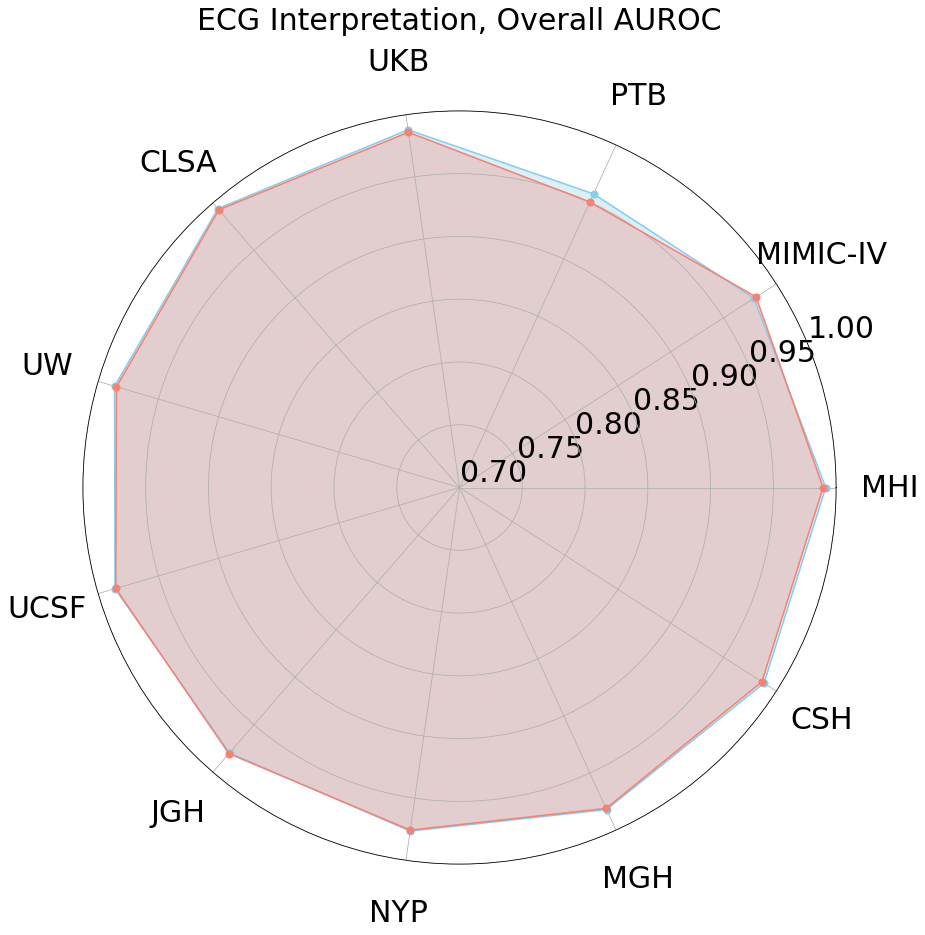

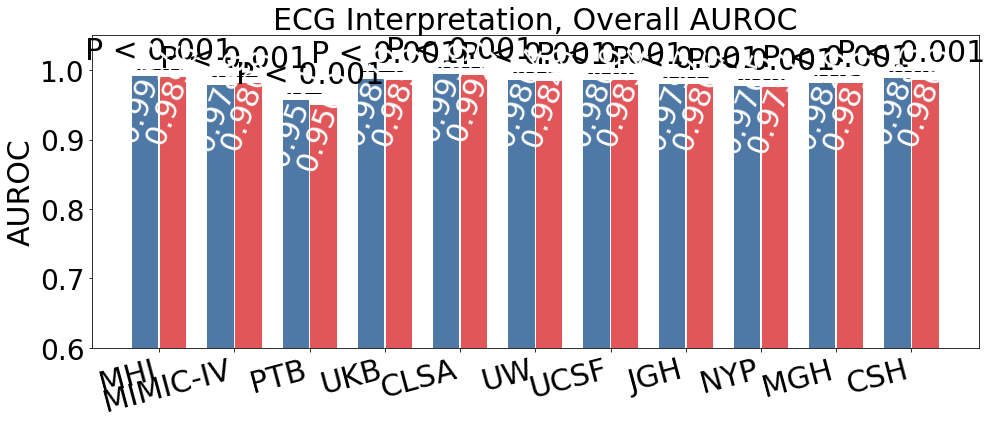

In [36]:
import matplotlib.pyplot as plt
colors = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2', '#59A14F']
#colors = ['#6C757D', '#ADB5BD', '#CED4DA', '#DEE2E6', '#E9ECEF']

COLOR_SL, COLOR_SSL = colors[0], colors[2]

def update_dict(sl, ssl, subset, task_key, idx, metric, add_p_value=True):
    fdf_sl = get_formated_scores('sl', subset, task_key)
    fdf_ssl = get_formated_scores('ssl', subset, task_key)
    idx = f'{idx}_{metric}'
    sl['key'] += [f'{subset}_{idx}']
    ssl['key'] += [f'{subset}_{idx}']
    sl['Mean'] += [round(fdf_sl.loc[idx, 'Mean']/100, 4)]
    ssl['Mean'] += [round(fdf_ssl.loc[idx, 'Mean']/100, 4)]
    sl['95% CI'] += [str([round(ci/100, 4) for ci in eval(fdf_sl.loc[idx, '95% CI'].replace('-', ','))]).replace(',', '-')]
    ssl['95% CI'] += [str([round(ci/100, 4) for ci in eval(fdf_ssl.loc[idx, '95% CI'].replace('-', ','))]).replace(',', '-')]
    if add_p_value:
        ssl['p_value'] += [fdf_ssl.loc[idx, 'p_value']]

def to_df(df_dict, categories):
    for key in categories.keys():
        if not key in df_dict['key']:
            df_dict['key'] += [key]
            df_dict['Mean'] += [0]
            df_dict['95% CI'] += [0]
    df = pd.DataFrame(df_dict)
    df.index = df['key']
    return df
    

def plot_histo(models, categories, title, filename, fontsize=16, y_start=50, y_end=100, hide_last_y=False, show_p_value=False, metric='auroc'):
    # Sample data
    # Sample data
    def get_fig_width():
        len_cat = len(categories)
        return len_cat + 3
    # Set up bar positions
    x = np.arange(len(categories))
    width = 0.35  # Width of the bars

    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(get_fig_width(), 6))

    # Plot bars without error caps using seaborn for improved aesthetics
    # The radar chart needs the data to be a closed loop, so append the start to the end.
    for model in models:          
        scores = model['df'].loc[list(categories.keys()), 'Mean'].tolist()
        cis = model['df'].loc[list(categories.keys()), '95% CI'].tolist()
        model['scores'] = scores
        model['cis'] = [eval(ci.replace('-', ',')) for ci in cis]
        if show_p_value:
            if 'p_value' in model['df'].columns:
                model['p_values'] = model['df'].loc[list(categories.keys()), 'p_value'].tolist()

    # Plot each model’s data on the radar chart
    gap = 0.01
    m1, m2 = models[0], models[1]
    bars_m1 = ax.bar(x - width/2 - gap, m1['scores'], width, label=m1['title'], color=m1['color'])
    bars_m2 = ax.bar(x + width/2 + gap, m2['scores'], width, label=m2['title'], color=m2['color'])

    # Add thin vertical lines for CI
    for i in range(len(categories)):
        ax.vlines(x[i] - width/2, m1['cis'][i][0], m1['cis'][i][1], color='gray', linewidth=1)
        ax.vlines(x[i] + width/2, m2['cis'][i][0], m2['cis'][i][1], color='gray', linewidth=1)
        
        # Calculate and add delta (difference) text
        delta = round(m2['scores'][i] - m1['scores'][i], 2)
        y_position = max(m1['cis'][i][1], m2['cis'][i][1]) + 0.5/100  # Position above bars
        if show_p_value:
            p_val_text = "P < 0.001" if m2['p_values'][i] < 0.001 else f"P = {m2['p_values'][i]:.3f}"
            ax.hlines(y_position+0.5/100, i - width + gap*5 , i + width - gap*5, color='black', linewidth=1)
            ax.text(x[i], y_position+1./100, p_val_text, ha='center', va='bottom', fontsize=fontsize, color='black')
        else:
            ax.text(x[i], y_position, f'Δ={delta}', ha='center', va='bottom', fontsize=fontsize, color='black')

    # Add values inside the bars
    for bar in bars_m1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height - 10/100, f'{height:.4f}', ha='center', va='bottom', color='white', rotation=70, fontsize=fontsize - 6*0)

    for bar in bars_m2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height - 10/100, f'{height:.4f}', ha='center', va='bottom', color='white', rotation=70, fontsize=fontsize - 6*0)

    # Labeling and aesthetics
    #ax.set_xlabel('Categories')
    ax.set_ylabel(metric.upper(), fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize)
    ax.set_xticks(x)
    ax.set_xticklabels(categories.values(), rotation=15, ha='right', fontsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize-2)
    #ax.legend(loc='upper left')

    # Show plot
    plt.ylim(y_start, y_end)
    if hide_last_y:
        ax.yaxis.get_major_ticks()[-1].draw = lambda *args:None
    plt.tight_layout()
    #plt.savefig(f"/volume/deepecg/fairseq-signals/metrics/images/{filename}.png", format="png", dpi=300)  # Save as a high-quality PNG file
    
    plt.show()



def plot_digital_biomarker_ds(title, group, metric='auroc', fontsize=15):
    sl = {'key': [], 'Mean': [], '95% CI': []}
    ssl = {'key': [], 'Mean': [], '95% CI': [], 'p_value': []}

    tasks = getSingletonDataset(group).tasks
    categories = {}
    for task in tasks:
        if task == 'lvef_40':
            update_dict(sl, ssl, group, task_key=task, idx='LVEF_EQUAL_OR_UNDER_40_tte_lvef', metric=metric)
            categories[f'{group}_LVEF_EQUAL_OR_UNDER_40_tte_lvef_{metric}'] = 'LVEF ≤ 40'
        elif task == 'lvef_50':
            update_dict(sl, ssl, group, task_key=task, idx='LVEF_UNDER_50_tte_lvef', metric=metric)
            categories[f'{group}_LVEF_UNDER_50_tte_lvef_{metric}'] ='LVEF < 50'
        elif task == 'afib_5':
            update_dict(sl, ssl, group, task_key=task, idx='label_5y', metric=metric)
            categories[f'{group}_label_5y_{metric}'] ='iAF5' 
        elif task == 'lqts':
            update_dict(sl, ssl, group, task_key=task, idx='LQTS', metric=metric)
            categories[f'{group}_LQTS_{metric}'] = 'LQTS'
        elif task == 'lqts_type':
            update_dict(sl, ssl, group, task_key=task, idx='LQTS_TYPE_1', metric=metric)
            categories[f'{group}_LQTS_TYPE_1_{metric}'] = 'LQTS Type'

    sl = to_df(sl, categories)
    ssl = to_df(ssl, categories)
    
    models = [
        {'title': 'DeepECG-SL', 'df': sl, 'color': COLOR_SL},
        {'title': 'DeepECG-SSL', 'df': ssl, 'color': COLOR_SSL},
    ]
    plot_histo(models, categories, title, f'spider-digital-biomarkers-{group}-{metric}', y_start=.60, y_end=1.0, show_p_value=True, fontsize=fontsize)



def plot_ecg_interpretation_ds(title, group, metric='auroc', fontsize=15):
    sl = {'key': [], 'Mean': [], '95% CI': []}
    ssl = {'key': [], 'Mean': [], '95% CI': [], 'p_value': []}

    for cat in ['RHYTHM', 'CONDUCTION', 'CHAMBER ENLARGEMENT', 'PERICARDITIS', 'INFARCT, ISCHEMIA', 'OTHER', 'ALL']:
        update_dict(sl, ssl, group, task_key='labels_77', idx=f'{cat}_micro', metric=metric)
    categories = {
        f'{group}_ALL_micro_{metric}': 'GLOBAL', 
        f'{group}_RHYTHM_micro_{metric}': 'RHYTHM', 
        f'{group}_CONDUCTION_micro_{metric}': 'CONDUCTION', 
        f'{group}_CHAMBER ENLARGEMENT_micro_{metric}': 'CHAMBER ENLARGEMENT', 
        f'{group}_PERICARDITIS_micro_{metric}': 'PERICARDITIS', 
        f'{group}_INFARCT, ISCHEMIA_micro_{metric}': 'INFARCT, ISCHEMIA', 
        f'{group}_OTHER_micro_{metric}': 'OTHER', 
    }

    sl = to_df(sl, categories)
    ssl = to_df(ssl, categories)
    
    models = [
        {'title': 'DeepECG-SL', 'df': sl, 'color': COLOR_SL},
        {'title': 'DeepECG-SSL', 'df': ssl, 'color': COLOR_SSL},
    ]
    #plot_spider(models, categories, title, f'spider-ecg-interpretation-{group}-{metric}', y_start=70)
    plot_histo(models, categories, title, f'histo-ecg-interpretation-{group}-{metric}', show_p_value=True, y_start=.60, y_end=1.05, fontsize=fontsize)


def plot_ecg_interpretation_cat(title, cat, metric='micro_auroc', groups=DATASETS, fontsize=15):
    sl = {'key': [], 'Mean': [], '95% CI': []}
    ssl = {'key': [], 'Mean': [], '95% CI': [], 'p_value': []}

    #for cat in ['RHYTHM', 'CONDUCTION', 'CHAMBER ENLARGEMENT', 'PERICARDITIS', 'INFARCT, ISCHEMIA', 'OTHER', 'ALL']:
    categories = {}
    for group in groups:
        ds = getSingletonDataset(group)
        update_dict(sl, ssl, group, task_key='labels_77', idx=cat, metric=metric)
        categories[f'{group}_{cat}_{metric}'] = ds.title
    
    sl = to_df(sl, categories)
    ssl = to_df(ssl, categories)
    
    models = [
        {'title': 'DeepECG-SL', 'df': sl, 'color': 'skyblue'},
        {'title': 'DeepECG-SSL', 'df': ssl, 'color': 'salmon'},
    ]
    plot_spider(models, categories, title, f'spider-ecg-interpretation-{group}-{metric}', y_start=.70, y_end=1.0, fontsize=fontsize)

    models = [
        {'title': 'DeepECG-SL', 'df': sl, 'color': COLOR_SL},
        {'title': 'DeepECG-SSL', 'df': ssl, 'color': COLOR_SSL},
    ]
    plot_histo(models, categories, title, f'histo-ecg-interpretation-{cat}-{metric}', show_p_value=True, y_start=.60, y_end=1.05, hide_last_y=True, fontsize=fontsize)

    
datasets = DATASETS
#datasets = ['mhi', 'external', 'external_public', 'external_private']
# datasets = ['mimic']
for ds_key in datasets:
    break
    getSingletonDataset('mimic').title = 'MIMIC-IV'
    ds = getSingletonDataset(ds_key)
    plot_ecg_interpretation_ds(f'ECG interpretation, {ds.title}', ds.key, fontsize=20)
    if len(ds.tasks) == 1:
        continue
    plot_digital_biomarker_ds(f'{ds.title}', ds.key, fontsize=21)
    continue
#ds = getSingletonDataset('mhi')
#plot_digital_biomarker_ds(f'Digital biomarkers, in {ds.title}', ds.key)
#plot_ecg_interpretation_ds(f'ECG interpretation, {ds.title}', ds.key)
#plot_digital_biomarker_ds(f'Digital biomarkers, MIMIC-IV (EPD)', 'mimic')
  
categories = {'ALL': 'OVERALL', 'RHYTHM': 'RHYTHM','CONDUCTION': 'CONDUCTION', 'CHAMBER ENLARGEMENT': 'CHAMBER ENLARGEMENT', 
            'PERICARDITIS': 'PERICARDITIS', 'INFARCT, ISCHEMIA': 'INFARCT, ISCHEMIA', 'OTHER': 'OTHER', }
labels = {'Ventricular tachycardia': 'Ventricular Tachycardia',  'Supraventricular tachycardia': 'Supraventricular Tachycardia', 
          'Afib': 'Atrial Fibrillation', 'Atrial flutter': 'Atrial Flutter', '2nd degree AV block - mobitz 1': '2nd degree AV block - Type 1', 
          '2nd degree AV block - mobitz 2': '2nd degree AV block - Type 2', 'Third Degree AV Block': '3rd degree AV block', 
          'Acute pericarditis': 'Pericarditis', 'Acute MI': 'Acute MI', 'Junctional rhythm': 'Junctional Rhythm',
          'Wolff-Parkinson-White (Pre-excitation syndrome)': 'Wolff-Parkinson-White', 'Premature ventricular complex': 'Premature ventricular complex',
          'Left ventricular hypertrophy': 'Left ventricular hypertrophy', 'Right ventricular hypertrophy': 'Right ventricular hypertrophy'}
for label, title in labels.items():
    break
    getSingletonDataset('mhi').title = 'MHI'
    datasets = ['mhi', 'external_public', 'external_private']
    plot_ecg_interpretation_cat(f'{title}', label, metric='auroc', groups=datasets, fontsize=22)

datasets = ['mhi', 'mimic', 'ptb', 'ukb', 'clsa', 'uw', 'ucsf', 'jgh', 'nyp', 'hms', 'cshs']
plot_ecg_interpretation_cat(f'ECG Interpretation, Overall AUROC', 'ALL', groups=datasets, fontsize=30)

for cat, title in categories.items():    
    break
    # continue
    getSingletonDataset('mhi').title = 'MHI'
    getSingletonDataset('external').title = 'EVD'
    
    datasets = ['mhi', 'mimic', 'ptb', 'ukb', 'clsa', 'uw', 'ucsf', 'jgh', 'nyp', 'hms', 'cshs']
    # datasets = ['mhi', 'external_public', 'external_private']
    plot_ecg_interpretation_cat(f'{title}', cat, groups=datasets, fontsize=21)
    

ValueError: Image size of 626x73002 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 720x432 with 1 Axes>

                                                               key   Mean  \
key                                                                         
mhi_ALL_micro_auroc                            mhi_ALL_micro_auroc  98.96   
mimic_ALL_micro_auroc                        mimic_ALL_micro_auroc  98.08   
ptb_ALL_micro_auroc                            ptb_ALL_micro_auroc  95.00   
ukb_ALL_micro_auroc                            ukb_ALL_micro_auroc  98.59   
clsa_ALL_micro_auroc                          clsa_ALL_micro_auroc  99.27   
external_public_ALL_micro_auroc    external_public_ALL_micro_auroc  98.08   
uw_ALL_micro_auroc                              uw_ALL_micro_auroc  98.48   
ucsf_ALL_micro_auroc                          ucsf_ALL_micro_auroc  98.54   
jgh_ALL_micro_auroc                            jgh_ALL_micro_auroc  98.05   
nyp_ALL_micro_auroc                            nyp_ALL_micro_auroc  97.57   
hms_ALL_micro_auroc                            hms_ALL_micro_auroc  98.10   

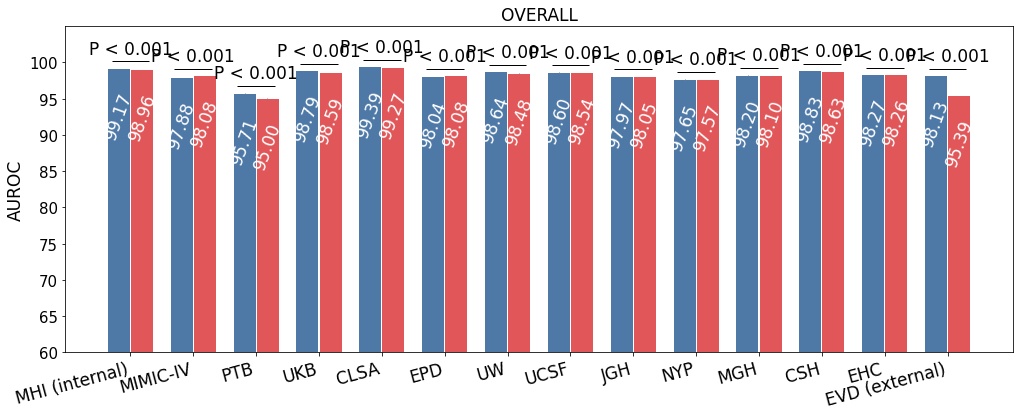

In [2]:
import matplotlib.pyplot as plt
colors = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2', '#59A14F']
#colors = ['#6C757D', '#ADB5BD', '#CED4DA', '#DEE2E6', '#E9ECEF']

COLOR_SL, COLOR_SSL = colors[0], colors[2]

def update_dict(sl, ssl, subset, task_key, idx, metric, add_p_value=True):
    fdf_sl = get_formated_scores('sl', subset, task_key)
    fdf_ssl = get_formated_scores('ssl', subset, task_key)
    idx = f'{idx}_{metric}'
    sl['key'] += [f'{subset}_{idx}']
    ssl['key'] += [f'{subset}_{idx}']
    sl['Mean'] += [fdf_sl.loc[idx, 'Mean']]
    ssl['Mean'] += [fdf_ssl.loc[idx, 'Mean']]
    sl['95% CI'] += [fdf_sl.loc[idx, '95% CI']]
    ssl['95% CI'] += [fdf_ssl.loc[idx, '95% CI']]
    if add_p_value:
        ssl['p_value'] += [fdf_ssl.loc[idx, 'p_value']]

def to_df(df_dict, categories):
    for key in categories.keys():
        if not key in df_dict['key']:
            df_dict['key'] += [key]
            df_dict['Mean'] += [0]
            df_dict['95% CI'] += [0]
    df = pd.DataFrame(df_dict)
    df.index = df['key']
    return df
    


def plot_digital_biomarker_ds(title, group, metric='auroc', fontsize=15):
    sl = {'key': [], 'Mean': [], '95% CI': []}
    ssl = {'key': [], 'Mean': [], '95% CI': [], 'p_value': []}

    tasks = getSingletonDataset(group).tasks
    categories = {}
    for task in tasks:
        if task == 'lvef_40':
            update_dict(sl, ssl, group, task_key=task, idx='LVEF_EQUAL_OR_UNDER_40_tte_lvef', metric=metric)
            categories[f'{group}_LVEF_EQUAL_OR_UNDER_40_tte_lvef_{metric}'] = 'LVEF ≤ 40'
        elif task == 'lvef_50':
            update_dict(sl, ssl, group, task_key=task, idx='LVEF_UNDER_50_tte_lvef', metric=metric)
            categories[f'{group}_LVEF_UNDER_50_tte_lvef_{metric}'] ='LVEF < 50'
        elif task == 'afib_5':
            update_dict(sl, ssl, group, task_key=task, idx='label_5y', metric=metric)
            categories[f'{group}_label_5y_{metric}'] ='iAF5' 
        elif task == 'lqts':
            update_dict(sl, ssl, group, task_key=task, idx='LQTS', metric=metric)
            categories[f'{group}_LQTS_{metric}'] = 'LQTS'
        elif task == 'lqts_type':
            update_dict(sl, ssl, group, task_key=task, idx='LQTS_TYPE_1', metric=metric)
            categories[f'{group}_LQTS_TYPE_1_{metric}'] = 'LQTS Type'

    sl = to_df(sl, categories)
    ssl = to_df(ssl, categories)
    
    models = [
        {'title': 'DeepECG-SL', 'df': sl, 'color': COLOR_SL},
        {'title': 'DeepECG-SSL', 'df': ssl, 'color': COLOR_SSL},
    ]
    plot_histo(models, categories, title, f'spider-digital-biomarkers-{group}-{metric}', y_start=.60, show_p_value=True, fontsize=fontsize)



def plot_ecg_interpretation_ds(title, group, metric='auroc', fontsize=15):
    sl = {'key': [], 'Mean': [], '95% CI': []}
    ssl = {'key': [], 'Mean': [], '95% CI': [], 'p_value': []}

    for cat in ['RHYTHM', 'CONDUCTION', 'CHAMBER ENLARGEMENT', 'PERICARDITIS', 'INFARCT, ISCHEMIA', 'OTHER', 'ALL']:
        update_dict(sl, ssl, group, task_key='labels_77', idx=f'{cat}_micro', metric=metric)
    categories = {
        f'{group}_ALL_micro_{metric}': 'OVERALL', 
        f'{group}_RHYTHM_micro_{metric}': 'RHYTHM', 
        f'{group}_CONDUCTION_micro_{metric}': 'CONDUCTION', 
        f'{group}_CHAMBER ENLARGEMENT_micro_{metric}': 'CHAMBER ENLARGEMENT', 
        f'{group}_PERICARDITIS_micro_{metric}': 'PERICARDITIS', 
        f'{group}_INFARCT, ISCHEMIA_micro_{metric}': 'INFARCT, ISCHEMIA', 
        f'{group}_OTHER_micro_{metric}': 'OTHER', 
    }

    sl = to_df(sl, categories)
    ssl = to_df(ssl, categories)
    
    models = [
        {'title': 'DeepECG-SL', 'df': sl, 'color': COLOR_SL},
        {'title': 'DeepECG-SSL', 'df': ssl, 'color': COLOR_SSL},
    ]
    #plot_spider(models, categories, title, f'spider-ecg-interpretation-{group}-{metric}', y_start=70)
    plot_histo(models, categories, title, f'histo-ecg-interpretation-{group}-{metric}', show_p_value=True, y_start=.60, y_end=1.05, fontsize=fontsize)


def plot_ecg_interpretation_cat(title, cat, metric='micro_auroc', groups=DATASETS, fontsize=15):
    sl = {'key': [], 'Mean': [], '95% CI': []}
    ssl = {'key': [], 'Mean': [], '95% CI': [], 'p_value': []}

    #for cat in ['RHYTHM', 'CONDUCTION', 'CHAMBER ENLARGEMENT', 'PERICARDITIS', 'INFARCT, ISCHEMIA', 'OTHER', 'ALL']:
    categories = {}
    for group in groups:
        ds = getSingletonDataset(group)
        update_dict(sl, ssl, group, task_key='labels_77', idx=cat, metric=metric)
        categories[f'{group}_{cat}_{metric}'] = ds.title
    
    sl = to_df(sl, categories)
    ssl = to_df(ssl, categories)
    print(ssl)
    models = [
        {'title': 'DeepECG-SL', 'df': sl, 'color': COLOR_SL},
        {'title': 'DeepECG-SSL', 'df': ssl, 'color': COLOR_SSL},
    ]
    #plot_spider(models, categories, title, f'spider-ecg-interpretation-{group}-{metric}', y_start=70)
    plot_histo(models, categories, title, f'histo-ecg-interpretation-{cat}-{metric}', show_p_value=True, y_start=60, y_end=105, hide_last_y=True, fontsize=fontsize)

# def plot_ecg_interpretation_label(title, label, metric='auroc', fontsize=15):
    
datasets = DATASETS
# datasets = ['mhi', 'external', 'external_public', 'external_private']
# datasets = ['mimic']
for ds_key in datasets:
    # continue
    
    getSingletonDataset('mimic').title = 'MIMIC-IV'
    ds = getSingletonDataset(ds_key)
    plot_ecg_interpretation_ds(f'ECG interpretation, {ds.title}', ds.key, fontsize=18)
    break
    if len(ds.tasks) == 1:
        continue
    plot_digital_biomarker_ds(f'{ds.title}', ds.key, fontsize=20)
    continue
#ds = getSingletonDataset('mhi')
#plot_digital_biomarker_ds(f'Digital biomarkers, in {ds.title}', ds.key)
#plot_ecg_interpretation_ds(f'ECG interpretation, {ds.title}', ds.key)
#plot_digital_biomarker_ds(f'Digital biomarkers, MIMIC-IV (EPD)', 'mimic')
  
categories = {'ALL': 'OVERALL', 'RHYTHM': 'RHYTHM','CONDUCTION': 'CONDUCTION', 'CHAMBER ENLARGEMENT': 'CHAMBER ENLARGEMENT', 
            'PERICARDITIS': 'PERICARDITIS', 'INFARCT, ISCHEMIA': 'INFARCT, ISCHEMIA', 'OTHER': 'OTHER', }
labels = {'Ventricular tachycardia': 'Ventricular Tachycardia',  'Supraventricular tachycardia': 'Supraventricular Tachycardia', 
          'Afib': 'Atrial Fibrillation', 'Atrial flutter': 'Atrial Flutter', '2nd degree AV block - mobitz 1': '2nd degree AV block - Type 1', 
          '2nd degree AV block - mobitz 2': '2nd degree AV block - Type 2', 'Third Degree AV Block': '3rd degree AV block', 
          'Acute pericarditis': 'Pericarditis', 'Acute MI': 'Acute MI', 'Junctional rhythm': 'Junctional Rhythm',
          'Wolff-Parkinson-White (Pre-excitation syndrome)': 'Wolff-Parkinson-White', 'Premature ventricular complex': 'Premature ventricular complex',
          'Left ventricular hypertrophy': 'Left ventricular hypertrophy', 'Right ventricular hypertrophy': 'Right ventricular hypertrophy' }
for label, title in labels.items():
    break
    getSingletonDataset('mhi').title = 'MHI'
    datasets = ['mhi', 'external_public', 'external_private']
    plot_ecg_interpretation_cat(f'{title}', label, metric='auroc', groups=datasets, fontsize=22)
    
for cat, title in categories.items():    
    plot_ecg_interpretation_cat(f'{title}', cat, groups=DATASETS, fontsize=17)
    break
    # continue
    getSingletonDataset('mhi').title = 'MHI'
    getSingletonDataset('external').title = 'EVD'
    
    datasets = ['mhi', 'mimic', 'ptb', 'ukb', 'clsa', 'uw', 'ucsf', 'jgh', 'nyp', 'hms', 'cshs']
    # datasets = ['mhi', 'external_public', 'external_private']
    plot_ecg_interpretation_cat(f'{title}', cat, groups=datasets, fontsize=16)
    
    

In [8]:
list_clean_labels =  ['Acute pericarditis', 'QS complex in V1-V2-V3', 'T wave inversion (anterior - V3-V4)', 'Right atrial enlargement','2nd degree AV block - mobitz 1','Left posterior fascicular block','Wolff-Parkinson-White (Pre-excitation syndrome)','Junctional rhythm','Premature ventricular complex',"rSR' in V1-V2",'Right superior axis','ST elevation (inferior - II, III, aVF)','Afib','ST elevation (anterior - V3-V4)','RV1 + SV6 > 11 mm','Sinusal','Monomorph','Delta wave','R/S ratio in V1-V2 >1','Third Degree AV Block','LV pacing','Nonspecific intraventricular conduction delay','ST depression (inferior - II, III, aVF)','Regular','Premature atrial complex','2nd degree AV block - mobitz 2','Left anterior fascicular block','Q wave (septal- V1-V2)','Prolonged QT','Left axis deviation','Left ventricular hypertrophy','ST depression (septal- V1-V2)','Supraventricular tachycardia','Atrial paced','Q wave (inferior - II, III, aVF)','no_qrs','T wave inversion (lateral -I, aVL, V5-V6)','Right bundle branch block','ST elevation (septal - V1-V2)','SV1 + RV5 or RV6 > 35 mm','Right axis deviation','RaVL > 11 mm','Polymorph','Ventricular tachycardia','QRS complex negative in III','ST depression (lateral - I, avL, V5-V6)','1st degree AV block','Lead misplacement','Q wave (posterior - V7-V9)','Atrial flutter','Ventricular paced','ST elevation (posterior - V7-V8-V9)','Ectopic atrial rhythm (< 100 BPM)','Early repolarization','Ventricular Rhythm','Irregularly irregular','Atrial tachycardia (>= 100 BPM)','R complex in V5-V6','ST elevation (lateral - I, aVL, V5-V6)','Brugada','Bi-atrial enlargement','Q wave (lateral- I, aVL, V5-V6)','ST upslopping','T wave inversion (inferior - II, III, aVF)','Regularly irregular','Bradycardia','qRS in V5-V6-I, aVL','Q wave (anterior - V3-V4)','Acute MI','ST depression (anterior - V3-V4)','Right ventricular hypertrophy','T wave inversion (septal- V1-V2)','ST downslopping','Left bundle branch block','Low voltage','U wave','Left atrial enlargement']


for l in list_clean_labels:
    if 'ventri' in l.lower():
        print(l)

Premature ventricular complex
Nonspecific intraventricular conduction delay
Left ventricular hypertrophy
Supraventricular tachycardia
Ventricular tachycardia
Ventricular paced
Ventricular Rhythm
Right ventricular hypertrophy


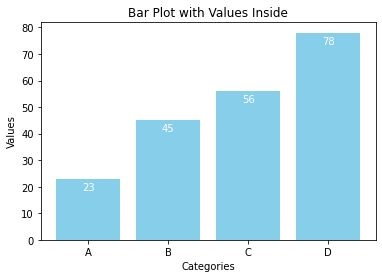

In [7]:
import matplotlib.pyplot as plt

# Sample data
categories = ['A', 'B', 'C', 'D']
values = [23, 45, 56, 78]

# Create the bar plot
plt.bar(categories, values, color='skyblue')

# Add values inside the bars
for i, value in enumerate(values):
    plt.text(i, value - 5,  # Adjust position to inside the bar
             str(value),    # Text to display
             ha='center',   # Center horizontally
             va='bottom',   # Align vertically
             color='white', # Text color
             fontsize=10)   # Font size

# Customize and show the plot
plt.title("Bar Plot with Values Inside")
plt.xlabel("Categories")
plt.ylabel("Values")
plt.show()


In [35]:
ed = getSingletonDataset('external')
epd = getSingletonDataset('external_public')
ehc = getSingletonDataset('external_private')
tkey, mkey = 'afib_5', 'ssl'
t1 = getSingletonTask(tkey, mkey, 'external')
t2 = getSingletonTask(tkey, mkey, 'external_public')
t3 = getSingletonTask(tkey, mkey, 'external_private')
yp1, yt1 = ed.get_y(t1)
yp2, yt2 = epd.get_y(t2)
yp3, yt3 = ehc.get_y(t3)

yp1.shape, yt2.shape, yp3.shape, (yp1[:yp2.shape[0]] == yp2).all(), (yp1[yp2.shape[0]:] == yp3).all(), (yt1[:yt2.shape[0]] == yt2).all(), (yt1[yt2.shape[0]:] == yt3).all()

ed.get_stats(t1), epd.get_stats(t2), ehc.get_stats(t3)
t1.get_scores(True)
t1.delong_test(getSingletonTask(tkey, 'sl', 'external'))

Calculating Permutations: 100%|██████████| 1000/1000 [00:41<00:00, 24.26it/s]


results saved in: /media/data1/achilsowa/results/fairseq/centers/external/ci_scores_ssl-afib_5_0.7_1000.csv


,Category,Metrics,Mean,95% CI,p_value
0,label_5y,auroc,76.36,[76.26 - 76.46],0.073794
1,label_5y,f1score,44.41,[44.25 - 44.57],-1.000000
2,label_5y,auprc,50.24,[50.04 - 50.44],-1.000000


In [6]:
df = pd.read_csv('/media/data1/achilsowa/results/fairseq/centers/external_private/sl_afib_5.csv')
df

,Unnamed: 0,file_name,ground_truth,predictions,center
0,0,NaN,1.0,0.347471,ucsf
1,1,NaN,1.0,0.487258,ucsf
2,2,NaN,1.0,0.632779,ucsf
3,3,NaN,1.0,0.792841,ucsf
4,4,NaN,1.0,0.215513,ucsf
...,...,...,...,...,...
122183,122183,MUSE_20211211_014558_52000.base64,0.0,0.203807,cshs
122184,122184,MUSE_20211211_023054_38000.base64,0.0,0.223465,cshs
122185,122185,MUSE_20211210_172933_93000.base64,0.0,0.248965,cshs
122186,122186,MUSE_20211210_094333_07000.base64,0.0,0.344305,cshs


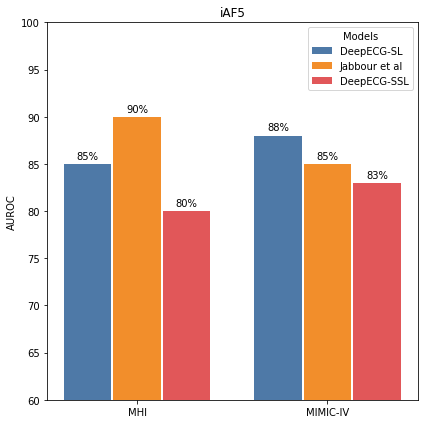

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Data
datasets = ['MHI', 'MIMIC-IV']
models = ['DeepECG-SL', 'Jabbour et al', 'DeepECG-SSL']

# Performance values
performance = {
    'MHI': [85, 90, 80],  # Model A, B, C on Dataset 1
    'MIMIC-IV': [88, 85, 83],  # Model A, B, C on Dataset 2
}

# X-axis positions
x = np.arange(len(datasets))  # Positions for the 2 groups (datasets)
width = 0.25  # Width of each bar

# Colors
colors = ['#4E79A7', '#F28E2B', '#E15759']  # Colors for each model

# Plot
fig, ax = plt.subplots(figsize=(6, 6))

# Plot bars for each model
bars = []
for i, model in enumerate(models):
    gap = (i-1)*0.01
    bars.append(ax.bar(x + i * width - width + gap, 
                       [performance[dataset][i] for dataset in datasets], 
                       width, label=model, color=colors[i]))

# Add labels and titles
ax.set_ylabel('AUROC')
#ax.set_xlabel('Datasets')
ax.set_title('iAF5')
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.legend(title='Models')

# Add value labels on top of bars
def add_labels(bars):
    for bar_group in bars:
        for bar in bar_group:
            height = bar.get_height()
            ax.annotate(f'{height}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # Offset text by 3 points
                        textcoords="offset points",
                        ha='center', va='bottom')

add_labels(bars)

# Adjust layout
plt.ylim(60, 100)
plt.tight_layout()
plt.show()


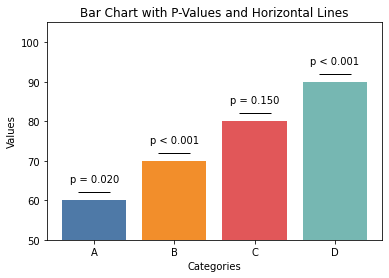

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
categories = ['A', 'B', 'C', 'D']
values = [60, 70, 80, 90]

# Example p-values for each bar comparison
p_values = [0.02, 0.0005, 0.15, 0.00001]

# Create the bar chart
bar_width = 0.6
plt.bar(categories, values, color='skyblue', width=bar_width)
colors = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2', '#59A14F']
#colors = ['#1B9E77', '#D95F02', '#7570B3', '#E7298A', '#66A61E']
#colors = ['#6C757D', '#ADB5BD', '#CED4DA', '#DEE2E6', '#E9ECEF']
#colors = ['#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#FF7F00']

plt.bar(categories, values, color=colors[:len(categories)])

# Set y-axis limits to start at 50
plt.ylim(50, max(values) + 15)

# Annotate p-values on top of the bars with a horizontal line
for i, (x, val) in enumerate(zip(categories, values)):
    p_val_text = "p < 0.001" if p_values[i] < 0.001 else f"p = {p_values[i]:.3f}"
    y_line = val + 2  # Adjust vertical position of the line
    y_text = val + 4  # Adjust vertical position of the p-value text

    # Add the horizontal line
    plt.hlines(y_line, i - bar_width / 2 + 0.1, i + bar_width / 2 - 0.1, color='black', linewidth=1)

    # Add the p-value text above the line
    plt.text(x, y_text, p_val_text, ha='center', va='bottom', fontsize=10)

# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Bar Chart with P-Values and Horizontal Lines')

# Show the plot
plt.show()


In [9]:
get_formated_scores('ssl', 'mhi', 'lvef_50')

,Category,Metrics,Mean,95% CI,p_value
LVEF_UNDER_50_tte_lvef_auroc,LVEF_UNDER_50_tte_lvef,auroc,88.75,[88.40 - 89.12],0.247779
LVEF_UNDER_50_tte_lvef_f1score,LVEF_UNDER_50_tte_lvef,f1score,55.43,[54.53 - 56.31],-1.000000
LVEF_UNDER_50_tte_lvef_auprc,LVEF_UNDER_50_tte_lvef,auprc,56.93,[55.71 - 58.07],-1.000000


In [2]:
datasets = DATASETS
datasets = ['external']
for ds_key in datasets:
    ds = getSingletonDataset(ds_key)
    for task_key in ds.tasks:
        task = getSingletonTask(task_key, 'ssl', ds_key)
        ref = getSingletonTask(task_key, 'sl', ds_key)
        print('='*10, task_key, ds_key, '='*10)
        scores = task.delong_test(ref)
        print('='*20)


========== labels_77 external ==========


/volume/deepecg/fairseq-signals/metrics/utils.py:568: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)
/volume/deepecg/fairseq-signals/metrics/utils.py:568: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)
/volume/deepecg/fairseq-signals/metrics/utils.py:381: RuntimeWarning: invalid value encountered in divide
  aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
/volume/deepecg/fairseq-signals/metrics/utils.py:383: RuntimeWarning: invalid value encountered in divide
  v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
/root/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/root/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/volume/deepecg/

========== afib_5 external ==========
========== lvef_40 external ==========


/volume/deepecg/fairseq-signals/metrics/utils.py:568: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)
/volume/deepecg/fairseq-signals/metrics/utils.py:568: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


========== lvef_50 external ==========


/volume/deepecg/fairseq-signals/metrics/utils.py:568: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)
/volume/deepecg/fairseq-signals/metrics/utils.py:568: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


In [9]:
def update_dict(sl, ssl, subset, task_key, idx, metric):
    fdf_sl = get_formated_scores('sl', subset, task_key)
    fdf_ssl = get_formated_scores('ssl', subset, task_key)
    idx = f'{idx}_{metric}'
    sl['key'] += [f'{subset}_{idx}']
    ssl['key'] += [f'{subset}_{idx}']
    sl['Mean'] += [fdf_sl.loc[idx, 'Mean']]
    ssl['Mean'] += [fdf_ssl.loc[idx, 'Mean']]
    sl['95% CI'] += [fdf_sl.loc[idx, '95% CI']]
    ssl['95% CI'] += [fdf_ssl.loc[idx, '95% CI']]

def to_df(df_dict, categories):
    for key in categories.keys():
        if not key in df_dict['key']:
            df_dict['key'] += [key]
            df_dict['Mean'] += [0]
            df_dict['95% CI'] += [0]
    df = pd.DataFrame(df_dict)
    df.index = df['key']
    return df
    
def plot_ecg_interpretation_all(title, metric='auroc'):
    sl = {'key': [], 'Mean': [], '95% CI': []}
    ssl = {'key': [], 'Mean': [], '95% CI': []}    
    for subset in ['mhi', 'mimic', 'ptb', 'clsa', 'ukb', 'uw', 'ucsf', 'hms', 'nyp', 'jgh', 'cshs']:
        update_dict(sl, ssl, subset, task_key='labels_77', idx='ALL_micro', metric=metric)
    
    categories = {
        f'mhi_ALL_micro_{metric}': 'MHI', 
        f'mimic_ALL_micro_{metric}': 'MIMIC-IV', 
        f'ptb_ALL_micro_{metric}': 'PTB', 
        f'ukb_ALL_micro_{metric}': 'UKB', 
        f'clsa_ALL_micro_{metric}': 'CLSA', 
        f'uw_ALL_micro_{metric}': 'UW', 
        f'ucsf_ALL_micro_{metric}': 'UCSF', 
        f'hms_ALL_micro_{metric}': 'MGH', 
        f'nyp_ALL_micro_{metric}': 'NYP', 
        f'jgh_ALL_micro_{metric}': 'JGH', 
        f'cshs_ALL_micro_{metric}': 'CSH', 
    }
    sl = to_df(sl, categories)
    ssl = to_df(ssl, categories)
    csl, cssl = COLOR_SSL, COLOR_SL
    csl, cssl = 'skyblue', 'salmon'
    models = [
        {'title': 'DeepECG-SL', 'df': sl, 'color': csl},
        {'title': 'DeepECG-SSL', 'df': ssl, 'color': cssl},
    ]
    
    plot_spider(models, categories, title, f'spider-ecg-interpretation-all-{metric}', y_start=.70, fig_size=8, fontsize=20)
    #plot_histo(models, categories, title, f'histo-ecg-interpretation-all-{metric}', metric)

def plot_ecg_interpretation_ds(title, group, metric='auroc'):
    sl = {'key': [], 'Mean': [], '95% CI': []}
    ssl = {'key': [], 'Mean': [], '95% CI': []}

    for cat in ['RHYTHM', 'CONDUCTION', 'CHAMBER ENLARGEMENT', 'PERICARDITIS', 'INFARCT, ISCHEMIA', 'OTHER', 'ALL']:
        update_dict(sl, ssl, group, task_key='labels_77', idx=f'{cat}_micro', metric=metric)
    categories = {
        f'{group}_RHYTHM_micro_{metric}': 'RHYTHM', 
        f'{group}_CONDUCTION_micro_{metric}': 'CONDUCTION', 
        f'{group}_CHAMBER ENLARGEMENT_micro_{metric}': 'CHAMBER ENLARGEMENT', 
        f'{group}_PERICARDITIS_micro_{metric}': 'PERICARDITIS', 
        f'{group}_INFARCT, ISCHEMIA_micro_{metric}': 'INFARCT, ISCHEMIA', 
        f'{group}_OTHER_micro_{metric}': 'OTHER', 
        #f'{group}_ALL_micro_{metric}': 'TOTAL', 
    }

    sl = to_df(sl, categories)
    ssl = to_df(ssl, categories)
    
    models = [
        {'title': 'DeepECG-SL', 'df': sl, 'color': 'skyblue'},
        {'title': 'DeepECG-SSL', 'df': ssl, 'color': 'salmon'},
    ]
    plot_spider(models, categories, title, f'spider-ecg-interpretation-{group}-{metric}', y_start=70)
    #plot_histo(models, categories, title, f'histo-ecg-interpretation-{group}-{metric}')


def plot_digital_biomarker_ds(title, group, metric='auroc'):
    sl = {'key': [], 'Mean': [], '95% CI': []}
    ssl = {'key': [], 'Mean': [], '95% CI': []}

    tasks = getSingletonDataset(group).tasks
    categories = {}
    for task in tasks:
        if task == 'lvef_40':
            update_dict(sl, ssl, group, task_key=task, idx='LVEF_EQUAL_OR_UNDER_40_tte_lvef', metric=metric)
            categories[f'{group}_LVEF_EQUAL_OR_UNDER_40_tte_lvef_{metric}'] = 'LVEF ≤ 40'
        elif task == 'lvef_50':
            update_dict(sl, ssl, group, task_key=task, idx='LVEF_UNDER_50_tte_lvef', metric=metric)
            categories[f'{group}_LVEF_UNDER_50_tte_lvef_{metric}'] ='LVEF < 50'
        elif task == 'afib_5':
            update_dict(sl, ssl, group, task_key=task, idx='label_5y', metric=metric)
            categories[f'{group}_label_5y_{metric}'] ='iAF5' 
        elif task == 'lqts':
            update_dict(sl, ssl, group, task_key=task, idx='LQTS', metric=metric)
            categories[f'{group}_LQTS_{metric}'] = 'LQTS'
        elif task == 'lqts_type':
            update_dict(sl, ssl, group, task_key=task, idx='LQTS_TYPE_1', metric=metric)
            categories[f'{group}_LQTS_TYPE_1_{metric}'] = 'LQTS Type'

    sl = to_df(sl, categories)
    ssl = to_df(ssl, categories)
    
    models = [
        {'title': 'DeepECG-SL', 'df': sl, 'color': 'skyblue'},
        {'title': 'DeepECG-SSL', 'df': ssl, 'color': 'salmon'},
    ]
    plot_spider(models, categories, title, f'spider-digital-biomarkers-{group}-{metric}', y_start=60)
    #plot_histo(models, categories, title, f'histo-digital-biomarkers-{group}-{metric}', metric)




def sl_ssl_ds_size(tasks, title, start_y=70, fontsize=15, metric='auroc'):
    # Prepare data
    tasks_old = [
    {"name": "LQTS Type", "n_samples": 334, "sl_auroc": 85.04, "ssl_auroc": 93.06},
    {"name": "LQTS", "n_samples": 2741, "sl_auroc": 85.04, "ssl_auroc": 93.72},
    {"name": "LVEF ≤ 40", "n_samples": 89500, "sl_auroc": 93.72, "ssl_auroc": 93.57},
    {"name": "LVEF < 50", "n_samples": 89500, "sl_auroc": 98.53, "ssl_auroc": 93.75},
    {"name": "iAF5", "n_samples": 537742, "sl_auroc": 97.39, "ssl_auroc": 97.2},
    {"name": "ECG 77", "n_samples": 1166896, "sl_auroc": 93.17, "ssl_auroc": 93.96},
    ]
    # start_y=85
    # tasks = tasks_old
    markers = [task["mark"] for task in tasks ] #"o", "s", "^", "^", "D", "x"]  # Circle, square, triangle, diamond
    # markers = ["o", "s", "^", "^", "D", "x"]  # Circle, square, triangle, diamond
    n_samples = [task["n_samples"] for task in tasks]
    sl_auroc = [task["sl_auroc"] for task in tasks]
    ssl_auroc = [task["ssl_auroc"] for task in tasks]
    task_names = [task["name"] for task in tasks]
    colors = ['skyblue', 'salmon']
    colors = ['blue', 'green']
    colors = [COLOR_SL, COLOR_SSL]

    # Plot SL and SSL points with unique markers
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xscale("log")
    ax.set_xlim(min(n_samples) * 0.8, max(n_samples) * 1.2)
    ax.set_ylim(start_y/100, 1)
    fontsize=15

    for i, task in enumerate(tasks):
        ax.plot(task["n_samples"], task["sl_auroc"], markersize=fontsize, marker=markers[i], color=colors[0], label=f"SL ({task['name']})", alpha=0.8, linestyle="None")
        ax.plot(task["n_samples"], task["ssl_auroc"], markersize=fontsize, marker=markers[i], color=colors[1], label=f"SSL ({task['name']})", alpha=0.8, linestyle="None")

    # Connect points for the same model with dotted lines
    ax.plot(n_samples, sl_auroc, linestyle="--", color=colors[0], alpha=0.6, label="SL (Trend)")
    ax.plot(n_samples, ssl_auroc, linestyle="--", color=colors[1], alpha=0.6, label="SSL (Trend)")

    # Add labels for each point
    for i, task in enumerate(tasks):
        ax.text(task["n_samples"], task["sl_auroc"], f"SL ({task['sl_auroc']})", fontsize=fontsize, ha="left", color=colors[0])
        ax.text(task["n_samples"], task["ssl_auroc"], f"SSL ({task['ssl_auroc']})", fontsize=fontsize, ha="right", color=colors[1])


    # Plot SL and SSL points
    #ax.plot(n_samples, sl_auroc, "o--", color="blue", label="SL", alpha=0.8)
    #ax.plot(n_samples, ssl_auroc, "o--", color="green", label="SSL", alpha=0.8)

    # Add labels for each point
    #for i, (x, y) in enumerate(zip(n_samples, sl_auroc)):
    #    ax.text(x, y, f"SL ({task_names[i]})", fontsize=10, ha="right", color="blue")

    #for i, (x, y) in enumerate(zip(n_samples, ssl_auroc)):
    #    ax.text(x, y, f"SSL ({task_names[i]})", fontsize=10, ha="left", color="green")

    # Aesthetics
    ax.set_xlabel("Number of Samples (Log Scale)", fontsize=fontsize+2)
    ax.set_ylabel(metric.upper(), fontsize=fontsize+2)
    ax.set_title(title, fontsize=fontsize+4)
    # ax.legend(fontsize=10, loc="lower left")
    ax.grid(visible=True, linestyle="--", alpha=0.6)

    # Show plot
    plt.tight_layout()
    plt.show()




def line_plot_ds(ds_key: str, metric='auroc', start_y=70):
    task_to_count = {'labels_77': 1166896, 'afib_5': 537742, 'lvef_50': 89500, 'lvef_40': 89500, 'lqts': 2741, 'lqts_type': 334}
    task_to_str = {'labels_77': 'ECG 77', 'afib_5': 'iAF5', 'lvef_50': 'LVEF < 50', 'lvef_40': 'LVEF ≤ 40', 'lqts': 'LQTS', 'lqts_type': 'LQTS Type'}
    task_to_label = {'labels_77': f'ALL_micro_{metric}', 'afib_5': f'label_5y_{metric}', 'lvef_50': f'LVEF_UNDER_50_tte_lvef_{metric}', 'lvef_40': f'LVEF_EQUAL_OR_UNDER_40_tte_lvef_{metric}', 'lqts': f'LQTS_{metric}', 'lqts_type': f'LQTS_TYPE_1_{metric}'}
    task_to_mark = {'labels_77': 'o', 'afib_5': 's', 'lvef_50': 'D', 'lvef_40': '^', 'lqts': 'x', 'lqts_type': '*'}
    tasks = []

    ds = getSingletonDataset(ds_key)
    counts = [(task_key, ds.get_stats(getSingletonTask(task_key, 'sl', ds.key))['$count$']) for task_key in ds.tasks]
    counts = sorted(counts, key=lambda x: x[1])
    for task_key in ds.tasks:
        sl = get_formated_scores('sl', ds.key, task_key)
        ssl = get_formated_scores('ssl', ds.key, task_key)
        key = task_to_label[task_key]
        tasks += [{
            "name": task_to_str[task_key], 
            "n_samples": task_to_count[task_key], 
            "mark": task_to_mark[task_key], 
            "sl_auroc": round(sl.loc[key, 'Mean']/100, 2),
            "ssl_auroc": round(ssl.loc[key, 'Mean']/100, 2)
        },]
    sl_ssl_ds_size(tasks, title=f'{metric.upper()}, {ds.title}', start_y=start_y)


#plot_digital_biomarker_ds('biomarker', 'external_private')
#plot_dataset_spider(title='Model performance on MHI. AUROC', subset='mhi', tasks=['labels_77', 'lvef_50', 'lvef_40', 'afib_5', 'lqts', 'lqts_type'])
#plot_dataset_spider(title='Model performance on MIMIC-IV. AUROC', subset='mimic', tasks=['labels_77', 'lvef_50', 'lvef_40', 'afib_5', ])
#plot_dataset_spider(title='Model performance on EHC datasets. AUROC', subset='ucsf', tasks=['labels_77', 'lvef_50', 'lvef_40', 'afib_5', ])
#plot_ecg_interpretation_main('AUROC on Ecg interpretation accross datasets.', metric='auroc')
#plot_ecg_interpretation_ds_group('AUROC on Ecg interpretation categories\' accross EHC datasets.', group='external_private', metric='auroc')
#plot_ecg_interpretation_ds_group('AUROC on Ecg interpretation categories\' accross EPC datasets.', group='external_public', metric='auroc')
#plot_ecg_interpretation_ds_group('AUROC on Ecg interpretation categories\' accross internal datasets (MHI).', group='mhi', metric='auroc')

#plot_ecg_interpretation_all('ECG interpretation, GLOBAL AUROC', metric='auroc')
datasets = ['mhi', 'external_public', 'external_private']
for subset in datasets:
    continue
    ds = getSingletonDataset(subset)
    plot_ecg_interpretation_ds(f'ECG interpretation, AUROC,  {ds.title}', group=subset, metric='auroc')
    #plot_digital_biomarker_ds(f'AUROC of Digital biomarkers in {ds.title} dataset.', group=subset, metric='auroc')
    
line_plot_ds('mhi')
line_plot_ds('external_public')
line_plot_ds('external_private')



NameError: name 'COLOR_SL' is not defined

In [ ]:

def sl_ssl_ds_efficiency(tasks, title, start_y=70, fontsize=15, metric='auroc'):
    #markers = [task["mark"] for task in tasks ] #"o", "s", "^", "^", "D", "x"]  # Circle, square, triangle, diamond
    markers = ["o", "s", "^", "^", "D", "x"]  # Circle, square, triangle, diamond
    n_samples = [task["n_samples"] for task in tasks]
    sl_auroc = [task["sl_auroc"] for task in tasks]
    ssl_auroc = [task["ssl_auroc"] for task in tasks]
    task_names = [task["name"] for task in tasks]
    colors = ['skyblue', 'salmon']
    colors = ['blue', 'green']
    colors = [COLOR_SL, COLOR_SSL]

    # Plot SL and SSL points with unique markers
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xscale("log")
    ax.set_xlim(min(n_samples) * 0.8, max(n_samples) * 1.2)
    ax.set_ylim(start_y, 100)
    fontsize=15

    for i, task in enumerate(tasks):
        ax.plot(task["n_samples"], task["sl_auroc"], marker=markers[i], color=colors[0], label=f"SL ({task['name']})", alpha=0.8, linestyle="None")
        ax.plot(task["n_samples"], task["ssl_auroc"], marker=markers[i], color=colors[1], label=f"SSL ({task['name']})", alpha=0.8, linestyle="None")

    # Connect points for the same model with dotted lines
    ax.plot(n_samples, sl_auroc, linestyle="--", color=colors[0], alpha=0.6, label="SL (Trend)")
    ax.plot(n_samples, ssl_auroc, linestyle="--", color=colors[1], alpha=0.6, label="SSL (Trend)")

    # Add labels for each point
    for i, task in enumerate(tasks):
        ax.text(task["n_samples"], task["sl_auroc"], f"SL ({task['sl_auroc']})", fontsize=fontsize, ha="left", color=colors[0])
        ax.text(task["n_samples"], task["ssl_auroc"], f"SSL ({task['ssl_auroc']})", fontsize=fontsize, ha="right", color=colors[1])


    # Plot SL and SSL points
    #ax.plot(n_samples, sl_auroc, "o--", color="blue", label="SL", alpha=0.8)
    #ax.plot(n_samples, ssl_auroc, "o--", color="green", label="SSL", alpha=0.8)

    # Add labels for each point
    #for i, (x, y) in enumerate(zip(n_samples, sl_auroc)):
    #    ax.text(x, y, f"SL ({task_names[i]})", fontsize=10, ha="right", color="blue")

    #for i, (x, y) in enumerate(zip(n_samples, ssl_auroc)):
    #    ax.text(x, y, f"SSL ({task_names[i]})", fontsize=10, ha="left", color="green")

    # Aesthetics
    ax.set_xlabel("Number of Samples (Log Scale)", fontsize=fontsize+2)
    ax.set_ylabel(metric.upper(), fontsize=fontsize+2)
    ax.set_title(title, fontsize=fontsize+4)
    # ax.legend(fontsize=10, loc="lower left")
    ax.grid(visible=True, linestyle="--", alpha=0.6)

    # Show plot
    plt.tight_layout()
    plt.show()


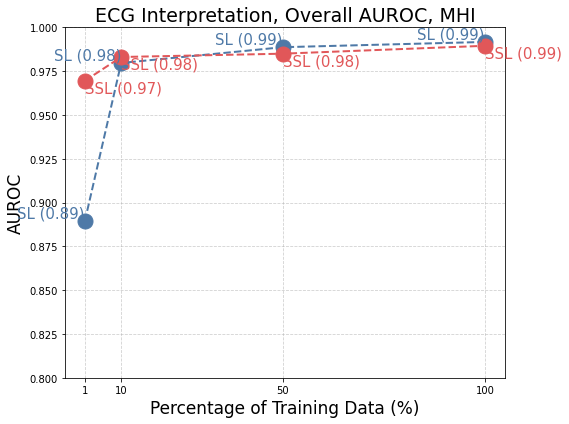

In [59]:
import matplotlib.pyplot as plt

# Data: percentages of training data and corresponding AUROCs
percentages = [1, 10, 50, 100]
deepecg_sl_aurocs = [0.8894, 0.9797, 0.9887, 0.9917]  # Replace with actual values
deepecg_ssl_aurocs = [0.9695, 0.9831, 0.9850, 0.9895]  # Replace with actual values

def sl_ssl_efficiency(percentages, sl_aurocs, ssl_aurocs, fontsize=15 ):
    # Create the plot
    plt.figure(figsize=(8, 6))

    # Plot DeepECG-SL
    plt.plot(percentages, sl_aurocs, markersize=fontsize, marker='o', linestyle="--", label='DeepECG-SL', color=COLOR_SL, linewidth=2)
    # Add text annotations for DeepECG-SL
    for x, y in zip(percentages, sl_aurocs):
        plt.text(x, y, f'SL ({y:.2f})', fontsize=fontsize, color=COLOR_SL, ha='right', va='bottom')

    # Plot DeepECG-SSL
    plt.plot(percentages, ssl_aurocs, markersize=fontsize, marker='o', linestyle="--", label='DeepECG-SSL', color=COLOR_SSL, linewidth=2)
    for x, y in zip(percentages, ssl_aurocs):
        plt.text(x, y, f'SSL ({y:.2f})', fontsize=fontsize, color=COLOR_SSL, ha='left', va='top')


    



    # Add titles and labels
    plt.title('ECG Interpretation, Overall AUROC, MHI', fontsize=fontsize+4)
    plt.xlabel('Percentage of Training Data (%)', fontsize=fontsize+2)
    plt.ylabel('AUROC', fontsize=fontsize+2)
    plt.xticks(percentages)
    plt.ylim(0.8, 1.0)  # Set y-axis limits to focus on AUROC range
    plt.grid(True, linestyle='--', alpha=0.6)

    # Add legend
    # plt.legend(fontsize=12)

    # Show the plot
    plt.tight_layout()
    plt.show()

sl_ssl_efficiency(percentages, deepecg_sl_aurocs, deepecg_ssl_aurocs)

In [55]:
for perc in [1, 10, 50, 100]:
    for model in ['sl', 'ssl']:
        task = getSingletonTask('labels_77', model, 'mhi', perc)
        print(task.key)

model, perc = 'ssl', 50
task = getSingletonTask('labels_77', model, 'mhi', perc)
task.get_scores()[35:40] # 88.94, 97.97, 98.87, 99.17,       96.95, 98.31, 98.81, 98.95
        

labels_77_1
labels_77_1
labels_77_10
labels_77_10
labels_77_50
labels_77_50
labels_77
labels_77


,Unnamed: 0,Category,Metrics,Mean,95% CI
35,35,OTHER,macro_auprc,60.29,[59.90 - 60.73]
36,36,ALL,micro_auroc,98.81,[98.80 - 98.81]
37,37,ALL,macro_auroc,96.85,[96.79 - 96.92]
38,38,ALL,micro_f1score,83.12,[83.08 - 83.17]
39,39,ALL,macro_f1score,56.16,[55.99 - 56.34]


In [20]:
get_formated_scores('sl', 'ucsf', 'labels_77').head(40)

,Unnamed: 0,Category,Metrics,Mean,95% CI
RHYTHM_micro_auroc,0,RHYTHM,micro_auroc,99.10,[99.08 - 99.11]
RHYTHM_macro_auroc,1,RHYTHM,macro_auroc,95.35,[94.38 - 96.26]
RHYTHM_micro_f1score,2,RHYTHM,micro_f1score,25.13,[25.10 - 25.16]
RHYTHM_macro_f1score,3,RHYTHM,macro_f1score,17.66,[17.62 - 17.69]
RHYTHM_micro_auprc,4,RHYTHM,micro_auprc,96.33,[96.28 - 96.38]
RHYTHM_macro_auprc,5,RHYTHM,macro_auprc,63.63,[63.12 - 64.15]
CONDUCTION_micro_auroc,6,CONDUCTION,micro_auroc,97.64,[97.60 - 97.68]
CONDUCTION_macro_auroc,7,CONDUCTION,macro_auroc,88.56,[85.60 - 89.72]
CONDUCTION_micro_f1score,8,CONDUCTION,micro_f1score,4.83,[4.80 - 4.86]
CONDUCTION_macro_f1score,9,CONDUCTION,macro_f1score,4.34,[4.31 - 4.37]


In [32]:
# Generate Ecg interpretation table
def format_scores(scores):
    Label = 'Category'
    df = scores.copy()

    if 'Label' in df.columns:
        Label = 'Label'
    for i in range(len(df)):
        if df.loc[i, Label] == 'Total':
            df.loc[i, Label] = 'ALL'
    df.index = df[Label] + '_' + df['Metrics']
    #df = df[['Mean', '95% CI']]
    return df

def latext_text(text: str):
    return text.replace('>=','$\\geq$').replace('<=', '$\\leq$').replace('>', '$>$').replace('<', '$<$').replace('_', '\\_')
def bold(text, call=True):
    return '\\textbf{'+str(text)+'}' if call else '\\text{'+str(text)+'}'

def metric_block(row1,  row2, bold_max=True, inline=False):
    mean1, ci1 = row1
    mean2, ci2 = row2
    def is_in(v, interval):
        return interval[0]<=v and v <= interval[1]
    def delta():
        diff = float(mean2)-float(mean1)
        ci1_f = eval(ci1.replace(' - ', ','))
        ci2_f = eval(ci2.replace(' - ', ','))

        signif = -1 if diff < 0 else 1
        #diff = f'+{diff}' if diff > 0 else f'-{diff}'
        if is_in(ci1_f[0] , ci2_f) or is_in(ci1_f[1], ci2_f) or is_in(ci2_f[0], ci1_f) or is_in(ci2_f[1], ci1_f):
            signif = 0
        return diff, signif
    def tabular(mean, ci, best=False, inline=False):
        ci = ci.replace(' - ', ', ').replace('[', '(').replace(']', ')')
        #ci = f'${ci}$'
        if inline:
            #return bold(mean, best)
            return bold(mean, best) + '\\small{'+ bold(ci, best) + '}'
        else:
            return '\\begin{tabular}{@{}c@{}} ' + f'{bold(mean, best)} \\\\ {bold(ci, best)} ' + '\\end{tabular}'

        
    diff, signif = delta()
    if signif == 1:
        return  f'{tabular(mean1, ci1, False, inline)} & {tabular(mean2,  ci2, True and bold_max, inline)} & +{float(diff):.2f} '
    elif signif == -1:
        return  f'{tabular(mean1, ci1, True and bold_max, inline)} & {tabular(mean2,  ci2, False, inline)} & {float(diff):.2f} '
    else:
        return  f'{tabular(mean1, ci1, False, inline)} & {tabular(mean2,  ci2, False, inline)} &  -'

def table_task_v1(caption, caption_note, label, header, categories, datasets):
    table = '\\begin{table}[H]'
    table += '\n\t\\centering'
    table += '\n\t\\caption{'+caption+'}'
    table += '\n\t\\begin{adjustbox}{width=\\textwidth}'
    table += '\n\t\\begin{tabular}{ll'+'c'*3*len(datasets)+'}'
    table += '\n\t\t\\toprule'
    table += header
    for _, (text, _, _) in datasets.items():
        table += '\n\t\t& \multicolumn{3}{c}{\\bf{'+text+'}}'
    table += ' \n\t\t\\\\'    
    table += '\n\t\t'
    for v in range(3, len(datasets)*4, 3):
        table += '\\cmidrule(lr){'+str(v)+'-'+str(v+2)+'} '
    
    table += '\n\t\t & '+ '& DeepECG-SL & DeepECG-SSL & \(\Delta_{SSL-SL}\)'*len(datasets) + ' \\\\'
    table += '\n\t\t\\midrule'

    for cat, (text, metrics) in categories.items():
        table += '\n\t\t\\multirow{'+str(2*len(metrics))+'}{*}{'+text+'}'
        for mkey, metric in metrics.items():
            table += f'\n\t\t& {metric} '
            for _, (_, sl, ssl) in datasets.items():
                key = f'{cat}_{mkey}'
                table += f"& {metric_block(sl.loc[key, ['Mean', '95% CI']], ssl.loc[key, ['Mean', '95% CI']], )} " if key in sl.index else '& - & - & -'
            table += ' \\\\'
        table += '\n\t\t\\midrule'

    table += '\n\t\\end{tabular}'
    table += '\n\t\\end{adjustbox}'
    table += '\n\t\\label{'+label+'}'
    if caption_note is not None:
        table += '\n\t\\captionsetup{justification=centering, font=small} % Center align and set font size of the note'
        table += '\n\t\\captionsetup{skip=5pt} % Adjust spacing before note'
        table += '\n\t\\caption*{\\tiny \\textit{Note:} '+caption_note+'}'
    table += '\n\\end{table}'
    return table


def table_task_v2(caption, caption_note, label, header, categories, datasets, metrics, bold_best=True):
    table = '\\begin{table}[H]'
    table += '\n\t\\centering'
    table += '\n\t\\caption{'+caption+'}'
    table += '\n\t\\begin{adjustbox}{max width=\\textwidth}'
    table += '\n\t\\begin{tabular}{l'+'cc'*3*len(metrics)+'}'
    table += '\n\t\t\\toprule\n'
    table += '\n\t\t\\multirow{2}{*}{\\textbf{Dataset}} & \multirow{2}{*}{{Category}}'
    for _, text  in metrics.items():
        table += '\n\t\t& \multicolumn{3}{c}{\\textbf{'+text+'}}'
    table += ' \n\t\t\\\\'    
    table += '\n\t\t'
    for v in range(3, len(metrics)*4, 3):
        table += '\\cmidrule(lr){'+str(v)+'-'+str(v+2)+'} '
    
    table += '\n\t\t & '+ '& DeepECG-SL & DeepECG-SSL & \(\Delta_{SSL-SL}\)'*len(metrics) + ' \\\\'
    table += '\n\t\t\\midrule'

    for dkey, (dtext, sl, ssl) in datasets.items():
        table += '\n\t\t %'+dkey
        table += '\n\t\t\\multirow{'+str(2*len(categories))+'}{*}{\\bf{'+dtext+'}}'
        for cat, text in categories.items():
            if cat == 'ALL':
                table += '\n\t\t\\cmidrule(lr){2-2} ' + ' '.join(['\\cmidrule(lr){'+str(v)+'-'+str(v+2)+'} ' for v in range(3, len(metrics)*4, 3)])
            
            table += '\n\t\t& '+text #\\multirow{2}{*}{'+text+'}'
            
            for mkey, _ in metrics.items():
                key = f'{cat}_{mkey}'
                table += f"& {metric_block(sl.loc[key, ['Mean', '95% CI']], ssl.loc[key, ['Mean', '95% CI']], bold_best)} "
            table += ' \\\\'        
        table += '\n\t\t\\midrule'

    table += '\n\t\\bottomrule'
    table += '\n\t\\end{tabular}'
    table += '\n\t\\end{adjustbox}'
    table += '\n\t\\label{'+label+'}'
    if caption_note is not None:
        table += '\n\t\\captionsetup{justification=centering, font=small} % Center align and set font size of the note'
        table += '\n\t\\captionsetup{skip=5pt} % Adjust spacing before note'
        table += '\n\t\\caption*{\\tiny \\textit{Note:} '+caption_note+'}'
    
    table += '\n\\end{table}'
    return table


def table_task_dataset(caption, caption_note, label, header, categories, sl_scores, ssl_scores, stats, metrics, group_metrics, bold_best=True):
    
    def to_percentage(num, percentage=True):
        return f'{float(num)*100:.1f}' if percentage else f'{float(num):.3f}'
    def get_key_label(key_label):
        if isinstance(key_label, (tuple, list)):
            return key_label[0], key_label[1]
        else:
            return key_label, key_label
    
    table = '\\begin{table}[H]'
    table += '\n\t\\centering'
    table += '\n\t\\caption{'+caption+'}'
    table += '\n\t\\begin{adjustbox}{max width=\\textwidth}'
    table += '\n\t\\begin{tabular}{l'+'cc'*3*len(metrics)+'}'
    table += '\n\t\t\\toprule\n'
    table += '\n\t\t\\multirow{2}{*}{\\textbf{Labels}} & \multirow{2}{*}{Prevalance \%}'
    for _, text  in metrics.items():
        table += '\n\t\t& \multicolumn{3}{c}{\\textbf{'+text+'}}'
    table += ' \n\t\t\\\\'    
    table += '\n\t\t'
    for v in range(3, len(metrics)*4, 3):
        table += '\\cmidrule(lr){'+str(v)+'-'+str(v+2)+'} '
    
    table += '\n\t\t & '+ '& DeepECG-SL & DeepECG-SSL & \(\Delta_{SSL-SL}\)'*len(metrics) + ' \\\\'
    table += '\n\t\t\\midrule'
    
    for cat, (title, items) in categories.items():
        table += '\n\t\t %'+cat
        #table += '\n\t\t\\multirow{'+str(2*len(items))+'}{*}{\\bf{'+title+'}}'
        
        for item in items:
            table += '\n\t\t'+latext_text(item)+' ' #\\multirow{2}{*}{'+text+'}'
            table += f"& {to_percentage(stats[item]/stats['$count$'])} \%"
            for mkey, _ in metrics.items():
                key = f'{item}_{mkey}'
                table += f"& {metric_block(sl_scores.loc[key, ['Mean', '95% CI']], ssl_scores.loc[key, ['Mean', '95% CI']], bold_best, True)} "
            table += ' \\\\'

        if len(group_metrics) > 0:
            table += '\n\t\t\\cmidrule(lr){2-2} ' + ' '.join(['\\cmidrule(lr){'+str(v)+'-'+str(v+2)+'} ' for v in range(3, len(metrics)*4, 3)])    
            table += '\n\t\t\\bf{'+title+'}' #\\multirow{2}{*}{'+text+'}'
            table += f"& {to_percentage(stats[cat]/stats['$count$'])} \%"
            
            for mkey, _ in group_metrics.items():
                key = f'{cat}_{mkey}'
                table += f"& {metric_block(sl_scores.loc[key, ['Mean', '95% CI']], ssl_scores.loc[key, ['Mean', '95% CI']], bold_best, True)} "
            table += ' \\\\'        
        table += '\n\t\t\\midrule'


    table += '\n\t\\bottomrule'
    table += '\n\t\\end{tabular}'
    table += '\n\t\\end{adjustbox}'
    table += '\n\t\\label{'+label+'}'
    if caption_note is not None:
        table += '\n\t\\captionsetup{justification=centering, font=small} % Center align and set font size of the note'
        table += '\n\t\\captionsetup{skip=5pt} % Adjust spacing before note'
        table += '\n\t\\caption*{\\tiny \\textit{Note:} '+caption_note+'}'
    
    table += '\n\\end{table}'
    return table


def table_db_dataset(caption, caption_note, label, header, tasks, sl_scores, ssl_scores,  metrics, bold_best=True):
    
    def to_percentage(num, percentage=True):
        return f'{float(num)*100:.1f}' if percentage else f'{float(num):.3f}'
    
    table = '\\begin{table}[H]'
    table += '\n\t\\centering'
    table += '\n\t\\caption{'+caption+'}'
    table += '\n\t\\begin{adjustbox}{max width=\\textwidth}'
    table += '\n\t\\begin{tabular}{l'+'cc'*3*len(metrics)+'}'
    table += '\n\t\t\\toprule\n'
    table += '\n\t\t\\multirow{2}{*}{Labels (N = sample size)} & \multirow{2}{*}{Prevalance \%}'
    for _, text  in metrics.items():
        table += '\n\t\t& \multicolumn{3}{c}{\\textbf{'+text+'}}'
    table += ' \n\t\t\\\\'    
    table += '\n\t\t'
    for v in range(3, len(metrics)*4, 3):
        table += '\\cmidrule(lr){'+str(v)+'-'+str(v+2)+'} '
    
    table += '\n\t\t & '+ '& DeepECG-SL & DeepECG-SSL & \(\Delta_{SSL-SL}\)'*len(metrics) + ' \\\\'
    table += '\n\t\t\\midrule'
    
    for lkey, title, stats in tasks:
        table += '\n\t\t %'+lkey
        #table += '\n\t\t\\multirow{'+str(2*len(items))+'}{*}{\\bf{'+title+'}}'
        
        table += '\n\t\t'+latext_text(title)+ f" (N = {stats['$count$']}) " #\\multirow{2}{*}{'+text+'}'
        table += f"& {to_percentage(stats[lkey]/stats['$count$'])} \%"
        for mkey, _ in metrics.items():
            key = f'{lkey}_{mkey}'
            table += f"& {metric_block(sl_scores.loc[key, ['Mean', '95% CI']], ssl_scores.loc[key, ['Mean', '95% CI']], bold_best, True)} "
        table += ' \\\\'

    table += '\n\t\t\\midrule'


    table += '\n\t\\bottomrule'
    table += '\n\t\\end{tabular}'
    table += '\n\t\\end{adjustbox}'
    table += '\n\t\\label{'+label+'}'
    if caption_note is not None:
        table += '\n\t\\captionsetup{justification=centering, font=small} % Center align and set font size of the note'
        table += '\n\t\\captionsetup{skip=5pt} % Adjust spacing before note'
        table += '\n\t\\caption*{\\tiny \\textit{Note:} '+caption_note+'}'
    
    table += '\n\\end{table}'
    return table



def table_task_bert(caption, caption_note, label, header, categories, bert_scores, metrics, group_metrics):
    
    def to_percentage(num, percentage=True):
        return f'{float(num)*100:.1f}' if percentage else f'{float(num):.3f}'
    def get_key_label(key_label):
        if isinstance(key_label, (tuple, list)):
            return key_label[0], key_label[1]
        else:
            return key_label, key_label
    
    table = '\\begin{table}[H]'
    table += '\n\t\\centering'
    table += '\n\t\\caption{'+caption+'}'
    table += '\n\t\\begin{adjustbox}{max width=\\textwidth}'
    table += '\n\t\\begin{tabular}{l'+'c'*len(metrics)+'}'
    table += '\n\t\t\\toprule\n'
    table += '\n\t\t\\\textbf{Labels} '
    for _, text  in metrics.items():
        table += '\t\t& \\textbf{'+text+'}'
    table += ' \n\t\t\\\\'    
    table += '\n\t\t'
    table += '\n\t\t\\midrule'
    
    for cat, (title, items) in categories.items():
        table += '\n\t\t %'+cat
        #table += '\n\t\t\\multirow{'+str(2*len(items))+'}{*}{\\bf{'+title+'}}'
        
        for item in items:
            table += '\n\t\t'+latext_text(item)+' ' #\\multirow{2}{*}{'+text+'}'
            for mkey, _ in metrics.items():
                key = f'{item}_{mkey}'
                table += f"& {to_percentage(bert_scores.loc[key, 'Mean'])}"
            table += ' \\\\'

        if len(group_metrics) > 0:
            table += '\n\t\t\\cmidrule(lr){2-'+str(1+len(metrics))+'}'    
            table += '\n\t\t\\bf{'+title+'}' #\\multirow{2}{*}{'+text+'}'
            for mkey, _ in group_metrics.items():
                key = f'{cat}_{mkey}'
                table += f"& {to_percentage(bert_scores.loc[key, 'Mean'])} "
            table += ' \\\\'        
        table += '\n\t\t\\midrule'


    table += '\n\t\\bottomrule'
    table += '\n\t\\end{tabular}'
    table += '\n\t\\end{adjustbox}'
    table += '\n\t\\label{'+label+'}'
    if caption_note is not None:
        table += '\n\t\\captionsetup{justification=centering, font=small} % Center align and set font size of the note'
        table += '\n\t\\captionsetup{skip=5pt} % Adjust spacing before note'
        table += '\n\t\\caption*{\\tiny \\textit{Note:} '+caption_note+'}'
    
    table += '\n\\end{table}'
    return table



def n_prev_df(df, label):
    total, prev = len(df), df[label].sum()
    return total, prev, f'{prev/total*100:.2f}%'

def n_prev_npy(y):
    total, prev = len(y), np.sum(y)
    return total, prev, f'{prev/total*100:.2f}%'
    
def table_ecg_interpretation_ds_group(caption: str, label: str, ds_keys: List[str]):
    categories = {
        "RHYTHM": ('RHYTHM', ['Ventricular tachycardia','Bradycardia','Brugada','Wolff-Parkinson-White (Pre-excitation syndrome)','Atrial flutter','Ectopic atrial rhythm (< 100 BPM)','Atrial tachycardia (>= 100 BPM)','Sinusal','Ventricular Rhythm','Supraventricular tachycardia','Junctional rhythm','Regular','Regularly irregular','Irregularly irregular','Afib','Premature ventricular complex','Premature atrial complex']),
        "CONDUCTION": ('CONDUCTION', ['Left anterior fascicular block','Delta wave','2nd degree AV block - mobitz 2','Left bundle branch block','Right bundle branch block','Left axis deviation','Atrial paced','Right axis deviation','Left posterior fascicular block','1st degree AV block','Right superior axis','Nonspecific intraventricular conduction delay','Third Degree AV Block','2nd degree AV block - mobitz 1','Prolonged QT','U wave','LV pacing','Ventricular paced']),
        "CHAMBER ENLARGEMENT": ('CHAMBER ENLARGMENT', ['Bi-atrial enlargement','Left atrial enlargement','Right atrial enlargement','Left ventricular hypertrophy','Right ventricular hypertrophy']),
        "PERICARDITIS": ('PERICARDITIS', ['Acute pericarditis']),
        'INFARCT, ISCHEMIA': ('INFARCT, ISCHEMIA', ['Q wave (septal- V1-V2)','ST elevation (anterior - V3-V4)','Q wave (posterior - V7-V9)','Q wave (inferior - II, III, aVF)','Q wave (anterior - V3-V4)','ST elevation (lateral - I, aVL, V5-V6)','Q wave (lateral- I, aVL, V5-V6)','ST depression (lateral - I, avL, V5-V6)','Acute MI','ST elevation (septal - V1-V2)','ST elevation (inferior - II, III, aVF)','ST elevation (posterior - V7-V8-V9)','ST depression (inferior - II, III, aVF)','ST depression (anterior - V3-V4)']),
        "OTHER": ('OTHER', ['ST downslopping','ST depression (septal- V1-V2)','R/S ratio in V1-V2 >1','RV1 + SV6 > 11 mm','Polymorph',"rSR' in V1-V2",'QRS complex negative in III','qRS in V5-V6-I, aVL','QS complex in V1-V2-V3','R complex in V5-V6','RaVL > 11 mm','T wave inversion (septal- V1-V2)','SV1 + RV5 or RV6 > 35 mm','T wave inversion (inferior - II, III, aVF)','Monomorph','T wave inversion (anterior - V3-V4)','T wave inversion (lateral -I, aVL, V5-V6)','Low voltage','Lead misplacement','ST depression (anterior - V3-V4)','Early repolarization','ST upslopping','no_qrs']),
    }   

    datasets = {}
    for key in ds_keys:
        ds = getSingletonDataset(key)
        datasets[key] = (
            ds.title, 
            get_formated_scores('sl', key, 'labels_77'), 
            get_formated_scores('ssl', key, 'labels_77'),
            ds.get_stats(getSingletonTask('labels_77', 'sl', key))
        )
    header = '\n\t\t\\multirow{2}{*}{Labels} & \\multirow{2}{*}{\\shortstack{Metrics \\\\ (micro)}}'
    metrics = {'auroc': 'AUROC (95% CI)',  'auprc': 'AUPRC (95% CI)'}
    label=f'tab:{label}'        
    table = table_task_dataset(
        caption=caption,
        caption_note=None,
        label=label,
        header=header,
        categories=categories,
        datasets=datasets,
        metrics=metrics,
        group_metrics='micro' 
    )
    print(table.expandtabs(2))
    return table

    
def table_digital_biomarker_ds(caption: str, ds_key:str):
    categories={
        'LVEF_EQUAL_OR_UNDER_40_tte_lvef': 'LVEF <= 40', 
        'LVEF_UNDER_50_tte_lvef': 'LVEF < 50', 
        'Visually Estimated EF_tte_lvef': 'LVEF Regression',
        'label_5y': 'iAF5', 
        'LQTS': 'LQTS', 
        'LQTS_TYPE_1': 'LQTS Type' 
    }
    
    tasks = []
    sl_scores = []
    ssl_scores = []
    ds = getSingletonDataset(ds_key)            
    for task_key in ds.tasks:
        if task_key == 'labels_77':
            continue
        sl_scores += [get_formated_scores('sl', ds_key, task_key)]
        ssl_scores += [get_formated_scores('ssl', ds_key, task_key)]
        task = getSingletonTask(task_key, 'sl', ds_key)
        stats = ds.get_stats(getSingletonTask(task_key, 'sl', ds_key))
        for label in task.labels:
            tasks += [(label, categories[label], stats)]
    
    sl_scores = pd.concat(sl_scores, axis=0) if len(sl_scores) > 0 else pd.DataFrame({})
    ssl_scores = pd.concat(ssl_scores, axis=0) if len(ssl_scores) > 0 else pd.DataFrame({})
    header = '\n\t\t\\multirow{2}{*}{Labels (N = sample size)} & \\multirow{2}{*}{\\shortstack{Metrics \\\\ (micro)}}'
    metrics = {'auroc': 'AUROC (95\% CI)',  'auprc': 'AUPRC (95\% CI)'}
    table = table_db_dataset(
        caption=caption,
        caption_note=None,
        label=f'tab:digital_biomarker_{ds_key}',
        header=header,
        sl_scores=sl_scores,
        ssl_scores=ssl_scores,
        tasks=tasks,
        metrics=metrics,
    )
    print(table.expandtabs(2))
    return table


def table_ecg_interpretation_ds(caption: str, ds_key:str):
    categories = {
        "RHYTHM": ('RHYTHM', ['Ventricular tachycardia','Bradycardia','Brugada','Wolff-Parkinson-White (Pre-excitation syndrome)','Atrial flutter','Ectopic atrial rhythm (< 100 BPM)','Atrial tachycardia (>= 100 BPM)','Sinusal','Ventricular Rhythm','Supraventricular tachycardia','Junctional rhythm','Regular','Regularly irregular','Irregularly irregular','Afib','Premature ventricular complex','Premature atrial complex']),
        "CONDUCTION": ('CONDUCTION', ['Left anterior fascicular block','Delta wave','2nd degree AV block - mobitz 2','Left bundle branch block','Right bundle branch block','Left axis deviation','Atrial paced','Right axis deviation','Left posterior fascicular block','1st degree AV block','Right superior axis','Nonspecific intraventricular conduction delay','Third Degree AV Block','2nd degree AV block - mobitz 1','Prolonged QT','U wave','LV pacing','Ventricular paced']),
        "CHAMBER ENLARGEMENT": ('CHAMBER ENLARGMENT', ['Bi-atrial enlargement','Left atrial enlargement','Right atrial enlargement','Left ventricular hypertrophy','Right ventricular hypertrophy']),
        "PERICARDITIS": ('PERICARDITIS', ['Acute pericarditis']),
        'INFARCT, ISCHEMIA': ('INFARCT, ISCHEMIA', ['Q wave (septal- V1-V2)','ST elevation (anterior - V3-V4)','Q wave (posterior - V7-V9)','Q wave (inferior - II, III, aVF)','Q wave (anterior - V3-V4)','ST elevation (lateral - I, aVL, V5-V6)','Q wave (lateral- I, aVL, V5-V6)','ST depression (lateral - I, avL, V5-V6)','Acute MI','ST elevation (septal - V1-V2)','ST elevation (inferior - II, III, aVF)','ST elevation (posterior - V7-V8-V9)','ST depression (inferior - II, III, aVF)','ST depression (anterior - V3-V4)']),
        "OTHER": ('OTHER', ['ST downslopping','ST depression (septal- V1-V2)','R/S ratio in V1-V2 >1','RV1 + SV6 > 11 mm','Polymorph',"rSR' in V1-V2",'QRS complex negative in III','qRS in V5-V6-I, aVL','QS complex in V1-V2-V3','R complex in V5-V6','RaVL > 11 mm','T wave inversion (septal- V1-V2)','SV1 + RV5 or RV6 > 35 mm','T wave inversion (inferior - II, III, aVF)','Monomorph','T wave inversion (anterior - V3-V4)','T wave inversion (lateral -I, aVL, V5-V6)','Low voltage','Lead misplacement','ST depression (anterior - V3-V4)','Early repolarization','ST upslopping','no_qrs']),
        "ALL": ('TOTAL', [])
    }   

    ds = getSingletonDataset(ds_key)            
    sl_scores = get_formated_scores('sl', ds_key, 'labels_77')
    ssl_scores = get_formated_scores('ssl', ds_key, 'labels_77')
    stats = ds.get_stats(getSingletonTask('labels_77', 'sl', ds_key))
    header = '\n\t\t\\multirow{2}{*}{Labels} & \\multirow{2}{*}{\\shortstack{Metrics \\\\ (micro)}}'
    metrics = {'auroc': 'AUROC (95\% CI)',  'auprc': 'AUPRC (95\% CI)'}
    group_metrics = {'micro_auroc': 'AUROC (95\% CI)',  'micro_auprc': 'AUPRC (95\% CI)'}
    table = table_task_dataset(
        caption=f"{caption} (N = {stats['$count$']})",
        caption_note=None,
        label=f'tab:ecg_interpretation_{ds_key}',
        header=header,
        sl_scores=sl_scores,
        ssl_scores=ssl_scores,
        categories=categories,
        stats=stats,
        metrics=metrics,
        group_metrics=group_metrics 
    )
    print(table.expandtabs(2))
    return table


def table_bert_results(bert_path='/media/data1/jdelfrate/bert_metrics_val_en_fr.json'):
    
    def convert_bert_scores(bert_df):
        df = bert_df.copy()
        df.rename(columns={
            'Rhythm Disorders': 'RHYTHM', 'Conduction Disorder': 'CONDUCTION', 
            'Enlargement of the heart chambers': 'CHAMBER ENLARGEMENT', 'Pericarditis': 'PERICARDITIS',
            'Infarction or ischemia': 'INFARCT, ISCHEMIA', 'Other diagnoses': 'OTHER' }, inplace=True)
        data = {'Category': [], 'Metrics': [], 'Mean': []}
        for col in df.columns[:6]:
            data['Category'] += [col]*3
            data['Metrics'] += ['micro_auroc', 'micro_auprc', 'micro_f1score']
            data['Mean'] += [df.loc['micro_auc', col], df.loc['micro_auprc', col], df.loc['micro_f1', col]]
    
        for col in df.columns[6:]:
            data['Category'] += [col]*3
            data['Metrics'] += ['auroc', 'auprc', 'f1score']
            data['Mean'] += [df.loc['auc', col], df.loc['auprc', col], df.loc['f1', col]]
        return pd.DataFrame(data)

    bert_scores = convert_bert_scores(pd.read_json(bert_path))
    categories = {
        "RHYTHM": ('RHYTHM', ['Ventricular tachycardia','Bradycardia','Brugada','Wolff-Parkinson-White (Pre-excitation syndrome)','Atrial flutter','Ectopic atrial rhythm (< 100 BPM)','Atrial tachycardia (>= 100 BPM)','Sinusal','Ventricular Rhythm','Supraventricular tachycardia','Junctional rhythm','Regular','Regularly irregular','Irregularly irregular','Afib','Premature ventricular complex','Premature atrial complex']),
        "CONDUCTION": ('CONDUCTION', ['Left anterior fascicular block','Delta wave','2nd degree AV block - mobitz 2','Left bundle branch block','Right bundle branch block','Left axis deviation','Atrial paced','Right axis deviation','Left posterior fascicular block','1st degree AV block','Right superior axis','Nonspecific intraventricular conduction delay','Third Degree AV Block','2nd degree AV block - mobitz 1','Prolonged QT','U wave','LV pacing','Ventricular paced']),
        "CHAMBER ENLARGEMENT": ('CHAMBER ENLARGMENT', ['Bi-atrial enlargement','Left atrial enlargement','Right atrial enlargement','Left ventricular hypertrophy','Right ventricular hypertrophy']),
        "PERICARDITIS": ('PERICARDITIS', ['Acute pericarditis']),
        'INFARCT, ISCHEMIA': ('INFARCT, ISCHEMIA', ['Q wave (septal- V1-V2)','ST elevation (anterior - V3-V4)','Q wave (posterior - V7-V9)','Q wave (inferior - II, III, aVF)','Q wave (anterior - V3-V4)','ST elevation (lateral - I, aVL, V5-V6)','Q wave (lateral- I, aVL, V5-V6)','ST depression (lateral - I, avL, V5-V6)','Acute MI','ST elevation (septal - V1-V2)','ST elevation (inferior - II, III, aVF)','ST elevation (posterior - V7-V8-V9)','ST depression (inferior - II, III, aVF)','ST depression (anterior - V3-V4)']),
        "OTHER": ('OTHER', ['ST downslopping','ST depression (septal- V1-V2)','R/S ratio in V1-V2 >1','RV1 + SV6 > 11 mm','Polymorph',"rSR' in V1-V2",'QRS complex negative in III','qRS in V5-V6-I, aVL','QS complex in V1-V2-V3','R complex in V5-V6','RaVL > 11 mm','T wave inversion (septal- V1-V2)','SV1 + RV5 or RV6 > 35 mm','T wave inversion (inferior - II, III, aVF)','Monomorph','T wave inversion (anterior - V3-V4)','T wave inversion (lateral -I, aVL, V5-V6)','Low voltage','Lead misplacement','ST depression (anterior - V3-V4)','Early repolarization','ST upslopping','no_qrs']),
        #"ALL": ('TOTAL', [])
    }   
    bert_scores = format_scores(bert_scores)
    header = '\n\t\t\\multirow{2}{*}{Labels} & \\multirow{2}{*}{\\shortstack{Metrics \\\\ (micro)}}'
    metrics = {'auroc': 'AUROC',  'auprc': 'AUPRC', 'f1score': 'F1 Score'}
    group_metrics = {'micro_auroc': 'AUROC',  'micro_auprc': 'AUPRC', 'micro_f1score': 'F1 Score'}
    table = table_task_bert(
        caption="BERT Classification performance across ECG interpretation labels and categories",
        caption_note="These results were obtained by evaluating the model on a merged dataset comprising MIMIC-IV, MHI-ds, and PTB.",
        label=f'tab:classification-metrics',
        header=header,
        bert_scores=bert_scores,
        categories=categories,
        metrics=metrics,
        group_metrics=group_metrics 
    )
    print(table.expandtabs(2))
    return table




def table_privacy():
    prefix = 'privacy'
    mhi_ssl = get_ssl_scores(subset='test', prefix=prefix)
    mhi_sl = get_sl_scores(subset='MHI', prefix=prefix)
    mimic_ssl = get_ssl_scores(subset='mimic_cleaned', prefix=prefix)
    mimic_sl = get_sl_scores(subset='MIMIC', prefix=prefix)
    ptb_ssl = get_ssl_scores(subset='ptb_cleaned', prefix=prefix)
    ptb_sl = get_sl_scores(subset='PTB', prefix=prefix)
    ukb_ssl = get_ssl_scores(subset='ukbb_cleaned_high_pass_scaled', prefix=prefix)
    ukb_sl = get_sl_scores(subset='UKB', prefix=prefix)
    clsa_ssl = get_ssl_scores(subset='clsa_cleaned', prefix=prefix)
    clsa_sl = get_sl_scores(subset='CLSA', prefix=prefix)

    header = '\n\t\t\\multirow{2}{*}{Category} & \\multirow{2}{*}{\\shortstack{Metrics \\\\ (micro)}}'
    metrics = {'auroc': 'AUROC',  'auprc': 'AUPRC'}
    label='tab:privacy'
        
    table = table_task_v2(
        caption='Membership Inference Attack Evaluation Metrics for MIMIC, UKB, MHI, and PTB Datasets',
        caption_note=None,
        label=label,
        header=header,
        categories={
            'privacy': 'Privacy'},
        datasets={
            'mhi': ('MHI', format_scores(mhi_sl), format_scores(mhi_ssl)), 
            'mimic': ('MIMIC', format_scores(mimic_sl), format_scores(mimic_ssl)), 
            'ptb': ('PTB', format_scores(ptb_sl), format_scores(ptb_ssl)), 
            'ukbb': ('UKB', format_scores(ukb_sl), format_scores(ukb_ssl)), 
            'clsa': ('CLSA', format_scores(clsa_sl), format_scores(clsa_ssl))
        },
        metrics=metrics,
        bold_best=False
    )
    print(table.expandtabs(2))
    return table


def table_finetune():
    ssl_keys = ['fevg-v2-40-bce', 'fevg-v2-50-bce', 'fevg-reg-mse', 'afib-v2-5-bf', 'lqts-bf', 'lqts-type-bf']
    sl_keys = ['LVEF_40', 'LVEF_50', 'LVEF_REG', 'AFIB_5', 'LQTS', 'LQTS_TYPE']

    mhi_ssl = pd.concat(
        [get_ssl_scores(results_key=f'last-ft-{key}', subset='test') for key in ssl_keys], axis=0).reset_index(drop=True).rename(columns={'Label': 'Category'})
    mhi_sl = pd.concat(
        [get_sl_scores(subset=f'MHI_{key}') for key in sl_keys], axis=0).reset_index(drop=True).rename(columns={'Label': 'Category'})
    mimic_ssl = pd.concat(
        [get_ssl_scores(results_key=f'last-ft-{key}', subset='mimic_cleaned') for key in ssl_keys[:-2]], axis=0).reset_index(drop=True).rename(columns={'Label': 'Category'})
    mimic_sl = pd.concat(
        [get_sl_scores(subset=f'MIMIC_{key}') for key in sl_keys[:-2]], axis=0).reset_index(drop=True).rename(columns={'Label': 'Category'})
    
    def ftitle(title, n1, prev1, n2, prev2):
        title ='\\shortstack[l]{\\bf{' + title + '}' + '\\\\ \\scriptsize N_{mhi}= '+str(n1)
        if prev1 is not None: 
            title += f' ({prev1/n1*100:.1f}\\%)'
        if n2 is not None:
            title += ' \\\\ \\scriptsize N_{mimic} = '+str(n2)
        if prev2 is not None: 
            title += f' ({prev2/n2*100:.1f}\\%)'
        title += '}'
        return title
    
    cls_metrics={'f1score': 'F1 Score', 'auroc': 'AUROC', 'auprc': 'AUPRC'}
    reg_metrics = {'mse': 'MSE', 'r2': 'R$^{2}$', 'pearson_correlation': 'Pearson Correlation'}
    categories={
        'LVEF_EQUAL_OR_UNDER_40_tte_lvef': (ftitle('LVEF $\leq$ 40', 25252, 2093.0, 5524, 1076,), cls_metrics), 
        'LVEF_UNDER_50_tte_lvef': (ftitle('LVEF $<$ 50', 25252, 3522.0, 5524, 1772), cls_metrics), 
        'Visually Estimated EF_tte_lvef': (ftitle('LVEF Regression', 16564, None, 5524, None), reg_metrics),
        'label_5y': (ftitle('AFIB 5 years', 132050, 15533, 437323, 65301.0),  cls_metrics), 
        'LQTS': (ftitle('LQTS', 943, 127, None, None), cls_metrics), 
        'LQTS_TYPE_1': (ftitle('LQTS Type', 127, 99, None, None), cls_metrics) 
    }
        
    table = table_task_v1(
        caption='Performance of Fine-tuned Tasks Across Datasets (MHI, MIMIC)',
        caption_note= 'MHI refers to the preprocessed MHI-test set, while MIMIC refers to the preprocessed MIMIC-IV-test set',
        label='tab:finetune_task_short',
        header='\n\t\t\\multirow{2}{*}{\\shortstack[l]{\\bf{Task} \\\\ \\scriptsize N = Sample size (Prevalance \%)}} & \multirow{2}{*}{{Metrics}}',
        #header='\n\t\t\\multirow{2}{*}{Category} & \multirow{2}{*}{\shortstack{metrics \\\\ (micro)}}',
        categories=categories,
        datasets={
            'mhi': ('MHI', format_scores(mhi_sl), format_scores(mhi_ssl), ), 
            'mimic': ('MIMIC', format_scores(mimic_sl), format_scores(mimic_ssl)), 
        },   
    )
    
    print(table.expandtabs(2))
    return table

table_bert_results()

#table = table_ecg_interpretation_ds_group(caption='Performance Metrics Across Datasets (MHI, MIMIC, PTB, UKB, CLSA)', label='ecg_interpretation_epd', ds_keys=['mimic', 'ptb', 'ukb', 'clsa'])
for ds_key in DATASETS:
    continue
    ds = getSingletonDataset(ds_key)
    table = table_ecg_interpretation_ds(caption=f'Performance of the models on the {ds.title} dataset', ds_key=ds_key)
#table = table_finetune()
#table = table_privacy()

for ds_key in DATASETS:
    continue
    ds = getSingletonDataset(ds_key)
    table = table_digital_biomarker_ds(caption=f'Performance of the models on the {ds.title} dataset', ds_key=ds_key)




\begin{table}[H]
  \centering
  \caption{BERT Classification performance across ECG interpretation labels and categories}
  \begin{adjustbox}{max width=\textwidth}
  \begin{tabular}{lccc}
    \toprule

    \ extbf{Labels}     & \textbf{AUROC}    & \textbf{AUPRC}    & \textbf{F1 Score} 
    \\
    
    \midrule
     %RHYTHM
    Ventricular tachycardia & 100.0& 99.5& 86.0 \\
    Bradycardia & 100.0& 100.0& 100.0 \\
    Brugada & 99.9& 67.8& 7.9 \\
    Wolff-Parkinson-White (Pre-excitation syndrome) & 100.0& 99.2& 98.4 \\
    Atrial flutter & 100.0& 99.7& 98.2 \\
    Ectopic atrial rhythm ($<$ 100 BPM) & 100.0& 99.9& 90.2 \\
    Atrial tachycardia ($\geq$ 100 BPM) & 100.0& 99.9& 98.7 \\
    Sinusal & 100.0& 100.0& 99.9 \\
    Ventricular Rhythm & 100.0& 99.9& 99.2 \\
    Supraventricular tachycardia & 100.0& 98.2& 52.0 \\
    Junctional rhythm & 100.0& 98.6& 93.6 \\
    Regular & 99.9& 100.0& 99.8 \\
    Regularly irregular & 100.0& 99.9& 99.0 \\
    Irregularly irregular & 100.0& 99.9& 9

In [5]:
SINGLETON
y = np.load('/media/data1/anolin/for_achille_ssl/for_table/PTB_LABELS_77/Y_ground.npy')
y.shape
stats = getSingletonDataset('ptb').get_stats(getSingletonTask('labels_77', 'sl', 'ptb'))
stats
    

{'$count$': 21799,
 'Acute pericarditis': 12,
 'QS complex in V1-V2-V3': 0,
 'T wave inversion (anterior - V3-V4)': 474,
 'Right atrial enlargement': 132,
 '2nd degree AV block - mobitz 1': 1317,
 'Left posterior fascicular block': 26,
 'Wolff-Parkinson-White (Pre-excitation syndrome)': 49,
 'Junctional rhythm': 374,
 'Premature ventricular complex': 2393,
 "rSR' in V1-V2": 52,
 'Right superior axis': 0,
 'ST elevation (inferior - II, III, aVF)': 2393,
 'Afib': 1396,
 'ST elevation (anterior - V3-V4)': 1414,
 'RV1 + SV6 > 11 mm': 0,
 'Sinusal': 21236,
 'Monomorph': 21251,
 'Delta wave': 49,
 'R/S ratio in V1-V2 >1': 0,
 'Third Degree AV Block': 20,
 'LV pacing': 0,
 'Nonspecific intraventricular conduction delay': 311,
 'ST depression (inferior - II, III, aVF)': 51,
 'Regular': 19823,
 'Premature atrial complex': 2318,
 '2nd degree AV block - mobitz 2': 9,
 'Left anterior fascicular block': 522,
 'Q wave (septal- V1-V2)': 708,
 'Prolonged QT': 636,
 'Left axis deviation': 1943,
 'Left 

In [14]:
for key in ['mimic', 'ptb', 'ukb', 'clsa']:
    print(get_formated_scores('ssl', key, 'labels_77'))

                            Unnamed: 0            Category        Metrics  \
RHYTHM_micro_auroc                   0              RHYTHM    micro_auroc   
RHYTHM_macro_auroc                   1              RHYTHM    macro_auroc   
RHYTHM_micro_f1score                 2              RHYTHM  micro_f1score   
RHYTHM_macro_f1score                 3              RHYTHM  macro_f1score   
RHYTHM_micro_auprc                   4              RHYTHM    micro_auprc   
...                                ...                 ...            ...   
Ventricular Rhythm_f1score         268  Ventricular Rhythm        f1score   
Ventricular Rhythm_auprc           269  Ventricular Rhythm          auprc   
no_qrs_auroc                       270              no_qrs          auroc   
no_qrs_f1score                     271              no_qrs        f1score   
no_qrs_auprc                       272              no_qrs          auprc   

                             Mean           95% CI  
RHYTHM_micro_auroc    

In [8]:
from metrics.classes import SINGLETON

SINGLETON

{'model_sl': <metrics.classes.DeepECGSL at 0x7f3692d91940>,
 'ds_external_private': <metrics.classes.CenterDataset at 0x7f3692d7c130>,
 'task_afib_5_external_private_sl': <metrics.classes.Afib5Task at 0x7f38e49665e0>,
 'task_labels_77_external_private_sl': <metrics.classes.Labels77Task at 0x7f38e49664c0>,
 'task_lvef_40_external_private_sl': <metrics.classes.Lvef40Task at 0x7f38e4966490>,
 'task_lvef_50_external_private_sl': <metrics.classes.Lvef50Task at 0x7f38e4966580>}

In [11]:
get_formated_scores('ssl', 'uw', 'labels_77').head(20)

,Unnamed: 0,Category,Metrics,Mean,95% CI
RHYTHM_micro_auroc,0,RHYTHM,micro_auroc,99.31,[99.31 - 99.32]
RHYTHM_macro_auroc,1,RHYTHM,macro_auroc,78.23,[78.05 - 78.41]
RHYTHM_micro_f1score,2,RHYTHM,micro_f1score,19.94,[19.91 - 19.99]
RHYTHM_macro_f1score,3,RHYTHM,macro_f1score,13.61,[13.60 - 13.64]
RHYTHM_micro_auprc,4,RHYTHM,micro_auprc,96.45,[96.44 - 96.47]
RHYTHM_macro_auprc,5,RHYTHM,macro_auprc,40.13,[39.62 - 40.48]
CONDUCTION_micro_auroc,6,CONDUCTION,micro_auroc,99.08,[99.07 - 99.09]
CONDUCTION_macro_auroc,7,CONDUCTION,macro_auroc,76.45,[72.92 - 78.78]
CONDUCTION_micro_f1score,8,CONDUCTION,micro_f1score,11.29,[11.27 - 11.31]
CONDUCTION_macro_f1score,9,CONDUCTION,macro_f1score,7.55,[7.53 - 7.57]


In [17]:
get_formated_scores('ssl', 'uw', 'labels_77')

,Unnamed: 0,Category,Metrics,Mean,95% CI
RHYTHM_micro_auroc,0,RHYTHM,micro_auroc,99.36,[99.35 - 99.36]
RHYTHM_macro_auroc,1,RHYTHM,macro_auroc,94.51,[94.02 - 95.03]
RHYTHM_micro_f1score,2,RHYTHM,micro_f1score,19.90,[19.89 - 19.91]
RHYTHM_macro_f1score,3,RHYTHM,macro_f1score,13.06,[13.05 - 13.07]
RHYTHM_micro_auprc,4,RHYTHM,micro_auprc,96.16,[96.13 - 96.19]
...,...,...,...,...,...
Ventricular Rhythm_f1score,268,Ventricular Rhythm,f1score,0.00,[0.00 - 0.01]
Ventricular Rhythm_auprc,269,Ventricular Rhythm,auprc,6.68,[0.02 - 17.39]
no_qrs_auroc,270,no_qrs,auroc,90.61,[90.49 - 90.71]
no_qrs_f1score,271,no_qrs,f1score,12.96,[12.89 - 13.05]


In [30]:
import numpy as np
import pandas as pd
n_afib_mhi=132050, 
n_afib_mimic=437323, 
n_lqts = 943, 
n_lqts_type = 127, 
n_fevg_50 = 25252, 
n_fevg_40 = 25252
def n_prev_df(df, label):
    total, prev = len(df), df[label].sum()
    return total, prev, f'{prev/total*100:.2f}%'

def n_prev_npy(y):
    total, prev = len(y), np.sum(y)
    return total, prev, f'{prev/total*100:.2f}%'

#n_prev_df(pd.read_parquet('/media/data1/achilsowa/datasets/afib/Afib_filtered_lite_test.parquet'), 'label_5y')
#n_prev_npy(np.load('/media/data1/datasets/MHI/mimic_afib_y.npy'))
#n_prev_df(pd.read_csv('/media/data1/ravram/DeepECG_Datasets/mhi-lqts-type-test-lite.csv'), 'LQTS_TYPE_1')
#n_prev_df(pd.read_csv('/media/data1/ravram/DeepECG_Datasets/test_filtered_echo_v2.csv'), 'LVEF_EQUAL_OR_UNDER_40_tte_lvef')
#n_prev_df(pd.read_csv('/media/data1/ravram/DeepECG_Datasets/test_filtered_lite_LVEF_Continuous.csv'), 'Visually Estimated EF_tte_lvef')
n_prev_npy(np.load('/media/data1/anolin/lvef_mimic_ecg_cleaned_LVEF_Y_final.npy'))
n_prev_npy(np.load('/media/data1/anolin/lvef_mimic_ecg_cleaned_LVEF_40_Y_final.npy'))

(5524, 1076, '19.48%')

(16564,) (16564,)


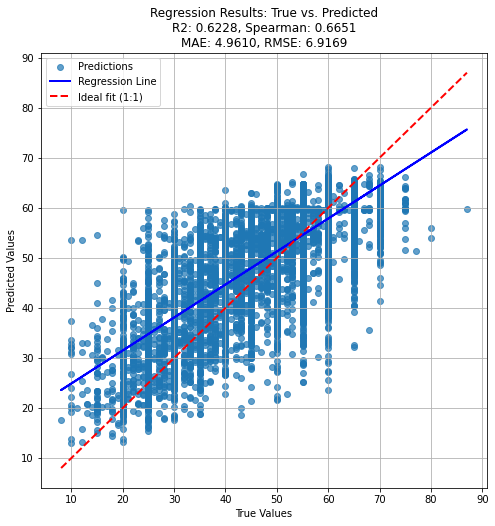

In [27]:
from scipy.stats import spearmanr, linregress
from torchmetrics import R2Score, MeanAbsoluteError, MeanSquaredError
import matplotlib.pyplot as plt
import torch
import numpy as np

def plot_regression_results_with_metrics(model=None, test_dataloader=None, y_true=None, y_pred=None):
    device = 'cuda:0'

    if model is not None: 
        model.eval()  # Set the model to evaluation mode
        y_true = []
        y_pred = []
    
        with torch.no_grad():  # Disable gradient calculation for evaluation
            for inputs, labels in test_dataloader:
                inputs, labels = inputs.to(device), labels.to(device).float()
                outputs = model(inputs)
                outputs = outputs.squeeze()  # Ensure the outputs are in the correct shape
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(outputs.cpu().numpy())

        # Convert lists to numpy arrays
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

    # Calculate R2 score
    r2_metric = R2Score().to(device)
    r2_metric.update(torch.tensor(y_pred), torch.tensor(y_true))
    r2_value = r2_metric.compute().item()

    # Calculate Spearman correlation
    spearman_corr, _ = spearmanr(y_true, y_pred)

    # Calculate additional metrics: MAE and RMSE
    mae_metric = MeanAbsoluteError().to(device)
    mse_metric = MeanSquaredError(squared=False).to(device)  # RMSE

    mae_metric.update(torch.tensor(y_pred), torch.tensor(y_true))
    mse_metric.update(torch.tensor(y_pred), torch.tensor(y_true))

    mae_value = mae_metric.compute().item()
    rmse_value = mse_metric.compute().item()

    # Linear regression for the regression line
    slope, intercept, _, _, _ = linregress(y_true, y_pred)
    regression_line = slope * y_true + intercept

    # Plotting the true values vs predicted values
    plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred, label="Predictions", alpha=0.7)
    plt.plot(y_true, regression_line, 'b-', lw=2, label="Regression Line")
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2, label="Ideal fit (1:1)")

    # Add labels, title, and metrics
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(
        f"Regression Results: True vs. Predicted\n"
        f"R2: {r2_value:.4f}, Spearman: {spearman_corr:.4f}\n"
        f"MAE: {mae_value:.4f}, RMSE: {rmse_value:.4f}"
    )
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_lvef_reg(results_key, root_dir='/volume/deepecg/fairseq-signals/outputs', subset='test'):
    results_path = get_path(results_key, root_dir)
    header_pkl=f"{results_path}/outputs_{subset}_header.pkl"
    header_npy=f"{results_path}/outputs_{subset}.npy"
    header = np.load(header_pkl, allow_pickle=True)
    y_pred = np.memmap(header_npy, 
        mode='r',
        shape=header['shape'],
        dtype=header['dtype']
    )
    df = pd.read_csv('/media/data1/ravram/DeepECG_Datasets/test_filtered_lite_LVEF_Continuous.csv')
    y_true = df['Visually Estimated EF_tte_lvef'].to_numpy()
    y_true = np.squeeze(y_true)
    y_pred = np.squeeze(y_pred)
    print(y_pred.shape, y_true.shape)
    
    plot_regression_results_with_metrics(y_pred=y_pred, y_true=y_true)

    
plot_lvef_reg('last-ft-fevg-reg-mse')
        

In [10]:
y = np.load("/media/data1/anolin/for_achille_ssl/NEW_DS/UKB_cleaned_high_pass_scaled/Y_UKB.npy")
y.shape

(54959, 77)

In [ ]:
folders_str = '10:1000:100000'

folder_name_len, skip, total = [int(x) for x in folders_str.split(':')]
#final_list = ['A-Z'] + [str(i*skip).zfill(folder_name_len) for i in range(total)]
final_list = [str(i*skip).zfill(folder_name_len) for i in range(total)]

len(final_list), final_list[:10], final_list[-10:]

#### Fairness and Privacy

In [5]:
import torch
import numpy as np
from tqdm import tqdm

#IMPORTANT ONE
def equalized_odds_with_average_pairwise_disparities(predictions, true_labels, protected_attributes, average='macro', 
                                                     num_iterations=1000, sample_fraction=0.7):
    """
    Calculate Equalized Odds using the average pairwise TPR/FPR disparities across groups with micro or macro averaging.

    Args:
        predictions (np.ndarray): Model predictions (N, num_labels) as binary values.
        true_labels (np.ndarray): True labels (N, num_labels) as binary values.
        protected_attributes (np.ndarray): Group membership (N,).
        average (str): 'micro' or 'macro' for averaging disparities.
        num_iterations (int): Number of iterations for permutation sampling.
        sample_fraction (float): Fraction of the data to sample in each iteration.

    Returns:
        dict: Mean and 95% CI for average pairwise TPR and FPR differences across groups.
    """
    # Convert inputs to PyTorch tensors
    predictions = torch.tensor(predictions, dtype=torch.float32)
    true_labels = torch.tensor(true_labels, dtype=torch.float32)
    protected_attributes = torch.tensor(protected_attributes, dtype=torch.float32)

    # Helper function to calculate TPR and FPR for a group
    def calculate_rates(group_preds, group_labels):
        true_positive = (group_preds * group_labels).sum(dim=0)
        false_positive = (group_preds * (1 - group_labels)).sum(dim=0)
        total_positive = group_labels.sum(dim=0)
        total_negative = (1 - group_labels).sum(dim=0)

        # Avoid division by zero by setting TPR or FPR to zero if the denominator is zero
        tpr = torch.where(total_positive > 0, true_positive / total_positive, torch.zeros_like(total_positive))
        fpr = torch.where(total_negative > 0, false_positive / total_negative, torch.zeros_like(total_negative))
        return tpr, fpr

    # Initialize storage for pairwise disparities
    tpr_diffs = []
    fpr_diffs = []

    # Iterate through permutations
    for _ in tqdm(range(num_iterations), desc="Calculating Equalized Odds"):
        # Randomly sample a fraction of the dataset
        sample_size = int(sample_fraction * len(predictions))
        indices = torch.randperm(len(predictions))[:sample_size]
        sampled_predictions = predictions[indices]
        sampled_true_labels = true_labels[indices]
        sampled_protected_attributes = protected_attributes[indices]

        # Calculate TPR and FPR for each group
        unique_groups = torch.unique(sampled_protected_attributes)
        group_rates = {}

        for group in unique_groups:
            group_mask = sampled_protected_attributes == group
            group_preds = sampled_predictions[group_mask]
            group_labels = sampled_true_labels[group_mask]
            group_rates[group.item()] = calculate_rates(group_preds, group_labels)

        # Extract TPRs and FPRs
        tprs = torch.stack([rate[0] for rate in group_rates.values()])  # TPR for each group (num_labels,)
        fprs = torch.stack([rate[1] for rate in group_rates.values()])  # FPR for each group (num_labels,)

        # Compute disparities based on averaging method
        if average == 'micro':
            # Micro: Compute disparity for each label and average across labels
            avg_tpr_diff = torch.mean(torch.abs(tprs.unsqueeze(1) - tprs.unsqueeze(0))).item()
            avg_fpr_diff = torch.mean(torch.abs(fprs.unsqueeze(1) - fprs.unsqueeze(0))).item()
        elif average == 'macro':
            # Macro: Compute disparity across groups for each label and average
            avg_tpr_diff = torch.mean(torch.mean(torch.abs(tprs.unsqueeze(1) - tprs.unsqueeze(0)), dim=(0, 1))).item()
            avg_fpr_diff = torch.mean(torch.mean(torch.abs(fprs.unsqueeze(1) - fprs.unsqueeze(0)), dim=(0, 1))).item()
        else:
            raise ValueError("average must be 'micro' or 'macro'")

        tpr_diffs.append(avg_tpr_diff)
        fpr_diffs.append(avg_fpr_diff)

    # Calculate mean and 95% confidence intervals for pairwise disparities
    results = {
        'tpr_diff_mean': np.mean(tpr_diffs),
        'tpr_diff_ci': np.percentile(tpr_diffs, [2.5, 97.5]),
        'fpr_diff_mean': np.mean(fpr_diffs),
        'fpr_diff_ci': np.percentile(fpr_diffs, [2.5, 97.5]),
    }

    return results

In [6]:
pd.set_option('display.max_columns', None)
metadata = pd.read_parquet('/media/data1/muse_ge/test_trial_v1.1.parquet')

protected_attributes = metadata['RestingECG_PatientDemographics_Gender']

if protected_attributes.dtype == 'object' or pd.api.types.is_categorical_dtype(protected_attributes):
    protected_attributes = pd.Categorical(protected_attributes).codes  # Convert to numerical codes


In [30]:
def equalized_odds(results_key, root_dir, subset, task, y_labels=[], categories=None, average='macro', device='cuda:1'):
    header_npy, header_pkl, df_path, npy_path, y_idx = read_manifest(results_key, root_dir, subset)
    y_pred, y_true = get_pred_labels(
        header_pkl=header_pkl,
        header_npy=header_npy,
        df_path=df_path,
        npy_path=npy_path,
        y_idx=y_idx,
        y_labels=y_labels
    )
    results_path = get_path(results_key)
    y_pred = torch.sigmoid(torch.from_numpy(y_pred).to(device=device))
    y_true = torch.from_numpy(y_true).to(device=device)

    
    protected_attributes = get_protected_attributes('sex')
    scores = equalized_odds_with_average_pairwise_disparities(y_pred, y_true, protected_attributes,  average='micro')
    score_sex = 
    n_perm = 1000
    ratio = 0.7
    scores.to_csv(os.path.join(results_path, f'fairness_{n_perm}_{ratio}.csv'))
    return scores

def get_protected_attributes(task='sex'):
    df = metadata
    protected_attributes = []
    if task == 'sex':
        protected_attributes = df['RestingECG_PatientDemographics_Gender']

    elif task == 'age':
        protected_attributes = []
        for age in df['calculated_age']:
            if age <= 55:
                protected_attributes.append(0)
            if age > 55 and age <= 75:
                protected_attributes.append(1)
            if age > 75:
                protected_attributes.append(2)
        df['age_bined'] = protected_attributes
        protected_attributes = df['age_bined'].to_numpy()

    if protected_attributes.dtype == 'object' or pd.api.types.is_categorical_dtype(protected_attributes):
        protected_attributes = pd.Categorical(protected_attributes).codes
    return protected_attributes

  

eodds = equalized_odds('last-ft-labels-77-bce', root_dir='nas', subset='labels-77/test', task='Age')
eodds

[0 1 1 ... 0 0 1] (287039,)
torch.Size([287039, 77]) torch.Size([287039, 77]) (287039,)


<ipython-input-5-fc6863a09a6d>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(predictions, dtype=torch.float32)
<ipython-input-5-fc6863a09a6d>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_labels = torch.tensor(true_labels, dtype=torch.float32)
Calculating Equalized Odds Permutations: 100%|██████████| 1000/1000 [00:23<00:00, 41.97it/s]


{'overall': {'tpr_diff_mean': 0.07702197676897049,
  'tpr_diff_ci': array([0.07412995, 0.08016479]),
  'fpr_diff_mean': 0.011249735537916422,
  'fpr_diff_ci': array([0.01105839, 0.01145861])}}

In [42]:
scores = {'overall': {'tpr_diff_mean': 0.040577467571944,
  'tpr_diff_ci': [0.03803694, 0.0432312 ],
  'fpr_diff_mean': 0.00413520280085504,
  'fpr_diff_ci': [0.00403636, 0.00424855]}}


def save_sl_fairness(scores_dict, subset):
    scores = {}
    labels = ['sex', 'age']
    for label in labels:
        scores[f'{label}_tpr_diff'] = {'mean': scores_dict[label]['tpr_diff_mean'], '95% CI': scores_dict[label]['tpr_diff_ci']}
        scores[f'{label}_fpr_diff'] = {'mean': scores_dict[label]['fpr_diff_mean'], '95% CI': scores_dict[label]['fpr_diff_ci']}

    scores = format_ci_metrics(scores, {}, labels, metrics=['tpr_diff', 'fpr_diff'], percentage=False)
    results_path = '/media/data1/anolin/for_achille_ssl/for_table'
    n_perm = 1000
    ratio = 0.7
    scores.to_csv(os.path.join(results_path, f'{subset}_77_labels', f'fairness_{n_perm}_{ratio}_.csv'))
    return scores
        
sex = {'tpr_diff_mean': 0.040047682074829935, 'tpr_diff_ci': ([0.03348139, 0.04754478]), 'fpr_diff_mean': 0.004037071496248245, 'fpr_diff_ci': ([0.00363798, 0.00447006])}
age = {'tpr_diff_mean': 0.07103977987542748, 'tpr_diff_ci': ([0.06431753, 0.07868859]), 'fpr_diff_mean': 0.010519978512078523, 'fpr_diff_ci': ([0.00983048, 0.01123024])}
save_sl_fairness(
    scores_dict={'age': age, 'sex': sex},
    subset='CLSA'
)


,Label,Metrics,Mean,95% CI
0,sex,tpr_diff,0.040,[0.033 - 0.048]
1,sex,fpr_diff,0.004,[0.004 - 0.004]
2,age,tpr_diff,0.071,[0.064 - 0.079]
3,age,fpr_diff,0.011,[0.010 - 0.011]


In [17]:
Y_train = np.load("/media/data1/anolin/Y_train_v1.1.npy").astype(np.float16)
Y_test = np.load("/media/data1/muse_ge/Y_test_v1.2.npy").astype(np.float16)


In [18]:
results_key = 'last-ft-labels-77-bce'
subset_dict = {'mhi': 'test', 'mimic': 'mimic_cleaned', 'ptb': 'ptb_cleaned', 'ukbb': 'ukbb_cleaned_high_pass_scaled', 'clsa': 'clsa_cleaned'}
subset = subset_dict['mhi']
header_npy, header_pkl, df_path, npy_path, y_idx = read_manifest(results_key, root_dir='nas', subset='labels-77/train')
train_probs, _ = get_pred_labels(header_pkl, header_npy, df_path=df_path, npy_path=npy_path,y_idx=y_idx)
train_probs = stable_sigmoid(train_probs)

header_npy, header_pkl, df_path, npy_path, y_idx = read_manifest(results_key, root_dir='nas', subset=f'labels-77/{subset}')
test_probs, _ = get_pred_labels(header_pkl, header_npy, df_path=df_path, npy_path=npy_path,y_idx=y_idx)
test_probs = stable_sigmoid(test_probs)        

# Example: Maximum confidence score across all labels
train_confidences = np.max(train_probs, axis=1)
test_confidences = np.max(test_probs, axis=1)

# Attack data preparation: Label train data as 1 (members) and test data as 0 (non-members)
attack_data = np.concatenate([train_probs, test_probs])
attack_labels = np.concatenate([np.ones(len(train_probs)), np.zeros(len(test_probs))])
y_labels =  ['Acute pericarditis', 'QS complex in V1-V2-V3', 'T wave inversion (anterior - V3-V4)', 'Right atrial enlargement','2nd degree AV block - mobitz 1','Left posterior fascicular block','Wolff-Parkinson-White (Pre-excitation syndrome)','Junctional rhythm','Premature ventricular complex',"rSR' in V1-V2",'Right superior axis','ST elevation (inferior - II, III, aVF)','Afib','ST elevation (anterior - V3-V4)','RV1 + SV6 > 11 mm','Sinusal','Monomorph','Delta wave','R/S ratio in V1-V2 >1','Third Degree AV Block','LV pacing','Nonspecific intraventricular conduction delay','ST depression (inferior - II, III, aVF)','Regular','Premature atrial complex','2nd degree AV block - mobitz 2','Left anterior fascicular block','Q wave (septal- V1-V2)','Prolonged QT','Left axis deviation','Left ventricular hypertrophy','ST depression (septal- V1-V2)','Supraventricular tachycardia','Atrial paced','Q wave (inferior - II, III, aVF)','no_qrs','T wave inversion (lateral -I, aVL, V5-V6)','Right bundle branch block','ST elevation (septal - V1-V2)','SV1 + RV5 or RV6 > 35 mm','Right axis deviation','RaVL > 11 mm','Polymorph','Ventricular tachycardia','QRS complex negative in III','ST depression (lateral - I, avL, V5-V6)','1st degree AV block','Lead misplacement','Q wave (posterior - V7-V9)','Atrial flutter','Ventricular paced','ST elevation (posterior - V7-V8-V9)','Ectopic atrial rhythm (< 100 BPM)','Early repolarization','Ventricular Rhythm','Irregularly irregular','Atrial tachycardia (>= 100 BPM)','R complex in V5-V6','ST elevation (lateral - I, aVL, V5-V6)','Brugada','Bi-atrial enlargement','Q wave (lateral- I, aVL, V5-V6)','ST upslopping','T wave inversion (inferior - II, III, aVF)','Regularly irregular','Bradycardia','qRS in V5-V6-I, aVL','Q wave (anterior - V3-V4)','Acute MI','ST depression (anterior - V3-V4)','Right ventricular hypertrophy','T wave inversion (septal- V1-V2)','ST downslopping','Left bundle branch block','Low voltage','U wave','Left atrial enlargement']

def save_ssl_privacy(scores_dict):
    label = 'privacy'
    scores = {}
    scores[f'{label}_auroc'] = {'mean': scores_dict['AUC'][0], '95% CI': list(scores_dict['AUC'][1])}
    scores[f'{label}_auprc'] = {'mean': scores_dict['AUPRC'][0], '95% CI': list(scores_dict['AUPRC'][1])}
    scores[f'{label}_acc'] = {'mean': scores_dict['Accuracy'][0], '95% CI': list(scores_dict['Accuracy'][1])}
    scores[f'{label}_bacc'] = {'mean': scores_dict['Balanced Accuracy'][0], '95% CI': list(scores_dict['Balanced Accuracy'][1])}
    scores[f'{label}_f1score'] = {'mean': scores_dict['F1 Score'][0], '95% CI': list(scores_dict['F1 Score'][1])}
    
    scores = format_ci_metrics(scores, {}, [label], metrics=['auroc', 'auprc', 'acc', 'bacc', 'f1score'],)
    results_path = get_path(results_key)
    n_perm = 1000
    ratio = 0.7
    scores.to_csv(os.path.join(results_path, f"privacy_{subset.split('/')[-1]}_{ratio}_{n_perm}.csv"))
    #scores.to_csv(os.path.join(results_path, f'{subset}_77_labels', f'fairness_{ratio}_{n_perm}_{ratio}.csv'))
    return scores


Training iterations: 100%|██████████| 10/10 [00:00<00:00, 101.33it/s]


AUC - Mean: 0.5741, 95% CI: [0.5726, 0.5768]
AUPRC - Mean: 0.5532, 95% CI: [0.5510, 0.5557]
Accuracy - Mean: 0.5083, 95% CI: [0.5081, 0.5085]
Balanced Accuracy - Mean: 0.5083, 95% CI: [0.5081, 0.5085]
F1 Score - Mean: 0.6700, 95% CI: [0.6698, 0.6701]


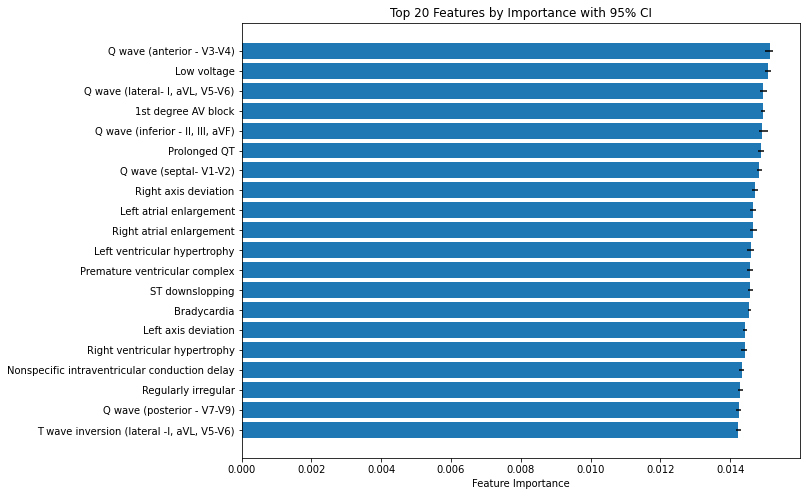

(     Label  Metrics   Mean           95% CI
 0  privacy    auroc  57.41  [57.26 - 57.68]
 1  privacy    auprc  55.32  [55.10 - 55.57]
 2  privacy      acc  50.83  [50.81 - 50.85]
 3  privacy     bacc  50.83  [50.81 - 50.85]
 4  privacy  f1score  67.00  [66.98 - 67.01],
 {'AUC': (0.5740524171485302, (0.5725729741578087, 0.57684190962766)),
  'AUPRC': (0.5531982167857841, (0.5509977298656825, 0.5556505801247642)),
  'Accuracy': (0.5082802612837731, (0.5080578052029125, 0.5085249530665723)),
  'Balanced Accuracy': (0.5082802612837731,
   (0.5080578052029125, 0.5085249530665723)),
  'F1 Score': (0.6699558379645689, (0.6698274671627933, 0.6701208221730346))})

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, f1_score, balanced_accuracy_score
from tqdm import tqdm
from joblib import Parallel, delayed
from scipy.stats import linregress

# Predefined seeds for reproducibility
seeds = [42, 0, 7, 13, 21, 25, 31, 37, 51, 57]

# Define feature names based on the number of columns in train_probs
# This should match the number of labels or classes you have
feature_names = [f"feature_{i}" for i in range(train_probs.shape[1])]

# Function to train and evaluate the model for a given seed
def train_and_evaluate(seed):
    X_train_attack, X_test_attack, y_train_attack, y_test_attack = train_test_split(
        attack_data, attack_labels, test_size=0.2, random_state=seed
    )
    
    class_0_indices = np.where(y_test_attack == 0)[0]
    class_1_indices = np.where(y_test_attack == 1)[0]
    min_class_size = min(len(class_0_indices), len(class_1_indices))
    
    balanced_class_0_indices = np.random.choice(class_0_indices, min_class_size, replace=False)
    balanced_class_1_indices = np.random.choice(class_1_indices, min_class_size, replace=False)
    balanced_indices = np.concatenate([balanced_class_0_indices, balanced_class_1_indices])
    
    X_test_attack_balanced = X_test_attack[balanced_indices]
    y_test_attack_balanced = y_test_attack[balanced_indices]

    attack_model = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=seed)
    attack_model.fit(X_train_attack, y_train_attack)

    feature_importances = attack_model.feature_importances_

    attack_preds_proba = attack_model.predict_proba(X_test_attack_balanced)[:, 1]
    attack_preds = attack_model.predict(X_test_attack_balanced)

    auc = roc_auc_score(y_test_attack_balanced, attack_preds_proba)
    auprc = average_precision_score(y_test_attack_balanced, attack_preds_proba)
    accuracy = accuracy_score(y_test_attack_balanced, attack_preds)
    balanced_accuracy = balanced_accuracy_score(y_test_attack_balanced, attack_preds)
    f1 = f1_score(y_test_attack_balanced, attack_preds)
    
    return auc, auprc, accuracy, balanced_accuracy, f1, feature_importances

# Run iterations and collect results
results = Parallel(n_jobs=-1)(delayed(train_and_evaluate)(seed) for seed in tqdm(seeds, desc="Training iterations"))
auc_scores, auprc_scores, accuracy_scores, balanced_accuracy_scores, f1_scores, feature_importances_all = zip(*results)

def mean_and_ci(scores):
    mean_score = np.mean(scores)
    ci_lower, ci_upper = np.percentile(scores, [2.5, 97.5])
    return mean_score, (ci_lower, ci_upper)

metrics = {
    "AUC": mean_and_ci(auc_scores),
    "AUPRC": mean_and_ci(auprc_scores),
    "Accuracy": mean_and_ci(accuracy_scores),
    "Balanced Accuracy": mean_and_ci(balanced_accuracy_scores),
    "F1 Score": mean_and_ci(f1_scores)
}

for metric, (mean, ci) in metrics.items():
    print(f"{metric} - Mean: {mean:.4f}, 95% CI: [{ci[0]:.4f}, {ci[1]:.4f}]")

# Calculate mean feature importances

feature_importances_all = np.array(feature_importances_all)
mean_importances = np.mean(feature_importances_all, axis=0)
ci_importances = np.percentile(feature_importances_all, [2.5, 97.5], axis=0)
ci_lower = ci_importances[0]
ci_upper = ci_importances[1]

# Get top 20 features based on average importance
top_indices = np.argsort(mean_importances)[-20:][::-1]
top_features = [y_labels[i] for i in top_indices]  # Use new_label_names for labels
top_mean_importances = mean_importances[top_indices]
top_ci_lower = ci_lower[top_indices]
top_ci_upper = ci_upper[top_indices]

# Plot top 20 features with confidence intervals
plt.figure(figsize=(10, 8))
plt.barh(top_features, top_mean_importances, xerr=[top_mean_importances - top_ci_lower, top_ci_upper - top_mean_importances], align='center')
plt.xlabel('Feature Importance')
plt.title('Top 20 Features by Importance with 95% CI')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.show()

# Calculate label frequencies in y_train and y_test
train_freq = np.mean(Y_train, axis=0)
test_freq = np.mean(Y_test, axis=0)

# Compute the relative difference in frequency
#relative_diff = (train_freq - test_freq) / (train_freq)

# Scatter plot of relative difference in frequency vs feature importance
#plt.figure(figsize=(10, 6))
#plt.scatter(relative_diff, mean_importances, alpha=0.7, color="b", label="Features")

# Regression line
#slope, intercept, r_value, p_value, std_err = linregress(relative_diff, mean_importances)
#line = slope * relative_diff + intercept
#plt.plot(relative_diff, line, 'r', label=f"Regression line (r={r_value:.2f})")

# Labels and title
#plt.xlabel("Relative Difference in Label Frequency (Train vs Test)")
#plt.ylabel("Average Feature Importance")
#plt.title("Correlation Between Label Frequency Difference and Feature Importance")
#plt.legend()
#plt.show()

save_ssl_privacy(metrics), metrics

In [15]:
def save_sl_privacy(scores_dict, subset):
    label = 'privacy'
    scores = {}
    scores[f'{label}_auroc'] = {'mean': scores_dict['AUC'][0], '95% CI': list(scores_dict['AUC'][1])}
    scores[f'{label}_auprc'] = {'mean': scores_dict['AUPRC'][0], '95% CI': list(scores_dict['AUPRC'][1])}
    scores[f'{label}_acc'] = {'mean': scores_dict['Accuracy'][0], '95% CI': list(scores_dict['Accuracy'][1])}
    scores[f'{label}_bacc'] = {'mean': scores_dict['Balanced Accuracy'][0], '95% CI': list(scores_dict['Balanced Accuracy'][1])}
    scores[f'{label}_f1score'] = {'mean': scores_dict['F1 Score'][0], '95% CI': list(scores_dict['F1 Score'][1])}
    
    scores = format_ci_metrics(scores, {}, [label], metrics=['auroc', 'auprc', 'acc', 'bacc', 'f1score'],)
    results_path = '/media/data1/anolin/for_achille_ssl/for_table'
    n_perm = 1000
    ratio = 0.7
    scores.to_csv(os.path.join(results_path, f'{subset}_77_labels', f'privacy_{n_perm}_{ratio}_.csv'))
    return scores


save_sl_privacy(
     {'AUC': (0.578416194578245, (0.575926938576351, 0.5817773373812397)), 'AUPRC': (0.5567188449991891, (0.5545273328301821, 0.56000041736794)), 'Accuracy': (0.5100158175954501, (0.5095547142284523, 0.5103799170347778)), 'Balanced Accuracy': (0.5100158175954502, (0.5095547142284523, 0.5103799170347779)), 'F1 Score': (0.6705999359043787, (0.6704011481374901, 0.6707812802103431))}      

,subset='MHI'
)

,Label,Metrics,Mean,95% CI
0,privacy,auroc,57.84,[57.59 - 58.18]
1,privacy,auprc,55.67,[55.45 - 56.00]
2,privacy,acc,51.00,[50.96 - 51.04]
3,privacy,bacc,51.00,[50.96 - 51.04]
4,privacy,f1score,67.06,[67.04 - 67.08]


In [17]:
import numpy as np
import pandas as pd

#np.load('/media/data1/anolin/Y_val_v1.1.npy').shape
#pd.read_csv('/media/data1/ravram/DeepECG_Datasets/val_filtered_echo_v2.csv').shape

#np.load('/media/data1/anolin/for_achille_ssl/AFIB/Y_Afib_filtered_val.npy').shape
pd.read_csv('/media/data1/ravram/DeepECG_Datasets/mhi-lqts-type-train-lite.csv').shape


(287, 6)

In [18]:
n_mhi = 1017719 + 149177 
n_lvef = 88677 + 823
n_afib = 469197 + 68545
n_lqts = 2210 + 531
n_lqts_type = 287 + 47

n_lqts_type, n_lqts, n_lvef, n_afib, n_mhi, 

(334, 2741, 89500, 537742, 1166896)